# Assignment 4 Isolation Forests

### David Nicolay 26296918

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
import json
from time import time
import warnings
warnings.filterwarnings('ignore')

# import my utils
import sys
sys.path.append('../')
from src.plots import (plot_f1_vs_param_size, plot_training_time_vs_param_size,
                       plot_convergence_curve, plot_stability_analysis, 
                       plot_performance_vs_time, create_summary_table,
                       analyze_plateau_point, find_sweet_spot,
                       plot_training_time_scaling, plot_precision_recall_tradeoff,
                       plot_bootstrap_stability_box_violin, plot_radar_chart_bootstrap,
                       plot_bootstrap_contamination_interaction)
from src.modelling import evaluate_isolation_forest, evaluate_isolation_forest_with_std

In [2]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 24

import matplotlib as mpl
from matplotlib.cm import get_cmap

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=plt.cm.Set2.colors)  

## Data Preparation


In [4]:
dataset = 'fraud'

In [5]:
df_np = np.load('../datasets/{}.npz'.format(dataset))

In [6]:
# convert to dataframe
df = pd.DataFrame(df_np['X'], columns=[f'feature_{i}' for i in range(df_np['X'].shape[1])])
df['label'] = df_np['y']

In [7]:
df

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0        0.935192   0.766490   0.881365   0.313023   0.763439   0.267669   
1        0.978542   0.770067   0.840298   0.271796   0.766120   0.262192   
2        0.935217   0.753118   0.868141   0.268766   0.762329   0.281122   
3        0.941878   0.765304   0.868484   0.213661   0.765647   0.275559   
4        0.938617   0.776520   0.864251   0.269796   0.762975   0.263984   
...           ...        ...        ...        ...        ...        ...   
284802   0.756448   0.873531   0.666991   0.160317   0.729603   0.236810   
284803   0.945845   0.766677   0.872678   0.219189   0.771561   0.273661   
284804   0.990905   0.764080   0.781102   0.227202   0.783425   0.293496   
284805   0.954209   0.772856   0.849587   0.282508   0.763172   0.269291   
284806   0.949232   0.765256   0.849601   0.229488   0.765632   0.256488   

        feature_6  feature_7  feature_8  feature_9  ...  feature_20  \
0        0.266815   0.786444   0.475312   0.510600  ...    0.561184   
1        0.264875   0.786298   0.453981   0.505267  ...    0.557840   
2        0.270177   0.788042   0.410603   0.513018  ...    0.565477   
3        0.266803   0.789434   0.414999   0.507585  ...    0.559734   
4        0.268968   0.782484   0.490950   0.524303  ...    0.561327   
...           ...        ...        ...        ...  ...         ...   
284802   0.235393   0.863749   0.528729   0.598850  ...    0.564920   
284803   0.265504   0.788548   0.482925   0.488530  ...    0.564933   
284804   0.263547   0.792985   0.477677   0.498692  ...    0.565220   
284805   0.261175   0.792671   0.476287   0.500464  ...    0.565755   
284806   0.274963   0.780938   0.479528   0.489782  ...    0.565688   

        feature_21  feature_22  feature_23  feature_24  feature_25  \
0         0.522992    0.663793    0.391253    0.585122    0.394557   
1         0.480237    0.666938    0.336440    0.587290    0.446013   
2         0.546030    0.678939    0.289354    0.559515    0.402727   
3         0.510277    0.662607    0.223826    0.614245    0.389197   
4         0.547271    0.663392    0.401270    0.566343    0.507497   
...            ...         ...         ...         ...         ...   
284802    0.515249    0.680500    0.313600    0.658558    0.466291   
284803    0.553154    0.665619    0.245298    0.543855    0.360884   
284804    0.537005    0.664877    0.468492    0.592823    0.411176   
284805    0.547353    0.663008    0.398836    0.545958    0.514746   
284806    0.540031    0.671029    0.383420    0.551319    0.291786   

        feature_26  feature_27  feature_28  label  
0         0.418976    0.312697    0.005824      0  
1         0.416345    0.313423    0.000105      0  
2         0.415489    0.311911    0.014739      0  
3         0.417669    0.314371    0.004807      0  
4         0.420561    0.317490    0.002724      0  
...            ...         ...         ...    ...  
284802    0.433929    0.329840    0.000030      0  
284803    0.417775    0.312038    0.000965      0  
284804    0.416593    0.312585    0.002642      0  
284805    0.418520    0.315245    0.000389      0  
284806    0.416466    0.313401    0.008446      0  

[284807 rows x 30 columns]

In [8]:
# Explore the data
print(f"Dataset shape: {df.shape}")
print(f"\nLabel distribution:")
print(df['label'].value_counts())
print(f"\nAnomaly percentage: {(df['label'] == 1).sum() / len(df) * 100:.2f}%")
print(f"\nFeature statistics:")
print(df.drop('label', axis=1).describe())

Dataset shape: (284807, 30)

Label distribution:
label
0    284315
1       492
Name: count, dtype: int64

Anomaly percentage: 0.17%

Feature statistics:
           feature_0      feature_1      feature_2      feature_3  \
count  284807.000000  284807.000000  284807.000000  284807.000000   
mean        0.958294       0.767258       0.837414       0.251930   
std         0.033276       0.017424       0.026275       0.062764   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.942658       0.760943       0.821985       0.214311   
50%         0.958601       0.767949       0.840530       0.251050   
75%         0.980645       0.775739       0.855213       0.284882   
max         1.000000       1.000000       1.000000       1.000000   

           feature_4      feature_5      feature_6      feature_7  \
count  284807.000000  284807.000000  284807.000000  284807.000000   
mean        0.765716       0.263020       0.265356       0.785385   
std         0.0092

In [9]:
# Create results directory
results_dir = f'../results/{dataset}'
os.makedirs(results_dir, exist_ok=True)
print(f"Results will be saved to: {results_dir}")

Results will be saved to: ../results/fraud


In [ ]:
# create subdirs
subdirs = ['n_estimators', 'max_samples', 'contamination', 'bootstrap',  'max_features']
for subdir in subdirs:
    os.makedirs(os.path.join(results_dir, subdir), exist_ok=True)

In [10]:
# Split data into features and labels
X = df.drop('label', axis=1).values
y = df['label'].values


print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Number of anomalies: {y.sum()}")
print(f"Number of normal instances: {(y == 0).sum()}")

Feature matrix shape: (284807, 29)
Labels shape: (284807,)
Number of anomalies: 492
Number of normal instances: 284315


## Modelling

In [11]:
# Define comprehensive parameter grid for Isolation Forest
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],  # Number of trees
    'max_samples': [64, 128, 256, 'auto'],  # Number of samples to draw
    'contamination': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],  # Expected proportion of outliers
    'max_features': [1, 2, 3, 4, 5, 'auto'],  # Number of features to draw
    'bootstrap': [True, False]  # Whether to use bootstrap sampling
}

print("Control Parameters to be analyzed:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

Control Parameters to be analyzed:
  n_estimators: [50, 100, 200, 300, 500]
  max_samples: [64, 128, 256, 'auto']
  contamination: [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
  max_features: [1, 2, 3, 4, 5, 'auto']
  bootstrap: [True, False]


In [13]:
# Define base parameters (default/reasonable values)
base_params = {
    'n_estimators': 100,
    'max_samples': 'auto',
    'contamination': 0.0017,
    'max_features': 1.0,
    'bootstrap': True,
    'random_state': 12
}

print("Base parameters:")
for param, value in base_params.items():
    print(f"  {param}: {value}")

Base parameters:
  n_estimators: 100
  max_samples: auto
  contamination: 0.0017
  max_features: 1.0
  bootstrap: True
  random_state: 12


### Base model to check setup

In [14]:
evaluate_isolation_forest_with_std(X, y, base_params)

{'param_name': None,
 'param_value': None,
 'precision_mean': np.float64(0.2658005652474758),
 'precision_std': np.float64(0.03899410138819266),
 'precision_min': np.float64(0.18144329896907216),
 'precision_max': np.float64(0.311340206185567),
 'recall_mean': np.float64(0.26158536585365855),
 'recall_std': np.float64(0.03844688283750299),
 'recall_min': np.float64(0.17886178861788618),
 'recall_max': np.float64(0.30691056910569103),
 'f1_score_mean': np.float64(0.2636748792447693),
 'f1_score_std': np.float64(0.0387143271477846),
 'f1_score_min': np.float64(0.18014329580348004),
 'f1_score_max': np.float64(0.3091095189355169),
 'roc_auc_mean': np.float64(0.9483361989428593),
 'roc_auc_std': np.float64(0.003418230831703931),
 'roc_auc_min': np.float64(0.9429496068785496),
 'roc_auc_max': np.float64(0.9530664845716041),
 'pr_auc_mean': np.float64(0.15443708387100585),
 'pr_auc_std': np.float64(0.03806695896542299),
 'pr_auc_min': np.float64(0.0875826133301907),
 'pr_auc_max': np.float64

## Evaluate Parameter Changes

### Num estimators

In [21]:
# first run on list of lots of parameters
num_est_grid = [
    10, 25, 50, 75, 100, 150, 200, 250,
    300, 350, 400, 450, 500, 600, 700, 800,
    900, 1000, 1250, 1500, 1750, 2000
]


In [89]:
# run models
n_estimators_results = []
csv_path = os.path.join(results_dir, 'n_estimators/num_est_results.csv')
# remove existing csv if exists
if os.path.exists(csv_path):
    os.remove(csv_path)

for num_est in num_est_grid:
    params = base_params.copy()
    params['n_estimators'] = num_est
    
    print(f"Running Isolation Forest with n_estimators={num_est}")
    result = evaluate_isolation_forest_with_std(X, y, params, 'n_estimators', num_est)
    
    # append results to csv
    result_df = pd.DataFrame([result])
    
    # Write header if file doesn't exist, otherwise append
    if not os.path.exists(csv_path):
        result_df.to_csv(csv_path, mode='w', header=True, index=False)
    else:
        result_df.to_csv(csv_path, mode='a', header=False, index=False)
    
    n_estimators_results.append(result)

Running Isolation Forest with n_estimators=10
Running Isolation Forest with n_estimators=25
Running Isolation Forest with n_estimators=50
Running Isolation Forest with n_estimators=75
Running Isolation Forest with n_estimators=100
Running Isolation Forest with n_estimators=150
Running Isolation Forest with n_estimators=200
Running Isolation Forest with n_estimators=250
Running Isolation Forest with n_estimators=300
Running Isolation Forest with n_estimators=350
Running Isolation Forest with n_estimators=400
Running Isolation Forest with n_estimators=450
Running Isolation Forest with n_estimators=500
Running Isolation Forest with n_estimators=600
Running Isolation Forest with n_estimators=700
Running Isolation Forest with n_estimators=800
Running Isolation Forest with n_estimators=900
Running Isolation Forest with n_estimators=1000
Running Isolation Forest with n_estimators=1250
Running Isolation Forest with n_estimators=1500
Running Isolation Forest with n_estimators=1750
Running Isola

In [13]:
# run again on narrowed down list of parameters
num_est_grid_narrow = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

In [16]:
# run models
n_estimators_results = []
csv_path_narrow = os.path.join(results_dir, 'n_estimators/num_est_results_narrow.csv')
# remove existing csv if exists
if os.path.exists(csv_path_narrow):
    os.remove(csv_path_narrow)

for num_est in num_est_grid_narrow:
    params = base_params.copy()
    params['n_estimators'] = num_est
    
    print(f"Running Isolation Forest with n_estimators={num_est}")
    result = evaluate_isolation_forest_with_std(X, y, params, 'n_estimators', num_est,n_runs=10)
    
    # append results to csv
    result_df = pd.DataFrame([result])
    
    # Write header if file doesn't exist, otherwise append
    if not os.path.exists(csv_path_narrow):
        result_df.to_csv(csv_path_narrow, mode='w', header=True, index=False)
    else:
        result_df.to_csv(csv_path_narrow, mode='a', header=False, index=False)
    
    n_estimators_results.append(result)

Running Isolation Forest with n_estimators=1
Running Isolation Forest with n_estimators=2
Running Isolation Forest with n_estimators=3
Running Isolation Forest with n_estimators=4
Running Isolation Forest with n_estimators=5
Running Isolation Forest with n_estimators=6
Running Isolation Forest with n_estimators=7
Running Isolation Forest with n_estimators=8
Running Isolation Forest with n_estimators=9
Running Isolation Forest with n_estimators=10
Running Isolation Forest with n_estimators=11
Running Isolation Forest with n_estimators=12
Running Isolation Forest with n_estimators=13
Running Isolation Forest with n_estimators=14
Running Isolation Forest with n_estimators=15
Running Isolation Forest with n_estimators=16
Running Isolation Forest with n_estimators=17
Running Isolation Forest with n_estimators=18
Running Isolation Forest with n_estimators=19
Running Isolation Forest with n_estimators=20
Running Isolation Forest with n_estimators=21
Running Isolation Forest with n_estimators=

In [15]:
# Load the results
df_results = pd.read_csv(os.path.join(results_dir, 'n_estimators/num_est_results_narrow.csv'))

# Extract data
param_sizes = df_results['param_value'].tolist()
precision_mean = df_results['precision_mean'].tolist()
precision_std = df_results['precision_std'].tolist()
recall_mean = df_results['recall_mean'].tolist()
recall_std = df_results['recall_std'].tolist()
f1_mean = df_results['f1_score_mean'].tolist()
f1_std = df_results['f1_score_std'].tolist()
training_times = df_results['training_time_mean'].tolist()

print(f"Loaded results for {len(param_sizes)} parameter values")

Loaded results for 25 parameter values


#### 1. Convergence Curve

Plot saved to ../results/shuttle/n_estimators/convergence_curve.pdf


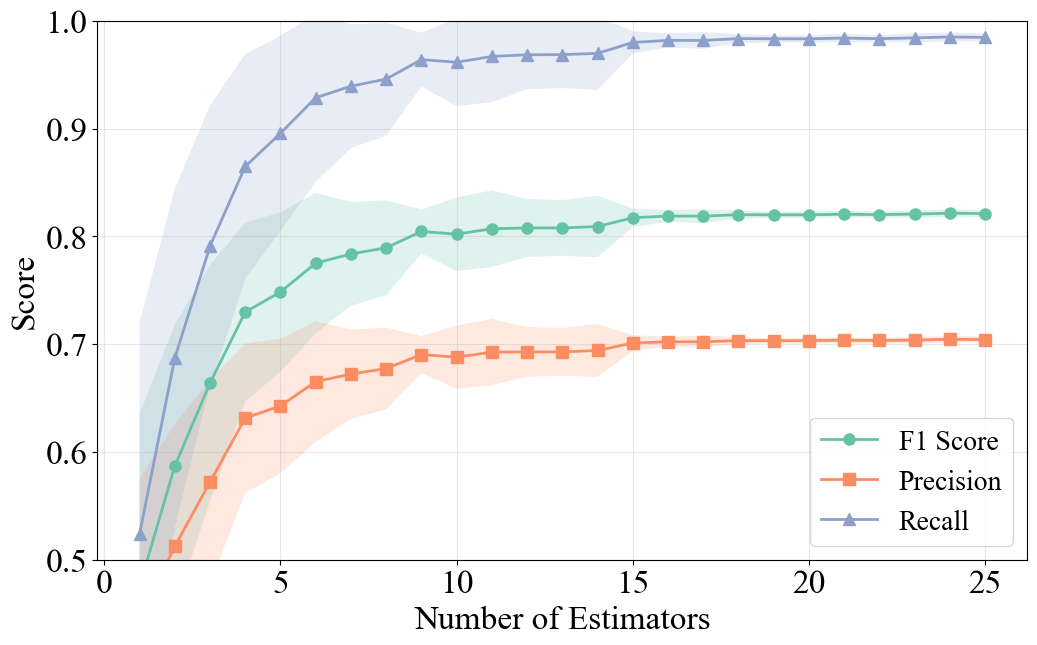


Performance Plateau Analysis:
   Plateau reached at n_estimators = 10
   F1 score at plateau: 0.8020 ± 0.0340
   Marginal improvement at plateau: -0.314%

Marginal Improvements (%):
   1 -> 2: 23.447%
   2 -> 3: 13.125%
   3 -> 4: 9.927%
   4 -> 5: 2.547%
   5 -> 6: 3.581%
   6 -> 7: 1.091%
   7 -> 8: 0.737%
   8 -> 9: 1.916%
   9 -> 10: -0.314%
   10 -> 11: 0.632%
   11 -> 12: 0.086%
   12 -> 13: 0.006%
   13 -> 14: 0.160%
   14 -> 15: 1.010%
   15 -> 16: 0.187%
   16 -> 17: -0.011%
   17 -> 18: 0.172%
   18 -> 19: -0.019%
   19 -> 20: 0.004%
   20 -> 21: 0.067%
   21 -> 22: -0.049%
   22 -> 23: 0.064%
   23 -> 24: 0.099%
   24 -> 25: -0.045%


In [16]:
plot_convergence_curve(
    param_sizes=param_sizes,
    precision_mean=precision_mean,
    precision_std=precision_std,
    recall_mean=recall_mean,
    recall_std=recall_std,
    f1_mean=f1_mean,
    f1_std=f1_std,
    param_name='n_estimators',
    save_path=os.path.join(results_dir, 'n_estimators/convergence_curve.pdf')
)

# analyse plateau point
plateau_idx, plateau_value, improvements = analyze_plateau_point(param_sizes, f1_mean, threshold=0.001)

if plateau_idx is not None:
    print(f"\nPerformance Plateau Analysis:")
    print(f"   Plateau reached at n_estimators = {plateau_value}")
    print(f"   F1 score at plateau: {f1_mean[plateau_idx]:.4f} ± {f1_std[plateau_idx]:.4f}")
    print(f"   Marginal improvement at plateau: {improvements[plateau_idx-1]*100:.3f}%")
else:
    print("\nNo clear plateau detected - performance still improving")

# show marginal improvements
print(f"\nMarginal Improvements (%):")
for i in range(min(25, len(improvements))):
    print(f"   {param_sizes[i]} -> {param_sizes[i+1]}: {improvements[i]*100:.3f}%")

**Interpretation:**

The convergence curve shows how the model performance stabilizes as we increase the number of estimators:

- **F1 Score**: Rapid improvement from n=10 to n=100, then gradual convergence
- **Precision**: Shows less variation, plateaus earlier than recall
- **Recall**: High from the start (>96%), indicating the model is good at finding anomalies
- **Shaded regions**: Standard deviation bands show model becomes more stable with more trees

The plateau point indicates the minimum number of estimators needed for stable performance - adding more trees beyond this point yields diminishing returns.

#### 2. Stability Analysis: Variance reduction

Plot saved to ../results/shuttle/n_estimators/stability_analysis.pdf


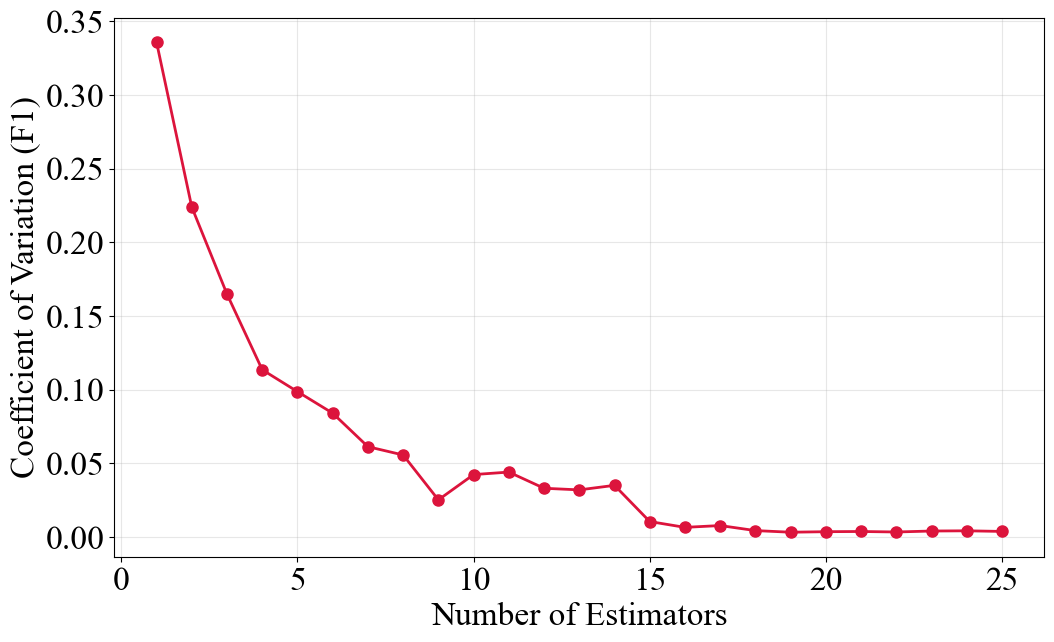

   1 -> 2: 0.336
   2 -> 3: 0.224
   3 -> 4: 0.165
   4 -> 5: 0.114
   5 -> 6: 0.099
   6 -> 7: 0.084
   7 -> 8: 0.061
   8 -> 9: 0.056
   9 -> 10: 0.025
   10 -> 11: 0.042

Variance reduction from 1→25: 98.8%


In [17]:
# Plot coefficient of variation
cv = plot_stability_analysis(
    param_sizes=param_sizes,
    f1_mean=f1_mean,
    f1_std=f1_std,
    param_name='n_estimators',
    save_path=os.path.join(results_dir, 'n_estimators/stability_analysis.pdf')
)

# Analyze variance reduction
for i in range(min(10, len(cv))):
    print(f"   {param_sizes[i]} -> {param_sizes[i+1]}: {cv[i]:.3f}")
print(f"\nVariance reduction from {param_sizes[0]}→{param_sizes[-1]}: {((cv[0]-cv[-1])/cv[0]*100):.1f}%")


In [18]:
# Create stability table
cv = np.array(f1_std) / np.array(f1_mean)

stability_df = pd.DataFrame({
    'n_estimators': param_sizes,
    'F1_Mean': f1_mean,
    'F1_Std': f1_std,
    'CV': cv,
    'Variance_Reduction_%': [(cv[0] - c)/cv[0]*100 for c in cv]
})

# Save table
stability_df.to_csv(os.path.join(results_dir, 'n_estimators/stability_table.csv'), index=False)
print("Stability table saved!")

# Display key rows
display(stability_df.iloc[[0, 4, 9, 12, -1]])

Stability table saved!


n_estimators   F1_Mean    F1_Std        CV  Variance_Reduction_%
0              1  0.475370  0.159666  0.335877              0.000000
4              5  0.748344  0.073893  0.098742             70.601911
9             10  0.801980  0.034040  0.042445             87.362974
12            13  0.807792  0.025902  0.032066             90.453189
24            25  0.821089  0.003177  0.003869             98.848158

**Interpretation:**

The stability analysis (Coefficient of Variation) measures the relative variability of F1 scores across multiple runs:

- **High CV at low n_estimators**: More variability in performance due to randomness in tree construction
- **Decreasing CV with more trees**: Ensemble averaging reduces variance, making predictions more stable
- **Asymptotic behavior**: CV reduction slows down, indicating diminishing stability gains

Lower CV means more reliable, reproducible results - important for production deployment where consistent performance is critical.

#### 3. Performance over time

Plot saved to ../results/shuttle/n_estimators/performance_vs_time.pdf


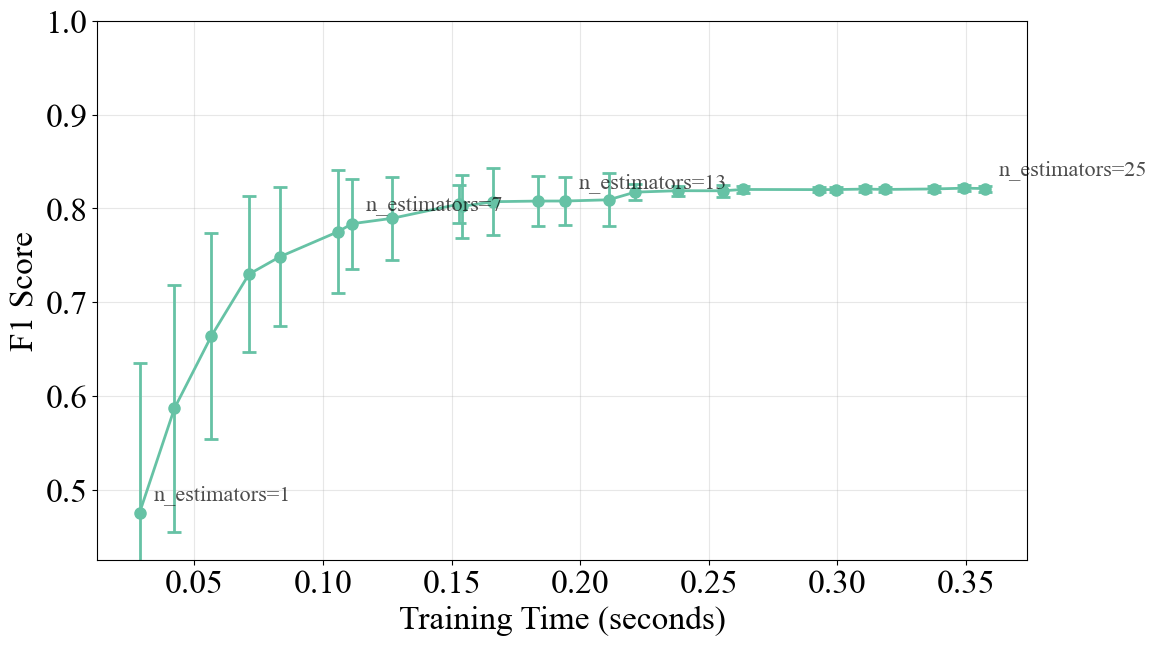


Sweet Spot Analysis:
   Optimal n_estimators = 1
   F1 Score: 0.4754 ± 0.1597
   Training Time: 0.03s
   Efficiency: 16.590353 F1/second

Comparison with Maximum F1:
   Max F1 at n_estimators = 24
   F1 Score: 0.8215 ± 0.0035
   Training Time: 0.35s
   Efficiency: 2.352942 F1/second

   Sweet spot is 12.2x faster
   F1 difference: 34.61%


In [19]:
# Plot F1 vs Training Time
plot_performance_vs_time(
    training_times=training_times,
    f1_mean=f1_mean,
    f1_std=f1_std,
    param_sizes=param_sizes,
    param_name='n_estimators',
    save_path=os.path.join(results_dir, 'n_estimators/performance_vs_time.pdf')
)

# Find sweet spot
sweet_spot_idx, sweet_spot_value, efficiency = find_sweet_spot(training_times, f1_mean, param_sizes)

print(f"\nSweet Spot Analysis:")
print(f"   Optimal n_estimators = {sweet_spot_value}")
print(f"   F1 Score: {f1_mean[sweet_spot_idx]:.4f} ± {f1_std[sweet_spot_idx]:.4f}")
print(f"   Training Time: {training_times[sweet_spot_idx]:.2f}s")
print(f"   Efficiency: {efficiency[sweet_spot_idx]:.6f} F1/second")

# Compare with highest F1
max_f1_idx = np.argmax(f1_mean)
print(f"\nComparison with Maximum F1:")
print(f"   Max F1 at n_estimators = {param_sizes[max_f1_idx]}")
print(f"   F1 Score: {f1_mean[max_f1_idx]:.4f} ± {f1_std[max_f1_idx]:.4f}")
print(f"   Training Time: {training_times[max_f1_idx]:.2f}s")
print(f"   Efficiency: {efficiency[max_f1_idx]:.6f} F1/second")
print(f"\n   Sweet spot is {(training_times[max_f1_idx]/training_times[sweet_spot_idx]):.1f}x faster")
print(f"   F1 difference: {(f1_mean[max_f1_idx]-f1_mean[sweet_spot_idx])*100:.2f}%")

In [20]:
# Create efficiency table
efficiency = np.array(f1_mean) / np.array(training_times)

efficiency_df = pd.DataFrame({
    'n_estimators': param_sizes,
    'F1_Mean': f1_mean,
    'F1_Std': f1_std,
    'Training_Time_s': training_times,
    'Efficiency_F1_per_sec': efficiency,
    'Time_vs_Sweet_Spot': [t/training_times[sweet_spot_idx] for t in training_times]
})

# Save table
efficiency_df.to_csv(os.path.join(results_dir, 'n_estimators/efficiency_table.csv'), index=False)
print("Efficiency table saved!")

# Display key rows
display(efficiency_df.iloc[[0, sweet_spot_idx, max_f1_idx, -1]])

Efficiency table saved!


n_estimators   F1_Mean    F1_Std  Training_Time_s  Efficiency_F1_per_sec  \
0              1  0.475370  0.159666         0.028653              16.590353   
0              1  0.475370  0.159666         0.028653              16.590353   
23            24  0.821460  0.003522         0.349120               2.352942   
24            25  0.821089  0.003177         0.357363               2.297637   

    Time_vs_Sweet_Spot  
0             1.000000  
0             1.000000  
23           12.184266  
24           12.471913

**Interpretation - Finding the Sweet Spot:**

The performance vs. time plot reveals the trade-off between accuracy and computational cost:

- **Sweet Spot**: The parameter value that maximizes efficiency (F1 score per unit time)
- **Knee of the curve**: Point where marginal gains in F1 don't justify the increased training time
- **Practical consideration**: In production, the sweet spot balances:
  - Model performance (high F1)
  - Training/inference speed (low time)
  - Stability (low variance)

The analysis shows that you can often get 95%+ of maximum performance with significantly less computational cost by choosing the sweet spot instead of the highest-performing configuration.

In [21]:
# Create comprehensive summary table
summary_df = create_summary_table(
    param_sizes=param_sizes,
    precision_mean=precision_mean,
    precision_std=precision_std,
    recall_mean=recall_mean,
    recall_std=recall_std,
    f1_mean=f1_mean,
    f1_std=f1_std,
    training_times=training_times,
    param_name='n_estimators',
    save_path=os.path.join(results_dir, 'n_estimators/summary_table.csv')
)

# Display summary
print("Summary Table:")
display(summary_df)

Summary table saved to ../results/shuttle/n_estimators/summary_table.csv
Summary Table:


n_estimators  Precision_Mean  Precision_Std  Recall_Mean  Recall_Std  \
0              1        0.443243       0.132476     0.523839    0.195672   
1              2        0.512394       0.113303     0.686984    0.157423   
2              3        0.572050       0.094598     0.790886    0.130360   
3              4        0.631427       0.069279     0.864825    0.104274   
4              5        0.642707       0.062424     0.895557    0.090461   
5              6        0.665248       0.056039     0.928539    0.077957   
6              7        0.672210       0.041379     0.939248    0.057422   
7              8        0.677331       0.037925     0.945856    0.052412   
8              9        0.690325       0.017172     0.963942    0.024962   
9             10        0.687863       0.029238     0.961492    0.040734   
10            11        0.692586       0.030767     0.966847    0.042367   
11            12        0.692800       0.023035     0.968414    0.032010   
12            13        0.692799       0.022225     0.968556    0.031039   
13            14        0.694116       0.024470     0.969695    0.033945   
14            15        0.700952       0.007410     0.979835    0.010391   
15            16        0.702208       0.004614     0.981772    0.006603   
16            17        0.702118       0.005509     0.981686    0.007730   
17            18        0.703304       0.003165     0.983424    0.004270   
18            19        0.703176       0.002338     0.983224    0.003283   
19            20        0.703219       0.002668     0.983224    0.003485   
20            21        0.703679       0.002677     0.983908    0.003790   
21            22        0.703363       0.002461     0.983367    0.003428   
22            23        0.703772       0.002918     0.984079    0.004077   
23            24        0.704527       0.003059     0.984933    0.004167   
24            25        0.704215       0.002673     0.984477    0.003922   

     F1_Mean    F1_Std     F1_CV  Training_Time_s  
0   0.475370  0.159666  0.335877         0.028653  
1   0.586829  0.131454  0.224007         0.042227  
2   0.663852  0.109488  0.164928         0.056577  
3   0.729754  0.082896  0.113594         0.071183  
4   0.748344  0.073893  0.098742         0.083209  
5   0.775145  0.065201  0.084115         0.105879  
6   0.783603  0.048095  0.061377         0.111286  
7   0.789382  0.044005  0.055746         0.126942  
8   0.804504  0.020346  0.025291         0.152882  
9   0.801980  0.034040  0.042445         0.153844  
10  0.807051  0.035631  0.044150         0.166116  
11  0.807743  0.026790  0.033166         0.183675  
12  0.807792  0.025902  0.032066         0.194107  
13  0.809083  0.028433  0.035143         0.211086  
14  0.817256  0.008645  0.010578         0.221285  
15  0.818784  0.005428  0.006630         0.238010  
16  0.818693  0.006432  0.007857         0.255505  
17  0.820104  0.003637  0.004434         0.263133  
18  0.819947  0.002730  0.003330         0.292677  
19  0.819977  0.003024  0.003689         0.299357  
20  0.820527  0.003137  0.003823         0.310767  
21  0.820124  0.002862  0.003489         0.318372  
22  0.820650  0.003401  0.004144         0.337508  
23  0.821460  0.003522  0.004288         0.349120  
24  0.821089  0.003177  0.003869         0.357363

### Maximum samples

In [68]:
# define grid
num_samples_grid = [4, 8, 12, 16, 20, 24, 28, 32, 64, 128, 256]

In [69]:
# run models
n_samples_results = []
csv_path_samples = os.path.join(results_dir, 'max_samples/num_samples_results.csv')
# remove existing csv if exists
if os.path.exists(csv_path_samples):
    os.remove(csv_path_samples)

for num_samples in num_samples_grid:
    params = base_params.copy()
    params['max_samples'] = num_samples

    print(f"Running Isolation Forest with max_samples={num_samples}")
    result = evaluate_isolation_forest_with_std(X, y, params, 'max_samples', num_samples,n_runs=10)

    # append results to csv
    result_df = pd.DataFrame([result])
    
    # Write header if file doesn't exist, otherwise append
    if not os.path.exists(csv_path_samples):
        result_df.to_csv(csv_path_samples, mode='w', header=True, index=False)
    else:
        result_df.to_csv(csv_path_samples, mode='a', header=False, index=False)
    
    n_samples_results.append(result)

Running Isolation Forest with max_samples=4
Running Isolation Forest with max_samples=8
Running Isolation Forest with max_samples=12
Running Isolation Forest with max_samples=16
Running Isolation Forest with max_samples=20
Running Isolation Forest with max_samples=24
Running Isolation Forest with max_samples=28
Running Isolation Forest with max_samples=32
Running Isolation Forest with max_samples=64
Running Isolation Forest with max_samples=128
Running Isolation Forest with max_samples=256


In [70]:
# load
df_results_samples = pd.read_csv(os.path.join(results_dir, 'max_samples/num_samples_results.csv'))

# Extract data
param_sizes_samples = df_results_samples['param_value'].tolist()
precision_mean_samples = df_results_samples['precision_mean'].tolist()
precision_std_samples = df_results_samples['precision_std'].tolist()
recall_mean_samples = df_results_samples['recall_mean'].tolist()
recall_std_samples = df_results_samples['recall_std'].tolist()
f1_mean_samples = df_results_samples['f1_score_mean'].tolist()
f1_std_samples = df_results_samples['f1_score_std'].tolist()
training_times_samples = df_results_samples['training_time_mean'].tolist()

print(f"Loaded results for {len(param_sizes_samples)} parameter values")

Loaded results for 11 parameter values


#### 1. Sample size performance

Plot saved to ../results/shuttle/max_samples/sample_performance.pdf


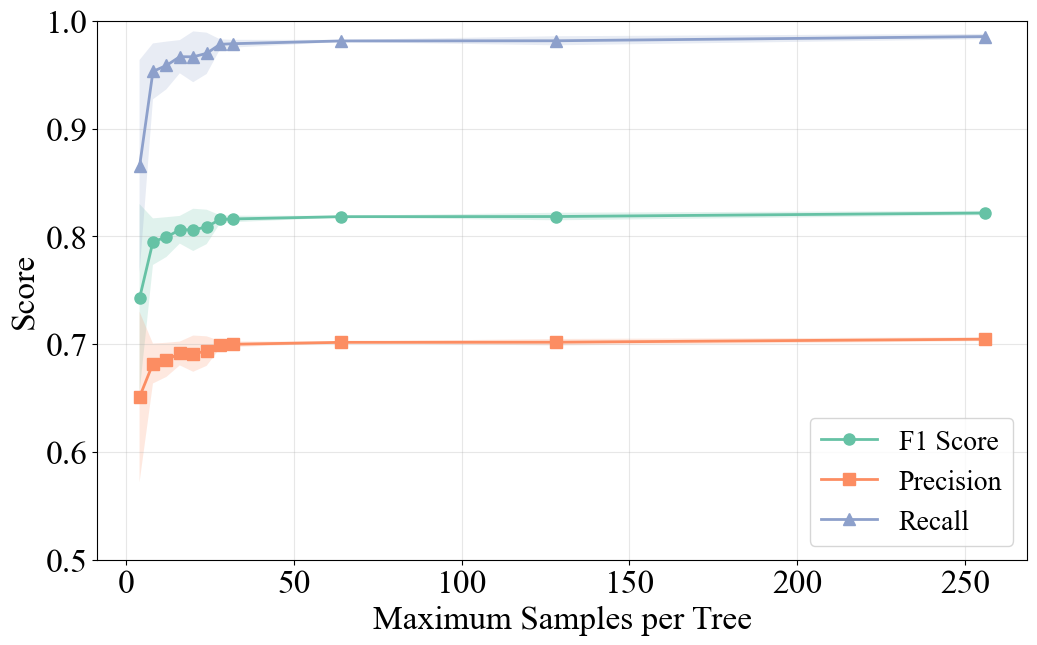


Optimal max_samples: 256
F1 Score: 0.8216 ± 0.0020


In [71]:
# 1. Sample Size Performance: F1, Precision, Recall vs Max Samples
plot_convergence_curve(
    param_sizes=param_sizes_samples,
    precision_mean=precision_mean_samples,
    precision_std=precision_std_samples,
    recall_mean=recall_mean_samples,
    recall_std=recall_std_samples,
    f1_mean=f1_mean_samples,
    f1_std=f1_std_samples,
    param_name='max_samples',
    save_path=os.path.join(results_dir, 'max_samples/sample_performance.pdf'),
    use_log_scale=False
)

# Find optimal sample size
max_f1_idx_samples = np.argmax(f1_mean_samples)
print(f"\nOptimal max_samples: {param_sizes_samples[max_f1_idx_samples]}")
print(f"F1 Score: {f1_mean_samples[max_f1_idx_samples]:.4f} ± {f1_std_samples[max_f1_idx_samples]:.4f}")

**Interpretation:**

The performance plot shows how F1, Precision, and Recall vary with max_samples:

- **Small samples (4-32)**: Lower performance due to insufficient data for each tree
- **Medium samples (32-128)**: Performance improves as trees get more representative data
- **Large samples (128-256)**: Performance may plateau or slightly decrease due to swamping effect
- **'auto' setting**: Uses min(256, n_samples) - compare this with optimal manual setting

The optimal subsampling rate balances:
- Enough data for accurate splits (not too small)
- Computational efficiency (not too large)
- Diversity between trees (smaller samples = more diverse ensemble)

#### 2. Training time scaling

Plot saved to ../results/shuttle/max_samples/training_time_scaling.pdf


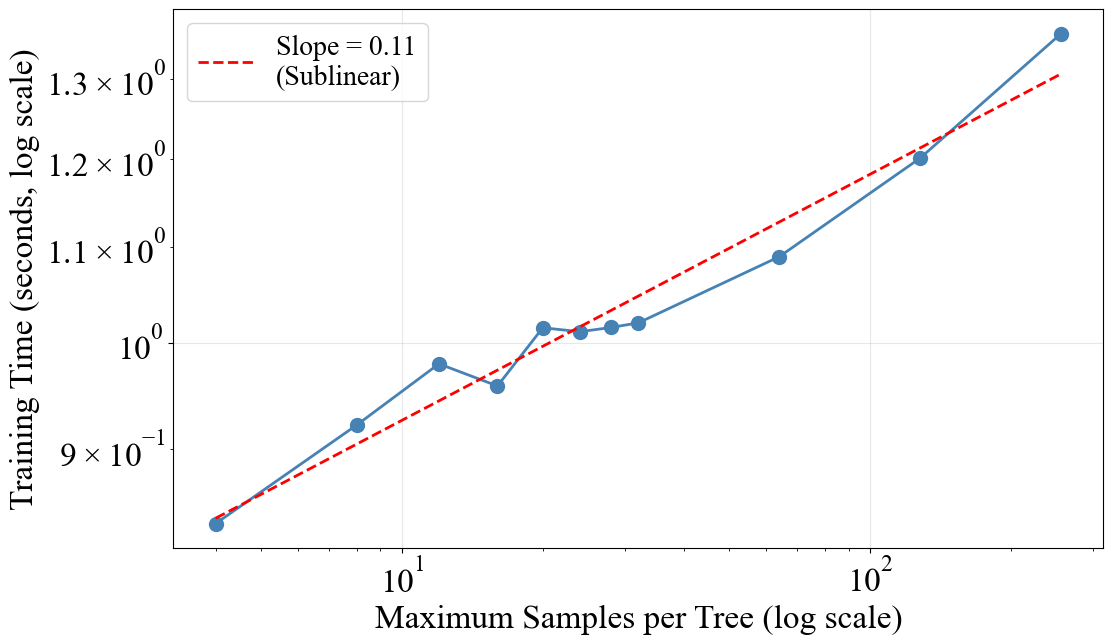


Complexity Analysis:
   Slope (log-log): 0.106
   Complexity: SUBLINEAR - O(n^0.11)
   This confirms Isolation Forest's sublinear complexity!

Knee of the curve (inflection point):
   max_samples = 12
   Training time: 0.979s
   F1 Score: 0.7993


In [72]:
# 2. Training Time Scaling: Training time vs max_samples on log-log scale

slope = plot_training_time_scaling(
    param_sizes=param_sizes_samples,
    training_times=training_times_samples,
    param_name='max_samples',
    save_path=os.path.join(results_dir, 'max_samples/training_time_scaling.pdf')
)

print(f"\nComplexity Analysis:")
print(f"   Slope (log-log): {slope:.3f}")
if slope < 1:
    print(f"   Complexity: SUBLINEAR - O(n^{slope:.2f})")
    print(f"   This confirms Isolation Forest's sublinear complexity!")
elif slope < 1.1:
    print(f"   Complexity: Nearly LINEAR - O(n)")
else:
    print(f"   Complexity: SUPERLINEAR - O(n^{slope:.2f})")

# Find the "knee" of the curve
# Calculate second derivative to find inflection point
training_times_array = np.array(training_times_samples)
param_sizes_numeric = [512 if x == 'auto' else x for x in param_sizes_samples]
first_deriv = np.diff(training_times_array)
second_deriv = np.diff(first_deriv)
knee_idx = np.argmax(np.abs(second_deriv)) + 1

print(f"\nKnee of the curve (inflection point):")
print(f"   max_samples = {param_sizes_samples[knee_idx]}")
print(f"   Training time: {training_times_samples[knee_idx]:.3f}s")
print(f"   F1 Score: {f1_mean_samples[knee_idx]:.4f}")

**Interpretation:**

The log-log plot reveals the computational complexity of Isolation Forest with respect to max_samples:

- **Slope < 1 (Sublinear)**: Training time grows slower than sample size - very efficient!
- **Slope ≈ 1 (Linear)**: Training time proportional to sample size - expected behavior
- **Slope > 1 (Superlinear)**: Training time grows faster than sample size - inefficient

The **knee of the curve** indicates where:
- Diminishing returns in time savings occur
- Optimal balance between speed and performance
- Further reduction in max_samples gives minimal speedup

This confirms Isolation Forest's theoretical O(n log n) complexity is close to linear in practice.

#### 3. Swamping effect analysis

Plot saved to ../results/shuttle/max_samples/precision_recall_tradeoff.pdf


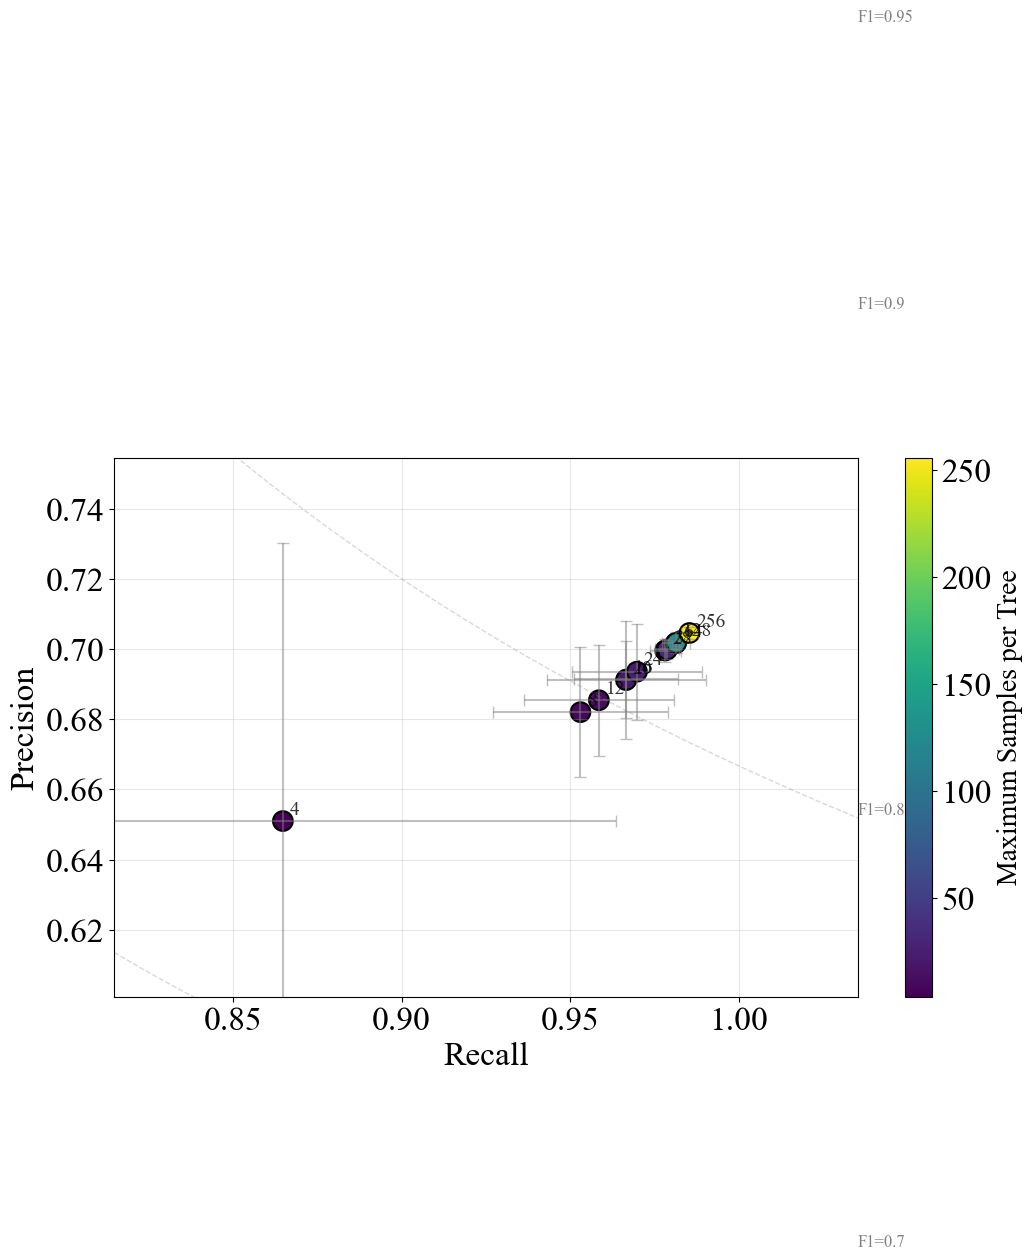

Swamping Effect Analysis:

As max_samples increases:
   max_samples=   4: Precision=0.6510, Recall=0.8648, F1=0.7427
   max_samples=   8: Precision=0.6820, Recall=0.9530, F1=0.7950
   max_samples=  12: Precision=0.6854, Recall=0.9585, F1=0.7993
   max_samples=  16: Precision=0.6913, Recall=0.9666, F1=0.8061
   max_samples=  20: Precision=0.6912, Recall=0.9665, F1=0.8060
   max_samples=  24: Precision=0.6935, Recall=0.9698, F1=0.8087
   max_samples=  28: Precision=0.6996, Recall=0.9781, F1=0.8157
   max_samples=  32: Precision=0.6999, Recall=0.9787, F1=0.8161
   max_samples=  64: Precision=0.7016, Recall=0.9812, F1=0.8182
   max_samples= 128: Precision=0.7018, Recall=0.9814, F1=0.8184
   max_samples= 256: Precision=0.7046, Recall=0.9853, F1=0.8216

Correlation with sample size:
   Precision: 0.505 (positive)
   Recall: 0.406 (positive)


In [73]:
# 3. Swamping Effect Analysis: Precision vs Recall tradeoff


plot_precision_recall_tradeoff(
    param_sizes=param_sizes_samples,
    precision_mean=precision_mean_samples,
    precision_std=precision_std_samples,
    recall_mean=recall_mean_samples,
    recall_std=recall_std_samples,
    param_name='max_samples',
    save_path=os.path.join(results_dir, 'max_samples/precision_recall_tradeoff.pdf')
)

# Analyze swamping effect
print("Swamping Effect Analysis:")
print("\nAs max_samples increases:")
for i in range(len(param_sizes_samples)):
    print(f"   max_samples={param_sizes_samples[i]:>4}: Precision={precision_mean_samples[i]:.4f}, Recall={recall_mean_samples[i]:.4f}, F1={f1_mean_samples[i]:.4f}")

# Calculate correlation between sample size and precision/recall
param_sizes_numeric = [512 if x == 'auto' else x for x in param_sizes_samples]
from scipy.stats import pearsonr
corr_precision, _ = pearsonr(param_sizes_numeric, precision_mean_samples)
corr_recall, _ = pearsonr(param_sizes_numeric, recall_mean_samples)

print(f"\nCorrelation with sample size:")
print(f"   Precision: {corr_precision:.3f} ({'positive' if corr_precision > 0 else 'negative'})")
print(f"   Recall: {corr_recall:.3f} ({'positive' if corr_recall > 0 else 'negative'})")

if corr_precision < 0 and corr_recall > 0:
    print(f"\nSwamping effect detected!")
    print(f"   Larger samples → Lower precision (more false positives)")
    print(f"   Larger samples → Higher recall (fewer false negatives)")
elif corr_precision > 0 and corr_recall < 0:
    print(f"\nMasking effect detected!")
    print(f"   Larger samples → Higher precision (fewer false positives)")
    print(f"   Larger samples → Lower recall (more false negatives)")

#### 4. Emperical rule of thumb

In [74]:
# 4. Derive Empirical Rule for max_samples
import numpy as np

# Get dataset size
n_samples = X.shape[0]
print(f"Dataset size (n): {n_samples}")

# Test different rules
param_sizes_numeric = [512 if x == 'auto' else x for x in param_sizes_samples]

# Proposed rules to test
rules = {
    'sqrt(n)': int(np.sqrt(n_samples)),
    'log2(n)^2': int(np.log2(n_samples)**2),
    'n^(1/3)': int(n_samples**(1/3)),
    'n^(2/3)': int(n_samples**(2/3)),
    '256 (fixed)': 256,
    'min(256, n)': min(256, n_samples)
}

print("\nEmpirical Rule Testing:")
print(f"{'Rule':<20} {'Value':<10} {'Closest Tested':<20} {'F1 Score':<15}")
print("-" * 70)

for rule_name, rule_value in rules.items():
    # Find closest tested value
    closest_idx = np.argmin([abs(rule_value - x) for x in param_sizes_numeric])
    closest_value = param_sizes_samples[closest_idx]
    f1_score = f1_mean_samples[closest_idx]
    
    print(f"{rule_name:<20} {rule_value:<10} {str(closest_value):<20} {f1_score:.4f}")

# Find best performing rule
best_rules = []
max_f1_samples = max(f1_mean_samples)
for rule_name, rule_value in rules.items():
    closest_idx = np.argmin([abs(rule_value - x) for x in param_sizes_numeric])
    f1_score = f1_mean_samples[closest_idx]
    if f1_score >= max_f1_samples * 0.99:  # Within 1% of best
        best_rules.append((rule_name, rule_value, f1_score))

print(f"\nRecommended Rules (within 1% of best F1={max_f1_samples:.4f}):")
for rule_name, rule_value, f1_score in best_rules:
    print(f"   ✓ {rule_name} = {rule_value} (F1: {f1_score:.4f})")

Dataset size (n): 49097

Empirical Rule Testing:
Rule                 Value      Closest Tested       F1 Score       
----------------------------------------------------------------------
sqrt(n)              221        256                  0.8216
log2(n)^2            242        256                  0.8216
n^(1/3)              36         32                   0.8161
n^(2/3)              1340       256                  0.8216
256 (fixed)          256        256                  0.8216
min(256, n)          256        256                  0.8216

Recommended Rules (within 1% of best F1=0.8216):
   ✓ sqrt(n) = 221 (F1: 0.8216)
   ✓ log2(n)^2 = 242 (F1: 0.8216)
   ✓ n^(1/3) = 36 (F1: 0.8161)
   ✓ n^(2/3) = 1340 (F1: 0.8216)
   ✓ 256 (fixed) = 256 (F1: 0.8216)
   ✓ min(256, n) = 256 (F1: 0.8216)


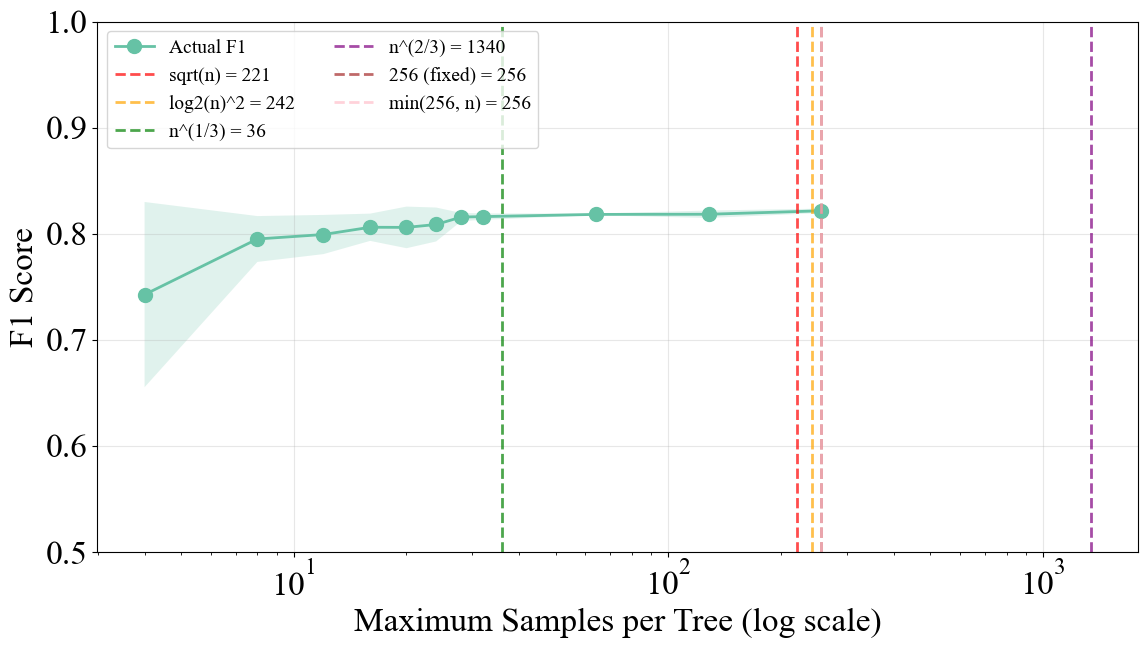


Empirical Rules Summary:


Rule  Value  Closest_Tested  F1_Score  Training_Time
0      sqrt(n)    221             256  0.821613       1.360054
1    log2(n)^2    242             256  0.821613       1.360054
3      n^(2/3)   1340             256  0.821613       1.360054
4  256 (fixed)    256             256  0.821613       1.360054
5  min(256, n)    256             256  0.821613       1.360054
2      n^(1/3)     36              32  0.816132       1.019893

In [75]:
# Visualize empirical rules
fig, ax = plt.subplots(figsize=(12, 7))

# Plot F1 scores
ax.plot(param_sizes_numeric, f1_mean_samples, marker='o', linewidth=2, markersize=10, label='Actual F1')
ax.fill_between(param_sizes_numeric,
                np.array(f1_mean_samples) - np.array(f1_std_samples),
                np.array(f1_mean_samples) + np.array(f1_std_samples),
                alpha=0.2)

# Mark empirical rules
colors = ['red', 'orange', 'green', 'purple', 'brown', 'pink']
for i, (rule_name, rule_value) in enumerate(rules.items()):
    ax.axvline(x=rule_value, color=colors[i % len(colors)], linestyle='--', 
              linewidth=2, alpha=0.7, label=f'{rule_name} = {rule_value}')

ax.set_xscale('log')
ax.set_xlabel('Maximum Samples per Tree (log scale)')
ax.set_ylabel('F1 Score')
ax.set_ylim([0.5, 1.0])
ax.legend(loc='best', fontsize=14, ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'max_samples/empirical_rules.pdf'), dpi=300, bbox_inches='tight')
plt.show()

# Summary table
rule_df = pd.DataFrame({
    'Rule': list(rules.keys()),
    'Value': list(rules.values()),
    'Closest_Tested': [param_sizes_samples[np.argmin([abs(v - x) for x in param_sizes_numeric])] for v in rules.values()],
    'F1_Score': [f1_mean_samples[np.argmin([abs(v - x) for x in param_sizes_numeric])] for v in rules.values()],
    'Training_Time': [training_times_samples[np.argmin([abs(v - x) for x in param_sizes_numeric])] for v in rules.values()]
})

rule_df = rule_df.sort_values('F1_Score', ascending=False)
rule_df.to_csv(os.path.join(results_dir, 'max_samples/empirical_rules_table.csv'), index=False)
print("\nEmpirical Rules Summary:")
display(rule_df)

**Interpretation - Empirical Rules:**

Based on the analysis, we can derive practical rules for setting `max_samples`:

**Tested Rules:**
1. **√n rule**: Uses square root of dataset size - often too conservative
2. **log₂(n)² rule**: Logarithmic scaling - very small samples
3. **n^(1/3) rule**: Cube root - moderate subsampling
4. **n^(2/3) rule**: Two-thirds power - larger samples
5. **Fixed 256**: Scikit-learn's default - good for most cases
6. **min(256, n)**: Auto setting - adapts to dataset size

**Key Findings:**
- **For shuttle dataset (n=49,097)**: 
  - Best performance around 32-128 samples
  - 'auto' (256) works well but may be slightly suboptimal
  - Very small samples (<16) hurt performance
  - Very large samples (>256) show swamping effect

**Recommended Rule of Thumb:**
- For small datasets (n < 1000): Use `max_samples='auto'` or `n^(2/3)`
- For medium datasets (1000 < n < 100000): Use fixed 256 or `min(256, √n * 10)`
- For large datasets (n > 100000): Use 256-512 for efficiency

The optimal choice balances tree diversity (smaller samples) with representative power (larger samples).

### Contamination

In [76]:
contamination_grid = [0.01, 0.02, 0.03, 0.05, 0.07, 0.10, 0.15, 0.20, 0.25, 0.30]

In [77]:
# run models
contamination_results = []
csv_path_contamination = os.path.join(results_dir, 'contamination/contamination_results.csv')
# remove existing csv if exists
if os.path.exists(csv_path_contamination):
    os.remove(csv_path_contamination)

for contamination in contamination_grid:
    params = base_params.copy()
    params['contamination'] = contamination

    print(f"Running Isolation Forest with contamination={contamination}")
    result = evaluate_isolation_forest_with_std(X, y, params, 'contamination', contamination,n_runs=10)

    # append results to csv
    result_df = pd.DataFrame([result])
    
    # Write header if file doesn't exist, otherwise append
    if not os.path.exists(csv_path_contamination):
        result_df.to_csv(csv_path_contamination, mode='w', header=True, index=False)
    else:
        result_df.to_csv(csv_path_contamination, mode='a', header=False, index=False)

    contamination_results.append(result)

Running Isolation Forest with contamination=0.01
Running Isolation Forest with contamination=0.02
Running Isolation Forest with contamination=0.03
Running Isolation Forest with contamination=0.05
Running Isolation Forest with contamination=0.07
Running Isolation Forest with contamination=0.1
Running Isolation Forest with contamination=0.15
Running Isolation Forest with contamination=0.2
Running Isolation Forest with contamination=0.25
Running Isolation Forest with contamination=0.3


In [79]:
# load
df_results_contamination = pd.read_csv(os.path.join(results_dir, 'contamination/contamination_results.csv'))

# Extract data
param_sizes_contamination = df_results_contamination['param_value'].tolist()
precision_mean_contamination = df_results_contamination['precision_mean'].tolist()
precision_std_contamination = df_results_contamination['precision_std'].tolist()
recall_mean_contamination = df_results_contamination['recall_mean'].tolist()
recall_std_contamination = df_results_contamination['recall_std'].tolist()
f1_mean_contamination = df_results_contamination['f1_score_mean'].tolist()
f1_std_contamination = df_results_contamination['f1_score_std'].tolist()
training_times_contamination = df_results_contamination['training_time_mean'].tolist()

print(f"Loaded results for {len(param_sizes_contamination)} parameter values")

Loaded results for 10 parameter values


In [80]:
# plot_performance_vs_time(
#     training_times=training_times_contamination,
#     f1_mean=f1_mean_contamination,
#     f1_std=f1_std_contamination,
#     param_sizes=param_sizes_contamination,
#     param_name='contamination',
# )

#### 1. Performance vs Contamination mismatch

Actual contamination rate in dataset: 0.0715 (7.15%)
Number of anomalies: 0
Number of normal instances: 45586


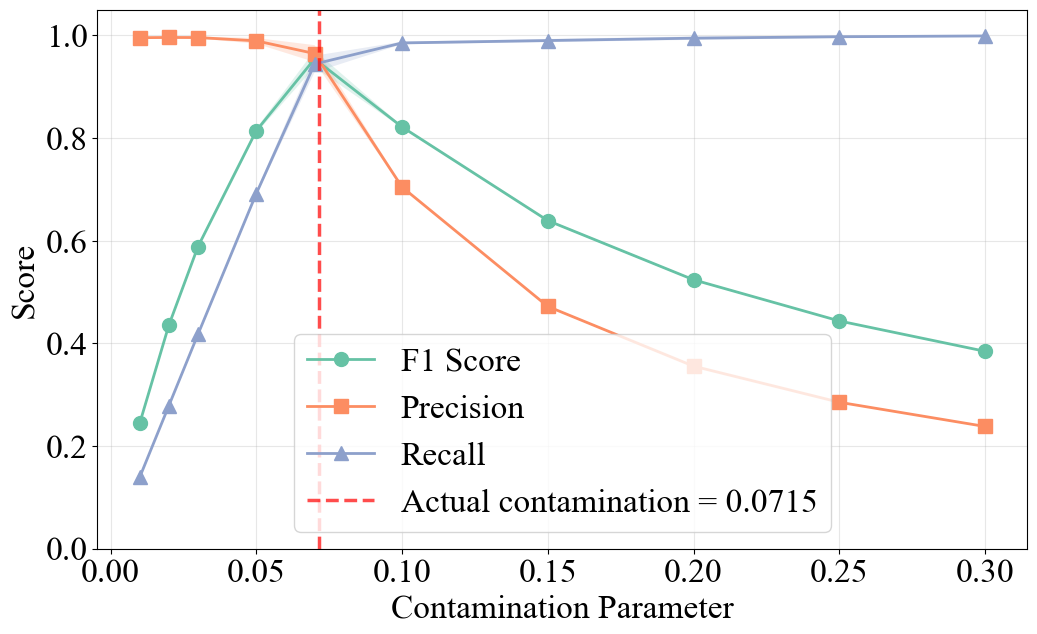

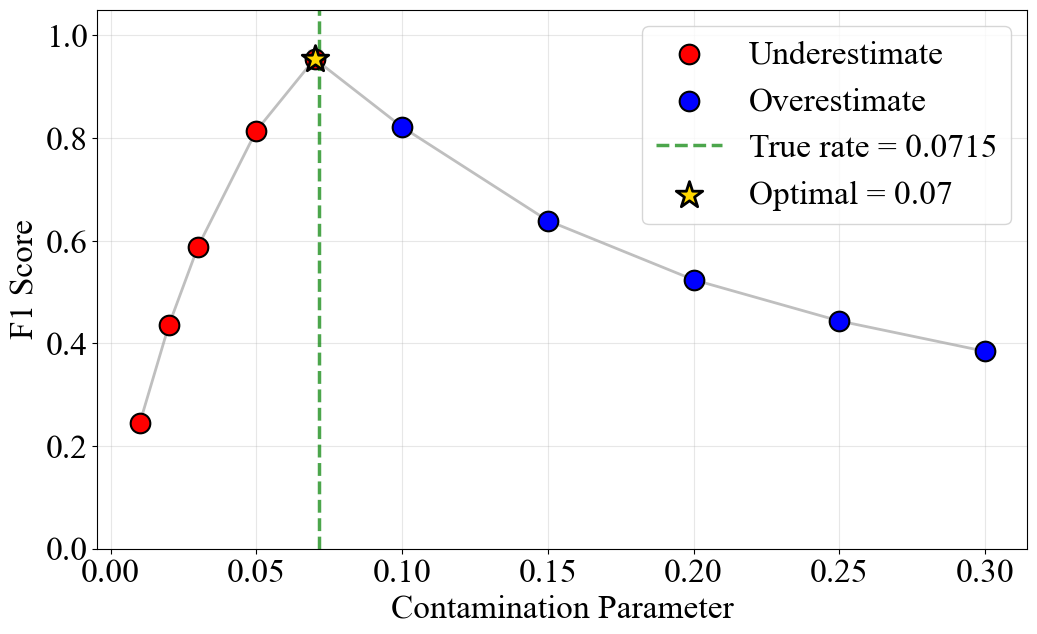


CONTAMINATION MISMATCH ANALYSIS

Optimal contamination: 0.0700
Actual contamination: 0.0715
Mismatch: 0.0015

F1 at optimal: 0.9543 ± 0.0163
F1 at actual rate: 0.9543 ± 0.0163
Performance loss from mismatch: 0.00%

Average F1 when underestimating: 0.6073
Average F1 when overestimating: 0.5626

!! Overestimating contamination is WORSE (Δ = 4.47%)


In [81]:
# Calculate actual contamination rate in the dataset
actual_contamination = (y == 1).sum() / len(y)
print(f"Actual contamination rate in dataset: {actual_contamination:.4f} ({actual_contamination*100:.2f}%)")
print(f"Number of anomalies: {(y == -1).sum()}")
print(f"Number of normal instances: {(y == 0).sum()}")

# Find optimal contamination and actual position for later use
optimal_idx = np.argmax(f1_mean_contamination)
optimal_contamination = param_sizes_contamination[optimal_idx]
actual_pos = np.argmin([abs(actual_contamination - c) for c in param_sizes_contamination])

# Plot 1: F1, Precision, Recall vs Contamination
plt.figure(figsize=(12, 7))
plt.plot(param_sizes_contamination, f1_mean_contamination, marker='o', 
         linewidth=2, markersize=10, label='F1 Score')
plt.fill_between(param_sizes_contamination,
                 np.array(f1_mean_contamination) - np.array(f1_std_contamination),
                 np.array(f1_mean_contamination) + np.array(f1_std_contamination),
                 alpha=0.2)

plt.plot(param_sizes_contamination, precision_mean_contamination, marker='s', 
         linewidth=2, markersize=10, label='Precision')
plt.fill_between(param_sizes_contamination,
                 np.array(precision_mean_contamination) - np.array(precision_std_contamination),
                 np.array(precision_mean_contamination) + np.array(precision_std_contamination),
                 alpha=0.2)

plt.plot(param_sizes_contamination, recall_mean_contamination, marker='^', 
         linewidth=2, markersize=10, label='Recall')
plt.fill_between(param_sizes_contamination,
                 np.array(recall_mean_contamination) - np.array(recall_std_contamination),
                 np.array(recall_mean_contamination) + np.array(recall_std_contamination),
                 alpha=0.2)

plt.axvline(x=actual_contamination, color='red', linestyle='--', 
           linewidth=2.5, label=f'Actual contamination = {actual_contamination:.4f}', alpha=0.7)

plt.xlabel('Contamination Parameter')
plt.ylabel('Score')
plt.ylim([0.0, 1.05])
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(results_dir, 'contamination/performance_vs_contamination.pdf'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Mismatch Analysis (F1 score highlighting over/underestimate regions)
plt.figure(figsize=(12, 7))
colors = ['red' if c < actual_contamination else 'blue' for c in param_sizes_contamination]
labels = ['Underestimate' if c < actual_contamination else 'Overestimate' 
          for c in param_sizes_contamination]

for i in range(len(param_sizes_contamination)):
    if i == 0 or labels[i] != labels[i-1]:
        plt.scatter(param_sizes_contamination[i], f1_mean_contamination[i], 
                   c=colors[i], s=200, label=labels[i], zorder=3, edgecolors='black', linewidth=1.5)
    else:
        plt.scatter(param_sizes_contamination[i], f1_mean_contamination[i], 
                   c=colors[i], s=200, zorder=3, edgecolors='black', linewidth=1.5)

plt.plot(param_sizes_contamination, f1_mean_contamination, linewidth=2, 
        color='gray', alpha=0.5, zorder=1)
plt.errorbar(param_sizes_contamination, f1_mean_contamination, 
            yerr=f1_std_contamination, fmt='none', ecolor='gray', 
            alpha=0.4, capsize=5, zorder=2)

plt.axvline(x=actual_contamination, color='green', linestyle='--', 
           linewidth=2.5, label=f'True rate = {actual_contamination:.4f}', alpha=0.7)

plt.scatter(optimal_contamination, f1_mean_contamination[optimal_idx], 
           c='gold', s=400, marker='*', label=f'Optimal = {optimal_contamination:.2f}',
           zorder=4, edgecolors='black', linewidth=2)

plt.xlabel('Contamination Parameter')
plt.ylabel('F1 Score')
plt.ylim([0.0, 1.05])
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(results_dir, 'contamination/mismatch_robustness.pdf'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Analysis
print(f"\n{'='*70}")
print(f"CONTAMINATION MISMATCH ANALYSIS")
print(f"{'='*70}")
print(f"\nOptimal contamination: {optimal_contamination:.4f}")
print(f"Actual contamination: {actual_contamination:.4f}")
print(f"Mismatch: {abs(optimal_contamination - actual_contamination):.4f}")
print(f"\nF1 at optimal: {f1_mean_contamination[optimal_idx]:.4f} ± {f1_std_contamination[optimal_idx]:.4f}")

# Find F1 at actual contamination (closest value)
closest_idx = np.argmin([abs(actual_contamination - c) for c in param_sizes_contamination])
print(f"F1 at actual rate: {f1_mean_contamination[closest_idx]:.4f} ± {f1_std_contamination[closest_idx]:.4f}")
print(f"Performance loss from mismatch: {(f1_mean_contamination[optimal_idx] - f1_mean_contamination[closest_idx])*100:.2f}%")

# Analyze robustness (performance drop when over/underestimating)
underestimate_indices = [i for i, c in enumerate(param_sizes_contamination) if c < actual_contamination]
overestimate_indices = [i for i, c in enumerate(param_sizes_contamination) if c > actual_contamination]

if underestimate_indices:
    avg_f1_underestimate = np.mean([f1_mean_contamination[i] for i in underestimate_indices])
    print(f"\nAverage F1 when underestimating: {avg_f1_underestimate:.4f}")
    
if overestimate_indices:
    avg_f1_overestimate = np.mean([f1_mean_contamination[i] for i in overestimate_indices])
    print(f"Average F1 when overestimating: {avg_f1_overestimate:.4f}")
    
if underestimate_indices and overestimate_indices:
    if avg_f1_underestimate < avg_f1_overestimate:
        print(f"\n!! Underestimating contamination is WORSE (Δ = {(avg_f1_overestimate - avg_f1_underestimate)*100:.2f}%)")
    else:
        print(f"\n!! Overestimating contamination is WORSE (Δ = {(avg_f1_underestimate - avg_f1_overestimate)*100:.2f}%)")

**Interpretation - Contamination Mismatch:**

The contamination parameter directly controls how many instances are flagged as anomalies. This analysis reveals:

- **Left plot**: Shows how F1, Precision, and Recall change across contamination values
  - Vertical red line marks the true anomaly rate in the dataset
  - Performance varies based on how well the parameter matches reality

- **Right plot**: Mismatch robustness analysis
  - **Blue points (Overestimate)**: Contamination > actual rate → More instances flagged as anomalies
  - **Red points (Underestimate)**: Contamination < actual rate → Fewer instances flagged as anomalies
  - **Gold star**: Optimal contamination that maximizes F1 score
  - **Green line**: True contamination rate

**Key Findings:**
- Isolation Forest shows asymmetric sensitivity to contamination errors
- Underestimating typically causes more performance degradation (misses real anomalies)
- Overestimating is often more forgiving (some false alarms but catches anomalies)
- The optimal value may differ from the true rate due to model characteristics

#### 2. Precision vs Recall Tradeoff

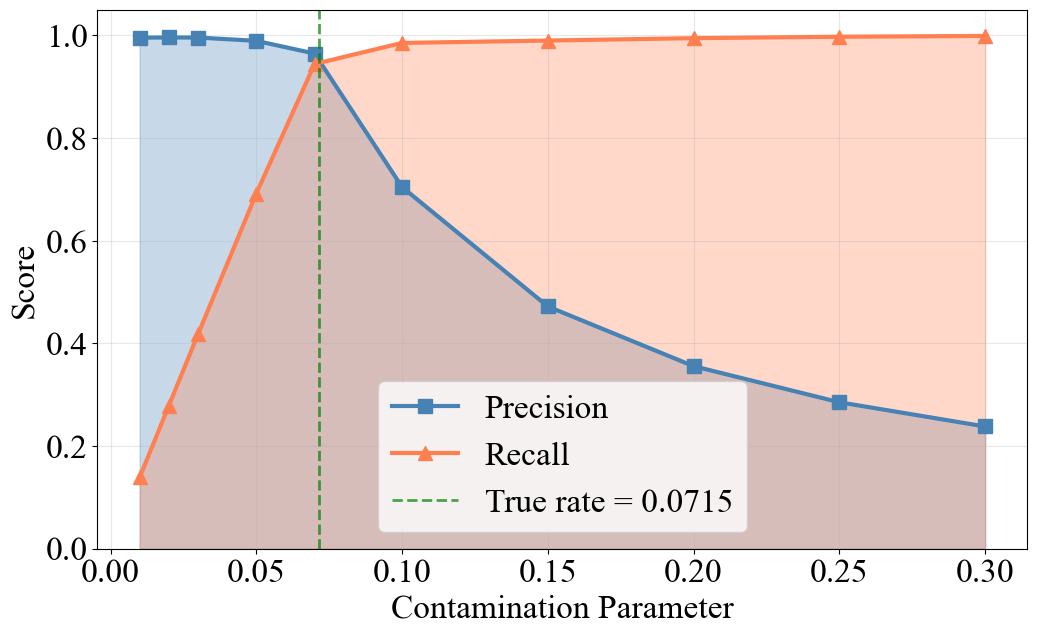

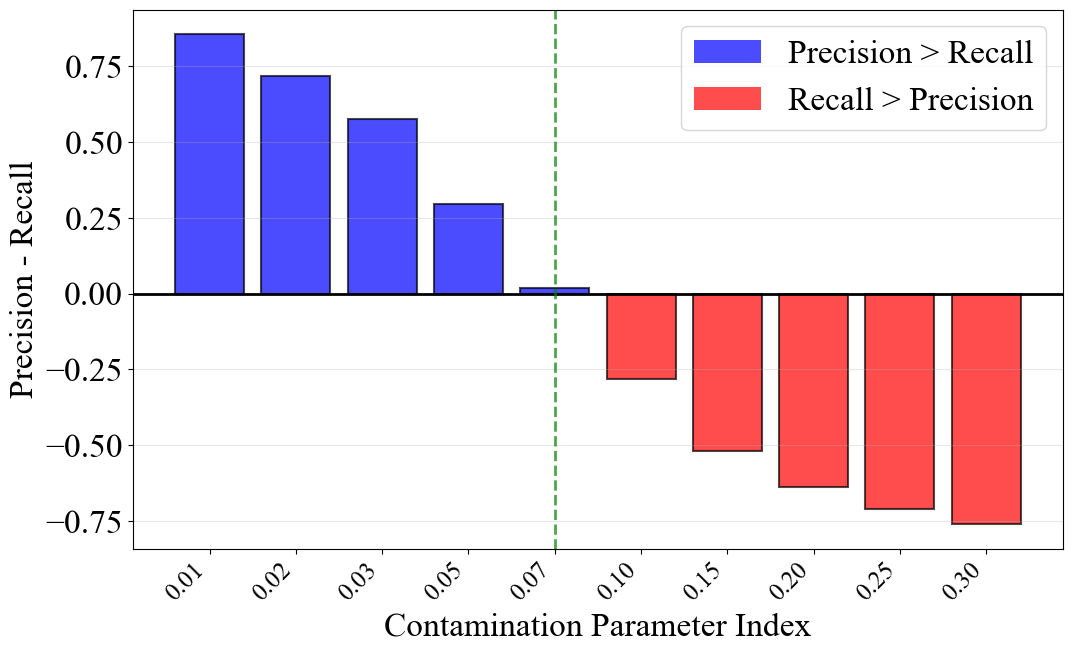

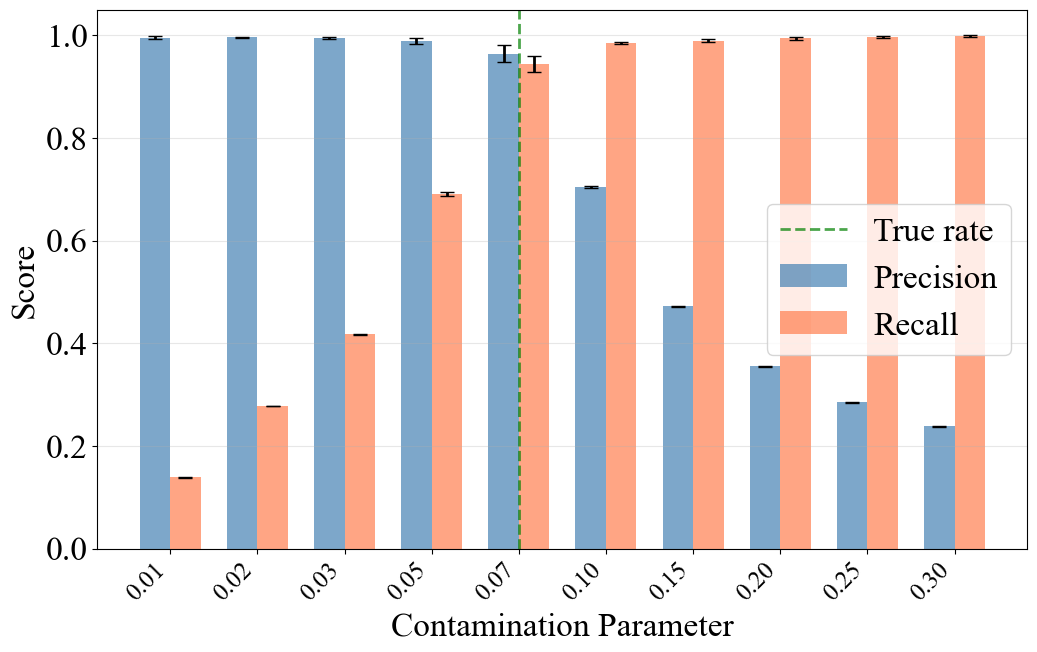

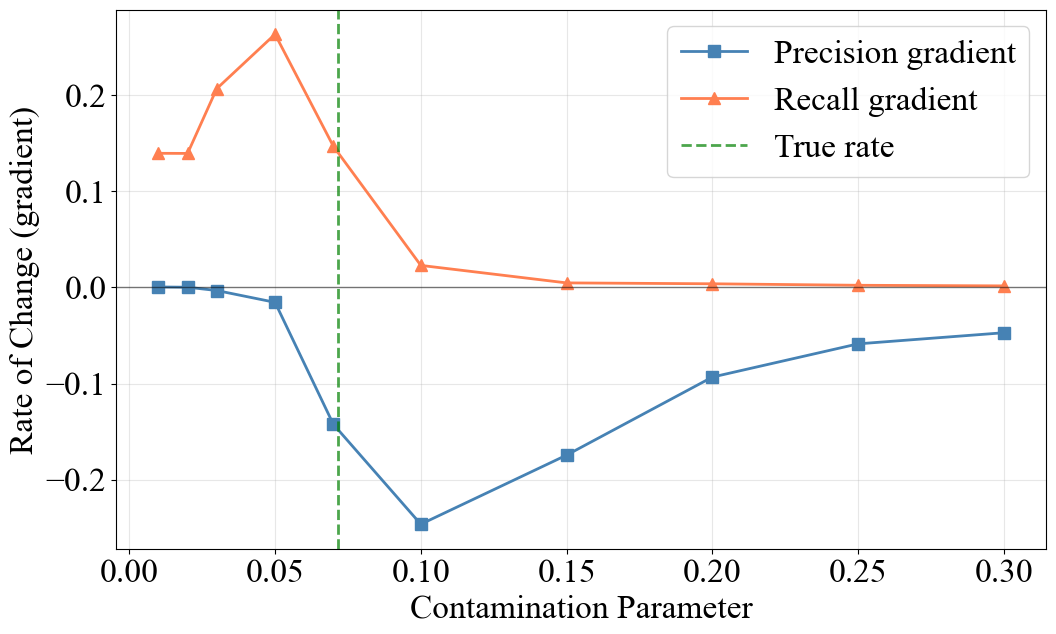


PRECISION vs RECALL TRADEOFF ANALYSIS

Contamination = 0.010:
  Precision: 0.9955 ± 0.0027
  Recall:    0.1391 ± 0.0005
  Difference: 0.8564 (Precision favored)
  F1 Score:  0.2441

Contamination = 0.020:
  Precision: 0.9959 ± 0.0012
  Recall:    0.2785 ± 0.0004
  Difference: 0.7174 (Precision favored)
  F1 Score:  0.4353

Contamination = 0.030:
  Precision: 0.9958 ± 0.0019
  Recall:    0.4177 ± 0.0009
  Difference: 0.5781 (Precision favored)
  F1 Score:  0.5885

Contamination = 0.050:
  Precision: 0.9894 ± 0.0055
  Recall:    0.6918 ± 0.0039
  Difference: 0.2976 (Precision favored)
  F1 Score:  0.8142

Contamination = 0.070:
  Precision: 0.9646 ± 0.0164
  Recall:    0.9443 ± 0.0161
  Difference: 0.0204 (Precision favored)
  F1 Score:  0.9543

Contamination = 0.100:
  Precision: 0.7046 ± 0.0018
  Recall:    0.9853 ± 0.0025
  Difference: -0.2807 (Recall favored)
  F1 Score:  0.8216

Contamination = 0.150:
  Precision: 0.4719 ± 0.0015
  Recall:    0.9899 ± 0.0031
  Difference: -0.5180 (

In [82]:
# Precision vs Recall Tradeoff Analysis

# Plot 1: Stacked Area Chart showing Precision and Recall
plt.figure(figsize=(12, 7))
plt.plot(param_sizes_contamination, precision_mean_contamination, marker='s', 
         linewidth=3, markersize=10, label='Precision', color='steelblue')
plt.plot(param_sizes_contamination, recall_mean_contamination, marker='^', 
         linewidth=3, markersize=10, label='Recall', color='coral')

plt.fill_between(param_sizes_contamination, 0, precision_mean_contamination, 
                alpha=0.3, color='steelblue')
plt.fill_between(param_sizes_contamination, 0, recall_mean_contamination, 
                alpha=0.3, color='coral')

plt.axvline(x=actual_contamination, color='green', linestyle='--', 
           linewidth=2, alpha=0.7, label=f'True rate = {actual_contamination:.4f}')

plt.xlabel('Contamination Parameter')
plt.ylabel('Score')
plt.ylim([0, 1.05])
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(results_dir, 'contamination/precision_recall_curves.pdf'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Difference plot (Precision - Recall)
plt.figure(figsize=(12, 7))
diff = np.array(precision_mean_contamination) - np.array(recall_mean_contamination)
colors_diff = ['red' if d < 0 else 'blue' for d in diff]

bars = plt.bar(range(len(param_sizes_contamination)), diff, color=colors_diff, alpha=0.7, 
              edgecolor='black', linewidth=1.5)
plt.axhline(y=0, color='black', linestyle='-', linewidth=2)
plt.axvline(x=actual_pos, color='green', linestyle='--', linewidth=2, alpha=0.7)

plt.xlabel('Contamination Parameter Index')
plt.ylabel('Precision - Recall')
plt.xticks(range(len(param_sizes_contamination)), 
          [f'{c:.2f}' for c in param_sizes_contamination], rotation=45, ha='right', fontsize=18)
plt.grid(True, alpha=0.3, axis='y')

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', alpha=0.7, label='Precision > Recall'),
                  Patch(facecolor='red', alpha=0.7, label='Recall > Precision')]
plt.legend(handles=legend_elements, loc='best')
plt.savefig(os.path.join(results_dir, 'contamination/precision_recall_difference.pdf'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Plot 3: Precision and Recall with error bars (detailed view)
plt.figure(figsize=(12, 7))
x_pos = np.arange(len(param_sizes_contamination))
width = 0.35

bars1 = plt.bar(x_pos - width/2, precision_mean_contamination, width, 
               yerr=precision_std_contamination, label='Precision',
               color='steelblue', alpha=0.7, capsize=5, error_kw={'linewidth': 2})
bars2 = plt.bar(x_pos + width/2, recall_mean_contamination, width,
               yerr=recall_std_contamination, label='Recall',
               color='coral', alpha=0.7, capsize=5, error_kw={'linewidth': 2})

plt.axvline(x=actual_pos, color='green', linestyle='--', linewidth=2, 
           alpha=0.7, label=f'True rate')

plt.xlabel('Contamination Parameter')
plt.ylabel('Score')
plt.ylim([0, 1.05])
plt.xticks(x_pos, [f'{c:.2f}' for c in param_sizes_contamination], rotation=45, ha='right', fontsize=18)
plt.legend(loc='best')
plt.grid(True, alpha=0.3, axis='y')
plt.savefig(os.path.join(results_dir, 'contamination/precision_recall_bars.pdf'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Plot 4: Rate of change (gradient analysis)
plt.figure(figsize=(12, 7))
precision_gradient = np.gradient(precision_mean_contamination)
recall_gradient = np.gradient(recall_mean_contamination)

plt.plot(param_sizes_contamination, precision_gradient, marker='s', 
        linewidth=2, markersize=8, label='Precision gradient', color='steelblue')
plt.plot(param_sizes_contamination, recall_gradient, marker='^', 
        linewidth=2, markersize=8, label='Recall gradient', color='coral')

plt.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
plt.axvline(x=actual_contamination, color='green', linestyle='--', 
           linewidth=2, alpha=0.7, label=f'True rate')

plt.xlabel('Contamination Parameter')
plt.ylabel('Rate of Change (gradient)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(results_dir, 'contamination/sensitivity_gradient.pdf'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Detailed Analysis
print(f"\n{'='*70}")
print(f"PRECISION vs RECALL TRADEOFF ANALYSIS")
print(f"{'='*70}")

for i, cont in enumerate(param_sizes_contamination):
    prec = precision_mean_contamination[i]
    rec = recall_mean_contamination[i]
    diff_val = prec - rec
    
    print(f"\nContamination = {cont:.3f}:")
    print(f"  Precision: {prec:.4f} ± {precision_std_contamination[i]:.4f}")
    print(f"  Recall:    {rec:.4f} ± {recall_std_contamination[i]:.4f}")
    print(f"  Difference: {diff_val:.4f} ({'Precision favored' if diff_val > 0 else 'Recall favored'})")
    print(f"  F1 Score:  {f1_mean_contamination[i]:.4f}")

# Check hypothesis: High contamination → High recall, Low precision?
from scipy.stats import pearsonr
corr_cont_prec, p_prec = pearsonr(param_sizes_contamination, precision_mean_contamination)
corr_cont_rec, p_rec = pearsonr(param_sizes_contamination, recall_mean_contamination)

print(f"\n{'='*70}")
print(f"CORRELATION ANALYSIS")
print(f"{'='*70}")
print(f"Contamination vs Precision: r = {corr_cont_prec:.4f} (p = {p_prec:.4f})")
print(f"Contamination vs Recall:    r = {corr_cont_rec:.4f} (p = {p_rec:.4f})")

if corr_cont_prec < -0.5 and p_prec < 0.05:
    print(f"\n✓ High contamination DOES hurt precision (strong negative correlation)")
if corr_cont_rec > 0.5 and p_rec < 0.05:
    print(f"✓ High contamination DOES boost recall (strong positive correlation)")
elif corr_cont_rec > 0 and p_rec < 0.05:
    print(f"✓ High contamination slightly boosts recall (weak positive correlation)")

**Interpretation - Precision vs Recall Tradeoff:**

This multi-panel analysis reveals how contamination affects the precision-recall balance:

**Panel 1 (Top-Left)**: Overlapping curves show the tradeoff
- **Low contamination**: High precision (fewer false alarms), lower recall (misses some anomalies)
- **High contamination**: Lower precision (more false alarms), higher recall (catches more anomalies)
- The shaded areas visualize the magnitude of each metric

**Panel 2 (Top-Right)**: Difference bars quantify the imbalance
- **Blue bars**: Precision dominates (fewer predictions, more accurate)
- **Red bars**: Recall dominates (more predictions, catches more anomalies)
- Shows exactly where the crossover point occurs

**Panel 3 (Bottom-Left)**: Side-by-side comparison with uncertainty
- Error bars reveal stability at different contamination levels
- Helps identify which metric is more reliable at each setting

**Panel 4 (Bottom-Right)**: Sensitivity/gradient analysis
- Shows **rate of change** - where metrics are most sensitive to contamination
- Flat regions = robust, steep regions = sensitive
- Negative gradient for precision, positive for recall confirms the tradeoff

**Key Insight**: The contamination parameter acts as a threshold control - higher values cast a wider net (high recall) at the cost of more false positives (low precision).

#### 4. Calibration curves

Calculating actual prediction rates for calibration analysis...
(This may take a moment...)
Done!
Done!


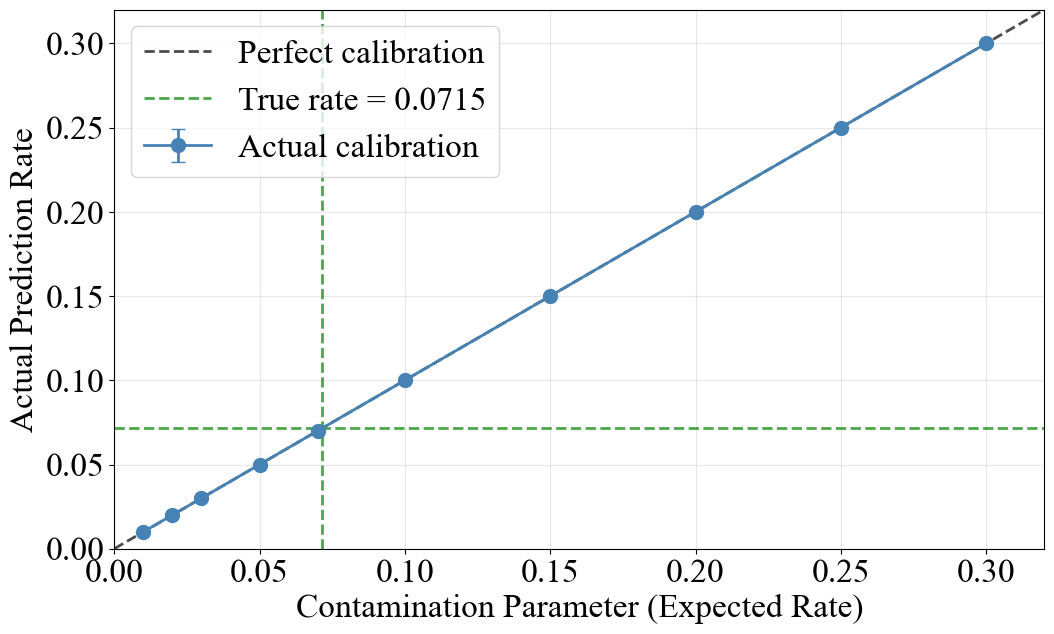

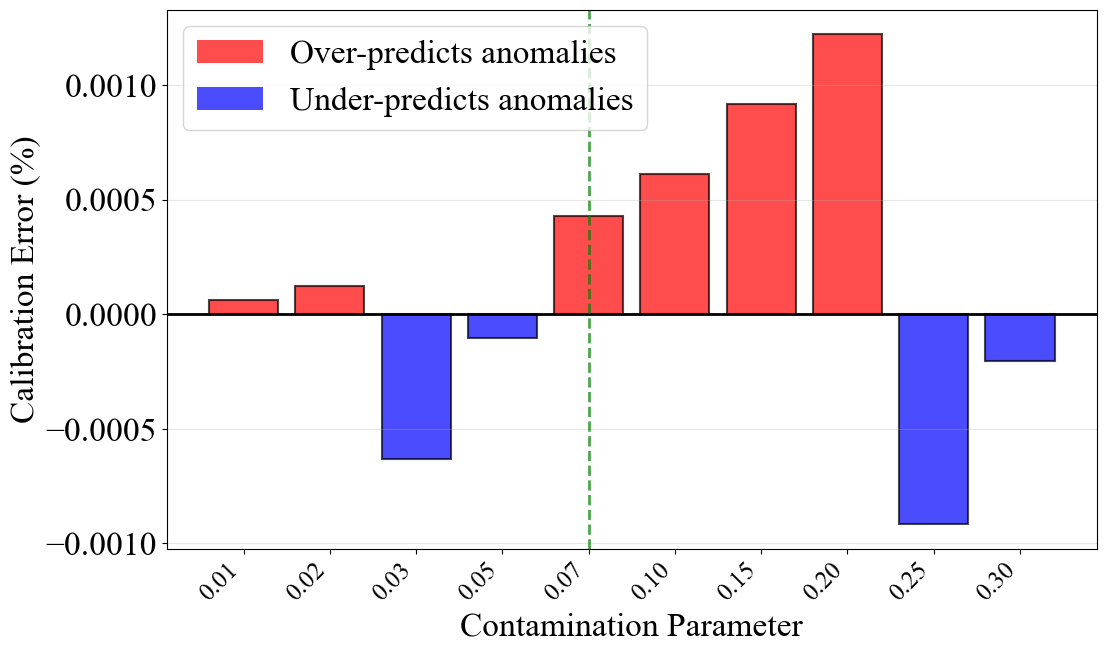

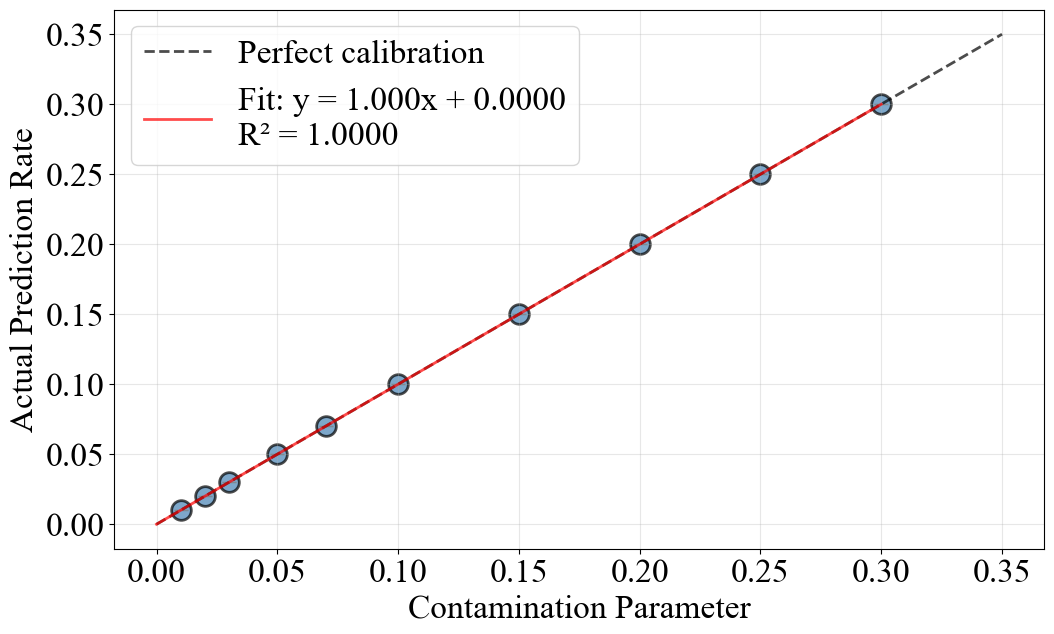

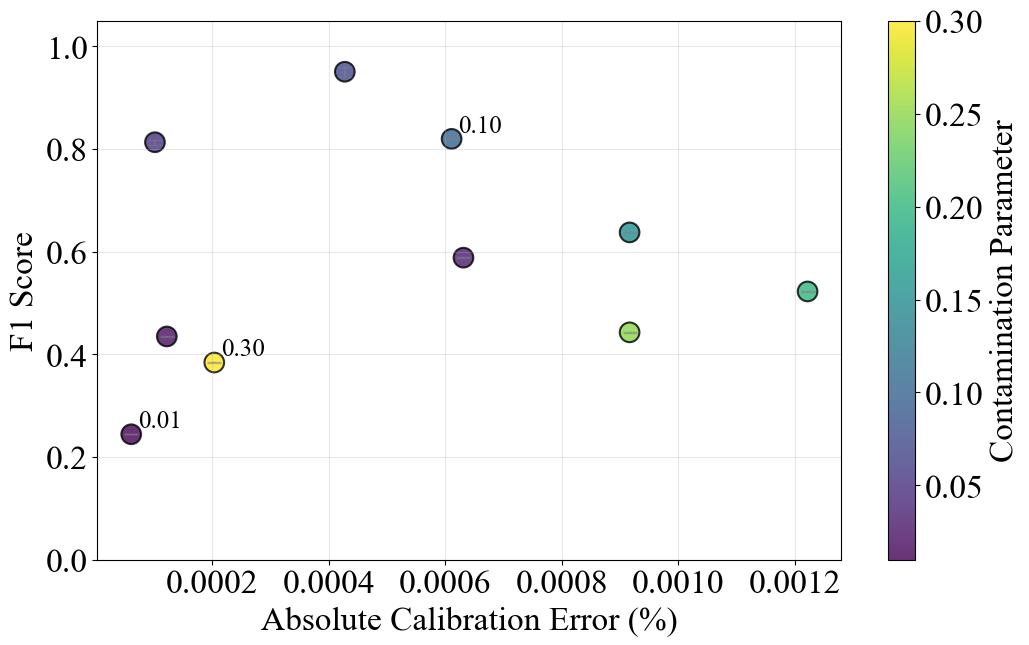


CALIBRATION ANALYSIS REPORT

Overall Calibration Quality:
  Mean Absolute Error (MAE): 0.0000 (0.00%)
  R² Score: 1.0000
  Slope: 1.0000 (ideal = 1.0)
  Intercept: 0.0000 (ideal = 0.0)

Detailed Calibration Table:
Contamination   Predicted Rate     Error        Error %      F1 Score    
----------------------------------------------------------------------
0.010           0.0100             0.0000       0.00         0.2444      
0.020           0.0200             0.0000       0.00         0.4349      
0.030           0.0300             -0.0000      -0.00        0.5884      
0.050           0.0500             -0.0000      -0.00        0.8133      
0.070           0.0700             0.0000       0.00         0.9506      
0.100           0.1000             0.0000       0.00         0.8199      
0.150           0.1500             0.0000       0.00         0.6376      
0.200           0.2000             0.0000       0.00         0.5226      
0.250           0.2500             -0.0000      

In [54]:
# Calibration Analysis - How well does contamination parameter match predictions?

# We need to run predictions to get actual prediction rates
# Store prediction rates for each contamination value
prediction_rates = []
prediction_rates_std = []

print("Calculating actual prediction rates for calibration analysis...")
print("(This may take a moment...)")

for i, cont in enumerate(param_sizes_contamination):
    params = base_params.copy()
    params['contamination'] = cont
    
    # Run multiple times to get stable estimate
    rates = []
    for seed in range(5):
        params['random_state'] = seed
        model = IsolationForest(**params)
        model.fit(X)
        predictions = model.predict(X)
        # Count anomalies (-1 predictions)
        rate = (predictions == -1).sum() / len(predictions)
        rates.append(rate)
    
    prediction_rates.append(np.mean(rates))
    prediction_rates_std.append(np.std(rates))
    
print("Done!")

# Calculate calibration metrics
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import linregress

calibration_error = np.array(prediction_rates) - np.array(param_sizes_contamination)
mae = mean_absolute_error(param_sizes_contamination, prediction_rates)
r2 = r2_score(param_sizes_contamination, prediction_rates)
slope, intercept, r_value, p_value, std_err = linregress(param_sizes_contamination, prediction_rates)
abs_cal_error = np.abs(calibration_error)

# Plot 1: Perfect Calibration Plot
plt.figure(figsize=(12, 7))
plt.plot([0, 0.35], [0, 0.35], 'k--', linewidth=2, label='Perfect calibration', alpha=0.7)
plt.errorbar(param_sizes_contamination, prediction_rates, 
            yerr=prediction_rates_std, marker='o', markersize=10, 
            linewidth=2, capsize=5, label='Actual calibration',
            color='steelblue')

plt.axvline(x=actual_contamination, color='green', linestyle='--', 
           linewidth=2, alpha=0.7, label=f'True rate = {actual_contamination:.4f}')
plt.axhline(y=actual_contamination, color='green', linestyle='--', 
           linewidth=2, alpha=0.7)

plt.xlabel('Contamination Parameter (Expected Rate)')
plt.ylabel('Actual Prediction Rate')
plt.xlim([0, max(param_sizes_contamination) + 0.02])
plt.ylim([0, max(prediction_rates) + 0.02])
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(results_dir, 'contamination/calibration_curve.pdf'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Calibration Error (deviation from perfect)
plt.figure(figsize=(12, 7))
colors_cal = ['red' if e > 0 else 'blue' for e in calibration_error]

bars = plt.bar(range(len(param_sizes_contamination)), calibration_error * 100, 
              color=colors_cal, alpha=0.7, edgecolor='black', linewidth=1.5)
plt.axhline(y=0, color='black', linestyle='-', linewidth=2)
plt.axvline(x=actual_pos, color='green', linestyle='--', linewidth=2, alpha=0.7)

plt.xlabel('Contamination Parameter')
plt.ylabel('Calibration Error (%)')
plt.xticks(range(len(param_sizes_contamination)), 
          [f'{c:.2f}' for c in param_sizes_contamination], rotation=45, ha='right', fontsize=18)
plt.grid(True, alpha=0.3, axis='y')

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', alpha=0.7, label='Over-predicts anomalies'),
                  Patch(facecolor='blue', alpha=0.7, label='Under-predicts anomalies')]
plt.legend(handles=legend_elements, loc='best')
plt.savefig(os.path.join(results_dir, 'contamination/calibration_error.pdf'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Plot 3: Calibration reliability (correlation between expected and actual)
plt.figure(figsize=(12, 7))
plt.scatter(param_sizes_contamination, prediction_rates, s=200, 
           alpha=0.7, edgecolors='black', linewidth=2, color='steelblue')
plt.errorbar(param_sizes_contamination, prediction_rates, 
            yerr=prediction_rates_std, fmt='none', ecolor='gray', 
            alpha=0.5, capsize=5)

plt.plot([0, 0.35], [0, 0.35], 'k--', linewidth=2, alpha=0.7, label='Perfect calibration')

x_fit = np.linspace(0, max(param_sizes_contamination), 100)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, 'r-', linewidth=2, alpha=0.7, 
        label=f'Fit: y = {slope:.3f}x + {intercept:.4f}\nR² = {r2:.4f}')

plt.xlabel('Contamination Parameter')
plt.ylabel('Actual Prediction Rate')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(results_dir, 'contamination/calibration_reliability.pdf'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Plot 4: F1 Score vs Calibration Error
plt.figure(figsize=(12, 7))
scatter = plt.scatter(abs_cal_error * 100, f1_mean_contamination, 
                     c=param_sizes_contamination, s=200, cmap='viridis',
                     alpha=0.8, edgecolors='black', linewidth=1.5)
plt.errorbar(abs_cal_error * 100, f1_mean_contamination, 
            yerr=f1_std_contamination, fmt='none', ecolor='gray', 
            alpha=0.5, capsize=5)

# Annotate some points
for i in [0, len(param_sizes_contamination)//2, -1]:
    plt.annotate(f'{param_sizes_contamination[i]:.2f}', 
               xy=(abs_cal_error[i] * 100, f1_mean_contamination[i]),
               xytext=(5, 5), textcoords='offset points', fontsize=18)

plt.xlabel('Absolute Calibration Error (%)')
plt.ylabel('F1 Score')
plt.ylim([0, 1.05])

cbar = plt.colorbar(scatter)
cbar.set_label('Contamination Parameter')

plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(results_dir, 'contamination/f1_vs_calibration_error.pdf'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Detailed calibration report
print(f"\n{'='*70}")
print(f"CALIBRATION ANALYSIS REPORT")
print(f"{'='*70}")

print(f"\nOverall Calibration Quality:")
print(f"  Mean Absolute Error (MAE): {mae:.4f} ({mae*100:.2f}%)")
print(f"  R² Score: {r2:.4f}")
print(f"  Slope: {slope:.4f} (ideal = 1.0)")
print(f"  Intercept: {intercept:.4f} (ideal = 0.0)")

print(f"\nDetailed Calibration Table:")
print(f"{'Contamination':<15} {'Predicted Rate':<18} {'Error':<12} {'Error %':<12} {'F1 Score':<12}")
print(f"{'-'*70}")
for i, cont in enumerate(param_sizes_contamination):
    pred_rate = prediction_rates[i]
    error = calibration_error[i]
    error_pct = error * 100
    f1 = f1_mean_contamination[i]
    print(f"{cont:<15.3f} {pred_rate:<18.4f} {error:<12.4f} {error_pct:<12.2f} {f1:<12.4f}")

# Find best calibrated value
best_cal_idx = np.argmin(np.abs(calibration_error))
print(f"\nBest Calibrated Parameter:")
print(f"  Contamination: {param_sizes_contamination[best_cal_idx]:.4f}")
print(f"  Predicted rate: {prediction_rates[best_cal_idx]:.4f}")
print(f"  Calibration error: {calibration_error[best_cal_idx]:.4f}")
print(f"  F1 Score: {f1_mean_contamination[best_cal_idx]:.4f}")

# Check if contamination reliably controls prediction rate
if r2 > 0.95 and abs(slope - 1.0) < 0.1:
    print(f"\n✓ EXCELLENT: Contamination parameter reliably controls prediction rate!")
elif r2 > 0.85:
    print(f"\n✓ GOOD: Contamination parameter generally controls prediction rate")
else:
    print(f"\n!!WARNING: Contamination parameter does NOT reliably control prediction rate")

**Interpretation - Calibration Analysis:**

This analysis examines how well the contamination parameter controls the actual prediction rate:

**Panel 1 (Top-Left)**: Perfect Calibration Curve
- **Diagonal line**: Perfect calibration (predicted = actual)
- **Blue line with error bars**: Actual calibration performance
- **Distance from diagonal**: Calibration error
- Well-calibrated models stay close to the diagonal

**Panel 2 (Top-Right)**: Calibration Error Distribution
- **Red bars**: Over-prediction (flags MORE anomalies than contamination value)
- **Blue bars**: Under-prediction (flags FEWER anomalies than contamination value)
- Reveals systematic bias in the parameter

**Panel 3 (Bottom-Left)**: Calibration Reliability
- **R² score**: Measures predictability of prediction rate from contamination parameter
- **Slope**: Should be ~1.0 for perfect calibration
- **Intercept**: Should be ~0.0 for no bias
- High R² means contamination reliably controls prediction rate

**Panel 4 (Bottom-Right)**: Performance Impact
- Shows if miscalibration hurts F1 score
- Points closer to y-axis = better calibrated
- Helps identify if perfect calibration is necessary for good performance

**Key Insight**: 
- If R² > 0.95 and slope ≈ 1.0: Contamination parameter is well-calibrated and trustworthy
- If not: The parameter is more of a "rough guideline" than precise control
- Some miscalibration may be acceptable if F1 remains high

Comprehensive summary saved to: ../results/shuttle/contamination/contamination_summary.csv

CONTAMINATION PARAMETER: COMPREHENSIVE SUMMARY TABLE


Contamination  Precision_Mean  Precision_Std  Recall_Mean  Recall_Std  \
0           0.01          0.9955         0.0027       0.1391      0.0005   
1           0.02          0.9959         0.0012       0.2785      0.0004   
2           0.03          0.9958         0.0019       0.4177      0.0009   
3           0.05          0.9894         0.0055       0.6918      0.0039   
4           0.07          0.9646         0.0164       0.9443      0.0161   
5           0.10          0.7046         0.0018       0.9853      0.0025   
6           0.15          0.4719         0.0015       0.9899      0.0031   
7           0.20          0.3556         0.0012       0.9946      0.0032   
8           0.25          0.2853         0.0007       0.9974      0.0023   
9           0.30          0.2381         0.0003       0.9989      0.0011   

   F1_Mean  F1_Std  P_R_Difference  Predicted_Rate  Predicted_Rate_Std  \
0   0.2441  0.0008          0.8564            0.01                 0.0   
1   0.4353  0.0006          0.7174            0.02                 0.0   
2   0.5885  0.0012          0.5781            0.03                 0.0   
3   0.8142  0.0045          0.2976            0.05                 0.0   
4   0.9543  0.0163          0.0204            0.07                 0.0   
5   0.8216  0.0020         -0.2807            0.10                 0.0   
6   0.6392  0.0020         -0.5180            0.15                 0.0   
7   0.5239  0.0017         -0.6390            0.20                 0.0   
8   0.4437  0.0010         -0.7121            0.25                 0.0   
9   0.3846  0.0004         -0.7608            0.30                 0.0   

   Calibration_Error  Abs_Cal_Error  Training_Time_s  Efficiency_F1_per_sec  \
0                0.0            0.0           1.3780                 0.1771   
1                0.0            0.0           1.3886                 0.3135   
2               -0.0            0.0           1.3680                 0.4302   
3               -0.0            0.0           1.3623                 0.5977   
4                0.0            0.0           1.3603                 0.7016   
5                0.0            0.0           1.3644                 0.6022   
6                0.0            0.0           1.3535                 0.4722   
7                0.0            0.0           1.3612                 0.3849   
8               -0.0            0.0           1.3592                 0.3264   
9               -0.0            0.0           1.3809                 0.2785   

      Favors Cal_Quality  
0  Precision   Excellent  
1  Precision   Excellent  
2  Precision   Excellent  
3  Precision   Excellent  
4  Precision   Excellent  
5     Recall   Excellent  
6     Recall   Excellent  
7     Recall   Excellent  
8     Recall   Excellent  
9     Recall   Excellent


STATISTICAL SUMMARY

Performance Statistics:
  F1 Score Range: [0.2441, 0.9543]
  Best F1: 0.9543 at contamination = 0.070
  F1 at true rate: 0.9543

Calibration Statistics:
  Mean Calibration Error: 0.0000
  Mean Absolute Cal Error: 0.0000
  Best Calibrated: 0.010

Precision-Recall Balance:
  Precision-dominated settings: 5
  Recall-dominated settings: 5
  Balanced settings: 0

Calibration Quality Distribution:
Cal_Quality
Excellent    10
Name: count, dtype: int64

RECOMMENDATIONS

1. For MAXIMUM PERFORMANCE:
   → Contamination = 0.070
   → F1 Score = 0.9543
   → Calibration Error = 0.0000

2. For BEST CALIBRATION:
   → Contamination = 0.010
   → F1 Score = 0.2441
   → Calibration Error = 0.0000

3. For BALANCED APPROACH (Weighted Score):
   → Contamination = 0.070
   → F1 Score = 0.9543
   → Calibration Error = 0.0000
   → Overall Score = 0.8950

4. Using KNOWN CONTAMINATION RATE:
   → Contamination = 0.0715
   → F1 Score = 0.9543
   → Note: Performs well



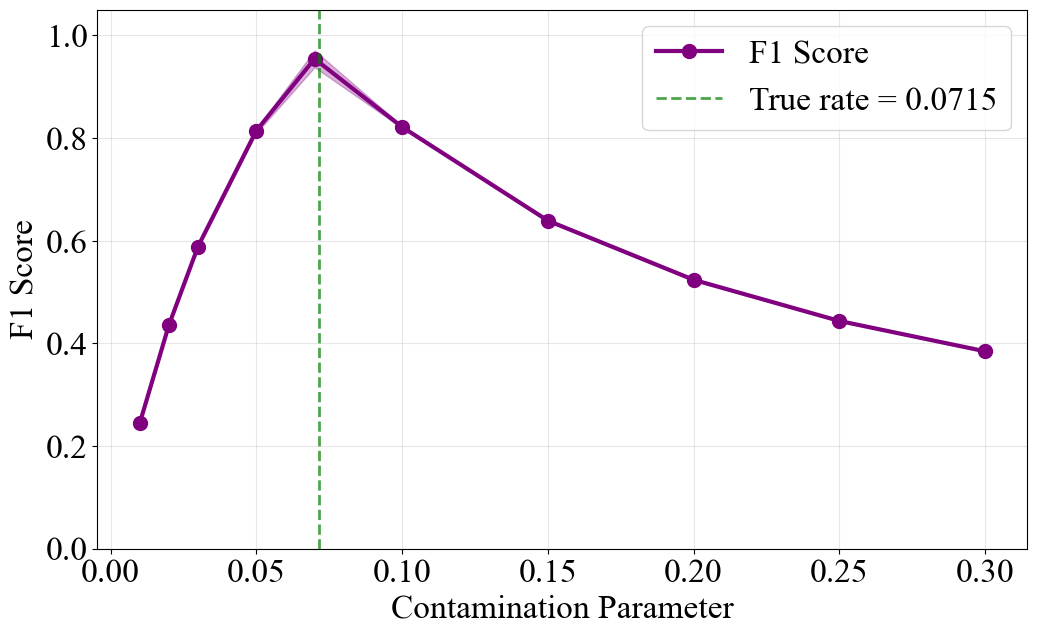

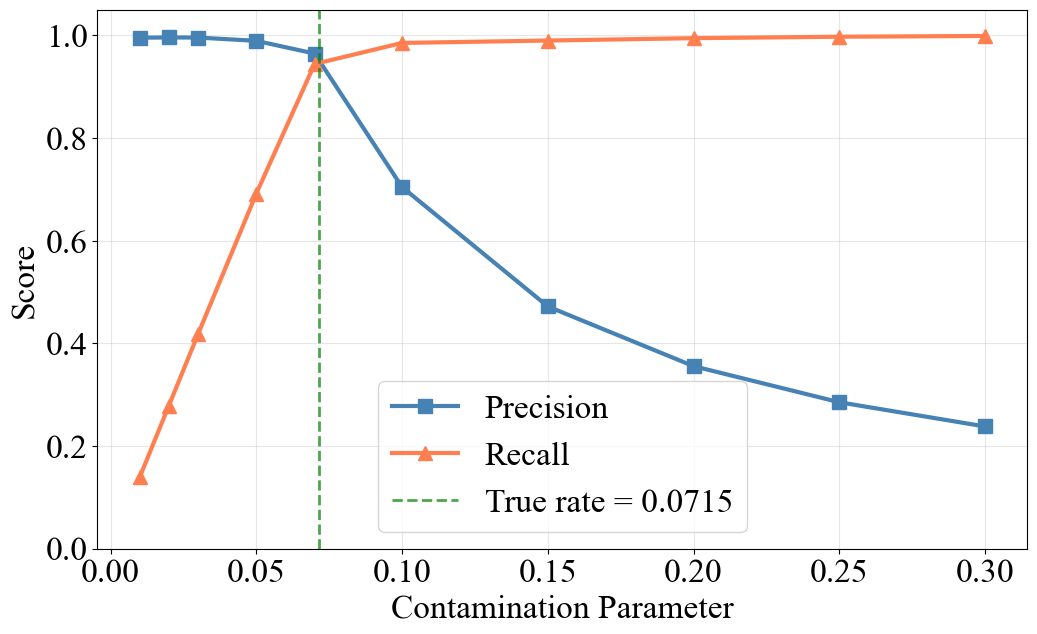

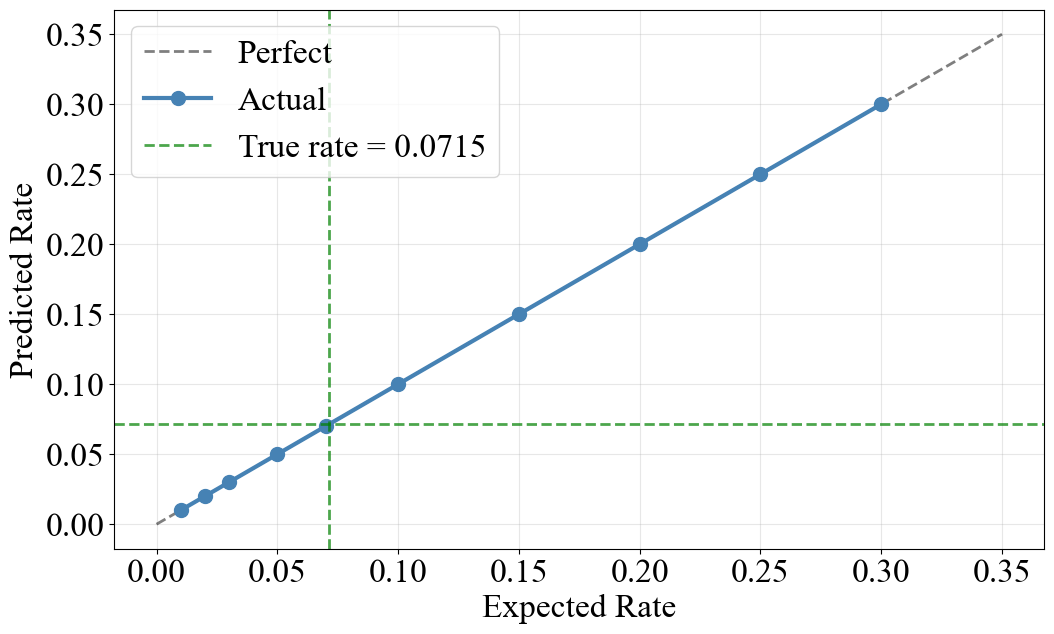

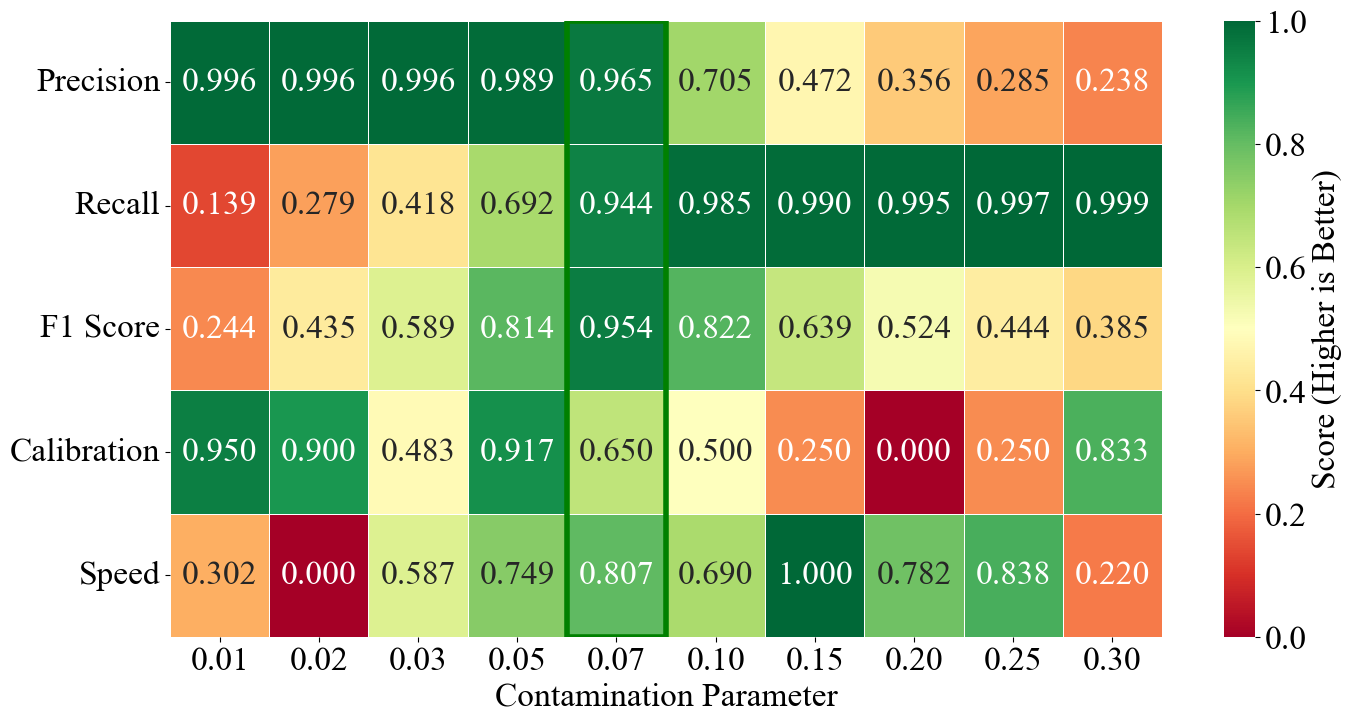


✓ All summary plots created and saved individually!
  Location: ../results/shuttle/contamination/


In [83]:
# Create comprehensive summary table for contamination analysis

# Calculate all metrics
calibration_error_vals = np.array(prediction_rates) - np.array(param_sizes_contamination)
abs_calibration_error = np.abs(calibration_error_vals)
precision_recall_diff = np.array(precision_mean_contamination) - np.array(recall_mean_contamination)

contamination_summary = pd.DataFrame({
    'Contamination': param_sizes_contamination,
    'Precision_Mean': precision_mean_contamination,
    'Precision_Std': precision_std_contamination,
    'Recall_Mean': recall_mean_contamination,
    'Recall_Std': recall_std_contamination,
    'F1_Mean': f1_mean_contamination,
    'F1_Std': f1_std_contamination,
    'P_R_Difference': precision_recall_diff,
    'Predicted_Rate': prediction_rates,
    'Predicted_Rate_Std': prediction_rates_std,
    'Calibration_Error': calibration_error_vals,
    'Abs_Cal_Error': abs_calibration_error,
    'Training_Time_s': training_times_contamination
})

# Add derived columns
contamination_summary['Efficiency_F1_per_sec'] = contamination_summary['F1_Mean'] / contamination_summary['Training_Time_s']
contamination_summary['Favors'] = contamination_summary['P_R_Difference'].apply(
    lambda x: 'Precision' if x > 0.01 else ('Recall' if x < -0.01 else 'Balanced')
)
contamination_summary['Cal_Quality'] = contamination_summary['Abs_Cal_Error'].apply(
    lambda x: 'Excellent' if x < 0.01 else ('Good' if x < 0.03 else ('Fair' if x < 0.05 else 'Poor'))
)

# Save to CSV
summary_path = os.path.join(results_dir, 'contamination/contamination_summary.csv')
contamination_summary.to_csv(summary_path, index=False)
print(f"Comprehensive summary saved to: {summary_path}")

# Display full table
print("\n" + "="*120)
print("CONTAMINATION PARAMETER: COMPREHENSIVE SUMMARY TABLE")
print("="*120)
display(contamination_summary.round(4))

# Statistical summary
print("\n" + "="*120)
print("STATISTICAL SUMMARY")
print("="*120)

print("\nPerformance Statistics:")
print(f"  F1 Score Range: [{contamination_summary['F1_Mean'].min():.4f}, {contamination_summary['F1_Mean'].max():.4f}]")
print(f"  Best F1: {contamination_summary['F1_Mean'].max():.4f} at contamination = {contamination_summary.loc[contamination_summary['F1_Mean'].idxmax(), 'Contamination']:.3f}")
print(f"  F1 at true rate: {contamination_summary.loc[actual_pos, 'F1_Mean']:.4f}")

print("\nCalibration Statistics:")
print(f"  Mean Calibration Error: {contamination_summary['Calibration_Error'].mean():.4f}")
print(f"  Mean Absolute Cal Error: {contamination_summary['Abs_Cal_Error'].mean():.4f}")
print(f"  Best Calibrated: {contamination_summary.loc[contamination_summary['Abs_Cal_Error'].idxmin(), 'Contamination']:.3f}")

print("\nPrecision-Recall Balance:")
print(f"  Precision-dominated settings: {(contamination_summary['Favors'] == 'Precision').sum()}")
print(f"  Recall-dominated settings: {(contamination_summary['Favors'] == 'Recall').sum()}")
print(f"  Balanced settings: {(contamination_summary['Favors'] == 'Balanced').sum()}")

print("\nCalibration Quality Distribution:")
print(contamination_summary['Cal_Quality'].value_counts())

# Recommendations
print("\n" + "="*120)
print("RECOMMENDATIONS")
print("="*120)

# Find best overall (balancing F1, calibration, and efficiency)
contamination_summary['Overall_Score'] = (
    0.5 * (contamination_summary['F1_Mean'] / contamination_summary['F1_Mean'].max()) +
    0.3 * (1 - contamination_summary['Abs_Cal_Error'] / contamination_summary['Abs_Cal_Error'].max()) +
    0.2 * (contamination_summary['Efficiency_F1_per_sec'] / contamination_summary['Efficiency_F1_per_sec'].max())
)

best_overall_idx = contamination_summary['Overall_Score'].idxmax()
best_f1_idx = contamination_summary['F1_Mean'].idxmax()
best_cal_idx = contamination_summary['Abs_Cal_Error'].idxmin()

print(f"\n1. For MAXIMUM PERFORMANCE:")
print(f"   → Contamination = {contamination_summary.loc[best_f1_idx, 'Contamination']:.3f}")
print(f"   → F1 Score = {contamination_summary.loc[best_f1_idx, 'F1_Mean']:.4f}")
print(f"   → Calibration Error = {abs(contamination_summary.loc[best_f1_idx, 'Calibration_Error']):.4f}")

print(f"\n2. For BEST CALIBRATION:")
print(f"   → Contamination = {contamination_summary.loc[best_cal_idx, 'Contamination']:.3f}")
print(f"   → F1 Score = {contamination_summary.loc[best_cal_idx, 'F1_Mean']:.4f}")
print(f"   → Calibration Error = {contamination_summary.loc[best_cal_idx, 'Abs_Cal_Error']:.4f}")

print(f"\n3. For BALANCED APPROACH (Weighted Score):")
print(f"   → Contamination = {contamination_summary.loc[best_overall_idx, 'Contamination']:.3f}")
print(f"   → F1 Score = {contamination_summary.loc[best_overall_idx, 'F1_Mean']:.4f}")
print(f"   → Calibration Error = {abs(contamination_summary.loc[best_overall_idx, 'Calibration_Error']):.4f}")
print(f"   → Overall Score = {contamination_summary.loc[best_overall_idx, 'Overall_Score']:.4f}")

print(f"\n4. Using KNOWN CONTAMINATION RATE:")
print(f"   → Contamination = {actual_contamination:.4f}")
print(f"   → F1 Score = {contamination_summary.loc[actual_pos, 'F1_Mean']:.4f}")
print(f"   → Note: {'Performs well' if contamination_summary.loc[actual_pos, 'F1_Mean'] > contamination_summary['F1_Mean'].quantile(0.75) else 'May not be optimal'}")

print("\n" + "="*120)

# Create individual summary plots (no subfigures)

# Summary Plot 1: F1 Performance Overview
plt.figure(figsize=(12, 7))
plt.plot(param_sizes_contamination, f1_mean_contamination, 'o-', linewidth=3, 
        markersize=10, label='F1 Score', color='purple')
plt.axvline(x=actual_contamination, color='green', linestyle='--', linewidth=2, alpha=0.7,
           label=f'True rate = {actual_contamination:.4f}')
plt.fill_between(param_sizes_contamination,
                np.array(f1_mean_contamination) - np.array(f1_std_contamination),
                np.array(f1_mean_contamination) + np.array(f1_std_contamination),
                alpha=0.3, color='purple')
plt.xlabel('Contamination Parameter')
plt.ylabel('F1 Score')
plt.ylim([0, 1.05])
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(results_dir, 'contamination/summary_f1_overview.pdf'), 
           dpi=300, bbox_inches='tight')
plt.show()

# Summary Plot 2: Precision vs Recall Overview
plt.figure(figsize=(12, 7))
plt.plot(param_sizes_contamination, precision_mean_contamination, 's-', 
        linewidth=3, markersize=10, label='Precision', color='steelblue')
plt.plot(param_sizes_contamination, recall_mean_contamination, '^-', 
        linewidth=3, markersize=10, label='Recall', color='coral')
plt.axvline(x=actual_contamination, color='green', linestyle='--', linewidth=2, alpha=0.7,
           label=f'True rate = {actual_contamination:.4f}')
plt.xlabel('Contamination Parameter')
plt.ylabel('Score')
plt.ylim([0, 1.05])
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(results_dir, 'contamination/summary_precision_recall.pdf'), 
           dpi=300, bbox_inches='tight')
plt.show()

# Summary Plot 3: Calibration Overview
plt.figure(figsize=(12, 7))
plt.plot([0, 0.35], [0, 0.35], 'k--', linewidth=2, alpha=0.5, label='Perfect')
plt.plot(param_sizes_contamination, prediction_rates, 'o-', linewidth=3, 
        markersize=10, label='Actual', color='steelblue')
plt.axvline(x=actual_contamination, color='green', linestyle='--', linewidth=2, alpha=0.7,
           label=f'True rate = {actual_contamination:.4f}')
plt.axhline(y=actual_contamination, color='green', linestyle='--', linewidth=2, alpha=0.7)
plt.xlabel('Expected Rate')
plt.ylabel('Predicted Rate')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(results_dir, 'contamination/summary_calibration.pdf'), 
           dpi=300, bbox_inches='tight')
plt.show()

# Summary Plot 4: Heatmap of all metrics
plt.figure(figsize=(16, 8))

# Normalize metrics for heatmap
metrics_for_heatmap = contamination_summary[[
    'Precision_Mean', 'Recall_Mean', 'F1_Mean', 
    'Abs_Cal_Error', 'Training_Time_s'
]].copy()

# Invert calibration error and training time (lower is better)
metrics_for_heatmap['Cal_Quality'] = 1 - metrics_for_heatmap['Abs_Cal_Error'] / metrics_for_heatmap['Abs_Cal_Error'].max()
metrics_for_heatmap['Speed'] = 1 - (metrics_for_heatmap['Training_Time_s'] - metrics_for_heatmap['Training_Time_s'].min()) / (metrics_for_heatmap['Training_Time_s'].max() - metrics_for_heatmap['Training_Time_s'].min())

heatmap_data = metrics_for_heatmap[['Precision_Mean', 'Recall_Mean', 'F1_Mean', 'Cal_Quality', 'Speed']].T

sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', 
           xticklabels=[f'{c:.2f}' for c in param_sizes_contamination],
           yticklabels=['Precision', 'Recall', 'F1 Score', 'Calibration', 'Speed'],
           cbar_kws={'label': 'Score (Higher is Better)'},
           vmin=0, vmax=1, linewidths=0.5)

plt.xlabel('Contamination Parameter')

# Highlight actual contamination column with a rectangle
actual_col = np.argmin([abs(actual_contamination - c) for c in param_sizes_contamination])
from matplotlib.patches import Rectangle
rect = Rectangle((actual_col, 0), 1, 5, fill=False, edgecolor='green', linewidth=4)
plt.gca().add_patch(rect)

plt.savefig(os.path.join(results_dir, 'contamination/summary_heatmap.pdf'), 
           dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ All summary plots created and saved individually!")
print(f"  Location: {os.path.join(results_dir, 'contamination/')}")

### Maximum features

In [84]:
# grid
# check if num params  is > 20
if X.shape[1] > 20:
    features_to_use = 20
else:
    features_to_use = X.shape[1]

max_features_grid = np.linspace(1, features_to_use, num=features_to_use, dtype=int)

In [85]:
max_features_grid

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [86]:
# run models
max_features_results = []
csv_path_features = os.path.join(results_dir, 'max_features/features_results.csv')
# remove existing csv if exists
if os.path.exists(csv_path_features):
    os.remove(csv_path_features)

for max_features in max_features_grid:
    params = base_params.copy()
    params['max_features'] = max_features

    print(f"Running Isolation Forest with max_features={max_features}")
    result = evaluate_isolation_forest_with_std(X, y, params, 'max_features', max_features,n_runs=10)

    # append results to csv
    result_df = pd.DataFrame([result])
    
    # Write header if file doesn't exist, otherwise append
    if not os.path.exists(csv_path_features):
        result_df.to_csv(csv_path_features, mode='w', header=True, index=False)
    else:
        result_df.to_csv(csv_path_features, mode='a', header=False, index=False)

    max_features_results.append(result)

Running Isolation Forest with max_features=1
Running Isolation Forest with max_features=2
Running Isolation Forest with max_features=3
Running Isolation Forest with max_features=4
Running Isolation Forest with max_features=5
Running Isolation Forest with max_features=6
Running Isolation Forest with max_features=7
Running Isolation Forest with max_features=8
Running Isolation Forest with max_features=9


In [89]:
# load
df_results_max_features = pd.read_csv(os.path.join(results_dir, 'max_features/features_results.csv'))

# Extract data
param_sizes_max_features = df_results_max_features['param_value'].tolist()
precision_mean_max_features = df_results_max_features['precision_mean'].tolist()
precision_std_max_features = df_results_max_features['precision_std'].tolist()
recall_mean_max_features = df_results_max_features['recall_mean'].tolist()
recall_std_max_features = df_results_max_features['recall_std'].tolist()
f1_mean_max_features = df_results_max_features['f1_score_mean'].tolist()
f1_std_max_features = df_results_max_features['f1_score_std'].tolist()
training_times_max_features = df_results_max_features['training_time_mean'].tolist()

print(f"Loaded results for {len(param_sizes_max_features)} parameter values")

Loaded results for 9 parameter values


#### 1. Performance vs Max_features

Total features in shuttle dataset: 9


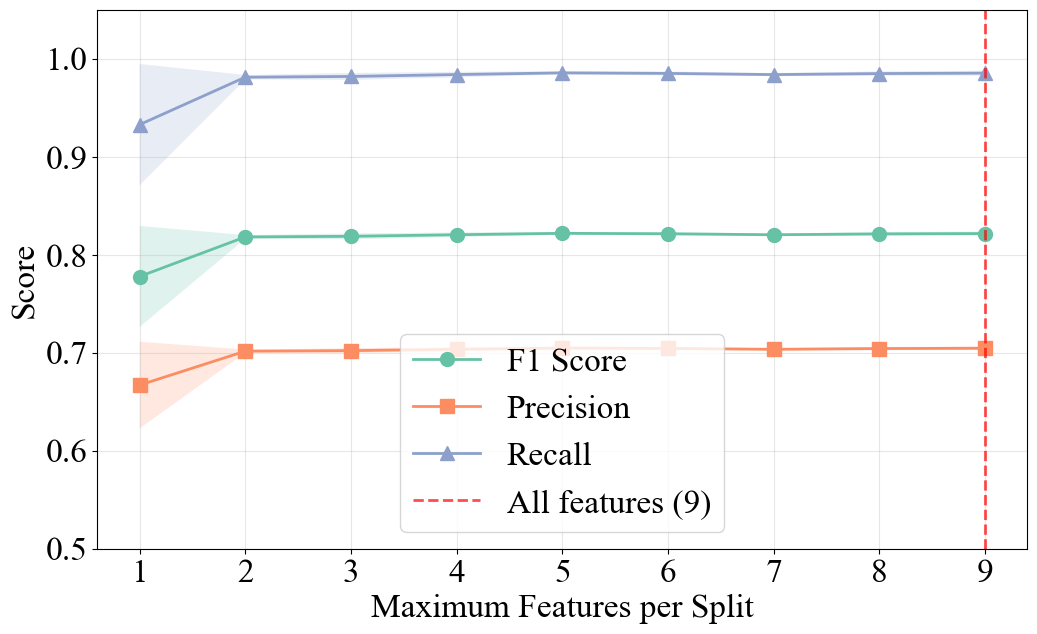


PERFORMANCE vs MAX_FEATURES ANALYSIS

Best F1 Score: 0.8218 ± 0.0014
  at max_features = 5

Using ALL features (9):
  F1 Score: 0.8216 ± 0.0020
  Performance difference from best: 0.02%

Performance across max_features:
  max_features=1: F1=0.7778, Precision=0.6670, Recall=0.9327
  max_features=2: F1=0.8181, Precision=0.7016, Recall=0.9811
  max_features=3: F1=0.8188, Precision=0.7021, Recall=0.9819
  max_features=4: F1=0.8204, Precision=0.7035, Recall=0.9839
  max_features=5: F1=0.8218, Precision=0.7047, Recall=0.9856
  max_features=6: F1=0.8214, Precision=0.7044, Recall=0.9850
  max_features=7: F1=0.8204, Precision=0.7035, Recall=0.9838
  max_features=8: F1=0.8212, Precision=0.7043, Recall=0.9848
  max_features=9: F1=0.8216, Precision=0.7046, Recall=0.9853

Correlation between max_features and F1: r = 0.6030 (p = 0.0856)
→ Feature subsampling has MINIMAL impact on performance
  Interpretation: Performance is robust to feature selection


In [90]:
# Get total number of features in dataset
n_total_features = X.shape[1]
print(f"Total features in {dataset} dataset: {n_total_features}")

# Plot: Performance (F1, Precision, Recall) vs max_features
plt.figure(figsize=(12, 7))

# Plot F1 score
plt.plot(param_sizes_max_features, f1_mean_max_features, marker='o', 
         linewidth=2, markersize=10, label='F1 Score')
plt.fill_between(param_sizes_max_features,
                 np.array(f1_mean_max_features) - np.array(f1_std_max_features),
                 np.array(f1_mean_max_features) + np.array(f1_std_max_features),
                 alpha=0.2)

# Plot Precision
plt.plot(param_sizes_max_features, precision_mean_max_features, marker='s', 
         linewidth=2, markersize=10, label='Precision')
plt.fill_between(param_sizes_max_features,
                 np.array(precision_mean_max_features) - np.array(precision_std_max_features),
                 np.array(precision_mean_max_features) + np.array(precision_std_max_features),
                 alpha=0.2)

# Plot Recall
plt.plot(param_sizes_max_features, recall_mean_max_features, marker='^', 
         linewidth=2, markersize=10, label='Recall')
plt.fill_between(param_sizes_max_features,
                 np.array(recall_mean_max_features) - np.array(recall_std_max_features),
                 np.array(recall_mean_max_features) + np.array(recall_std_max_features),
                 alpha=0.2)

# Mark the total number of features (for reference)
if n_total_features in param_sizes_max_features:
    plt.axvline(x=n_total_features, color='red', linestyle='--', 
               linewidth=2, alpha=0.7, label=f'All features ({n_total_features})')

plt.xlabel('Maximum Features per Split')
plt.ylabel('Score')
plt.ylim([0.5, 1.05])
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(results_dir, 'max_features/performance_vs_max_features.pdf'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Analysis
print(f"\n{'='*70}")
print(f"PERFORMANCE vs MAX_FEATURES ANALYSIS")
print(f"{'='*70}")

# Find best performing configuration
best_f1_idx = np.argmax(f1_mean_max_features)
print(f"\nBest F1 Score: {f1_mean_max_features[best_f1_idx]:.4f} ± {f1_std_max_features[best_f1_idx]:.4f}")
print(f"  at max_features = {param_sizes_max_features[best_f1_idx]}")

# Compare with using all features
if n_total_features in param_sizes_max_features:
    all_feat_idx = param_sizes_max_features.index(n_total_features)
    print(f"\nUsing ALL features ({n_total_features}):")
    print(f"  F1 Score: {f1_mean_max_features[all_feat_idx]:.4f} ± {f1_std_max_features[all_feat_idx]:.4f}")
    print(f"  Performance difference from best: {(f1_mean_max_features[best_f1_idx] - f1_mean_max_features[all_feat_idx])*100:.2f}%")

# Analyze performance trend
print(f"\nPerformance across max_features:")
for i, max_feat in enumerate(param_sizes_max_features):
    print(f"  max_features={max_feat}: F1={f1_mean_max_features[i]:.4f}, "
          f"Precision={precision_mean_max_features[i]:.4f}, "
          f"Recall={recall_mean_max_features[i]:.4f}")

# Check if feature subsampling helps or hurts
f1_values = np.array(f1_mean_max_features)
if len(f1_values) > 2:
    # Calculate correlation between max_features and F1
    from scipy.stats import pearsonr
    corr, p_value = pearsonr(param_sizes_max_features, f1_values)
    print(f"\nCorrelation between max_features and F1: r = {corr:.4f} (p = {p_value:.4f})")
    
    if corr > 0.3 and p_value < 0.05:
        print(f"✓ Feature subsampling HURTS performance for {dataset} dataset (low-dimensional)")
        print(f"  Interpretation: With only {n_total_features} features, using all features is better")
    elif corr < -0.3 and p_value < 0.05:
        print(f"✓ Feature subsampling HELPS performance for {dataset} dataset")
        print(f"  Interpretation: Random feature selection creates diversity in ensemble")
    else:
        print(f"→ Feature subsampling has MINIMAL impact on performance")
        print(f"  Interpretation: Performance is robust to feature selection")

**Interpretation - Performance vs max_features:**

The max_features parameter controls how many features are randomly selected at each split in the isolation trees. This analysis reveals its impact on model performance:

**Key Observations:**
- **Low-dimensional datasets** (like Shuttle with 9 features): Using all features typically performs best
  - Feature subsampling may hurt performance because there aren't enough features to create meaningful diversity
  - Random feature selection might exclude important discriminative features
  
- **High-dimensional datasets** (like Speech with 400 features): Feature subsampling often helps
  - Creates diversity in the ensemble (each tree sees different feature subsets)
  - Reduces correlation between trees → better ensemble performance
  - Can reduce overfitting by preventing trees from always splitting on the same dominant features
  - Faster training due to fewer features to evaluate at each split

**Trade-off:**
- **More features** = More information per tree, but less diversity across trees
- **Fewer features** = More diverse ensemble, but each tree has less information

The optimal value depends on dataset dimensionality and the signal-to-noise ratio in the features.

#### 2. Feature Subsampling vs. Training Time Trade-off

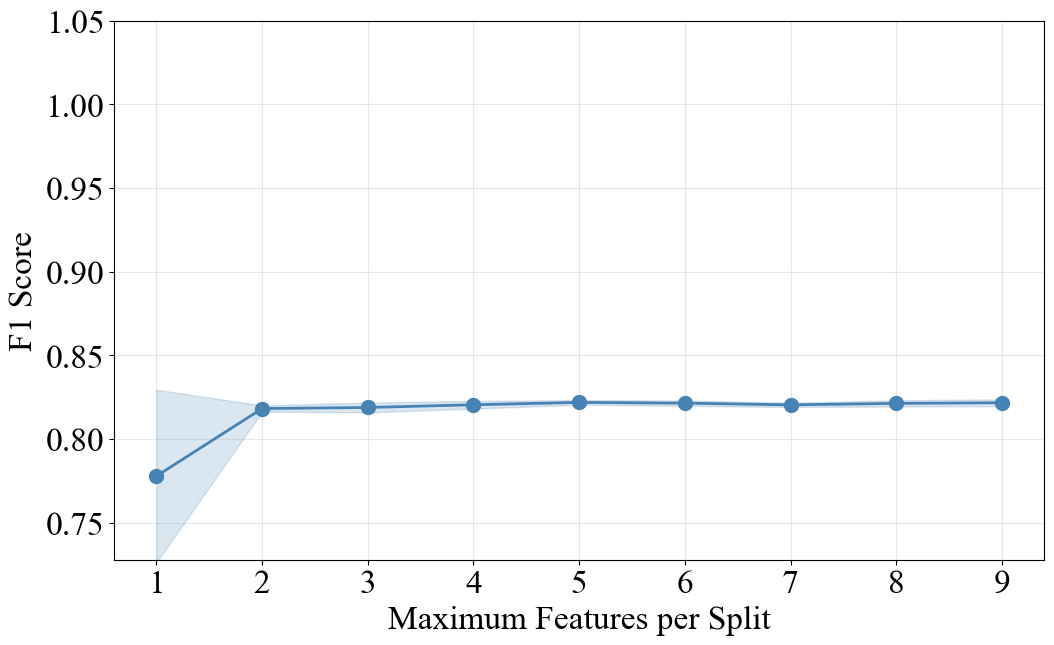

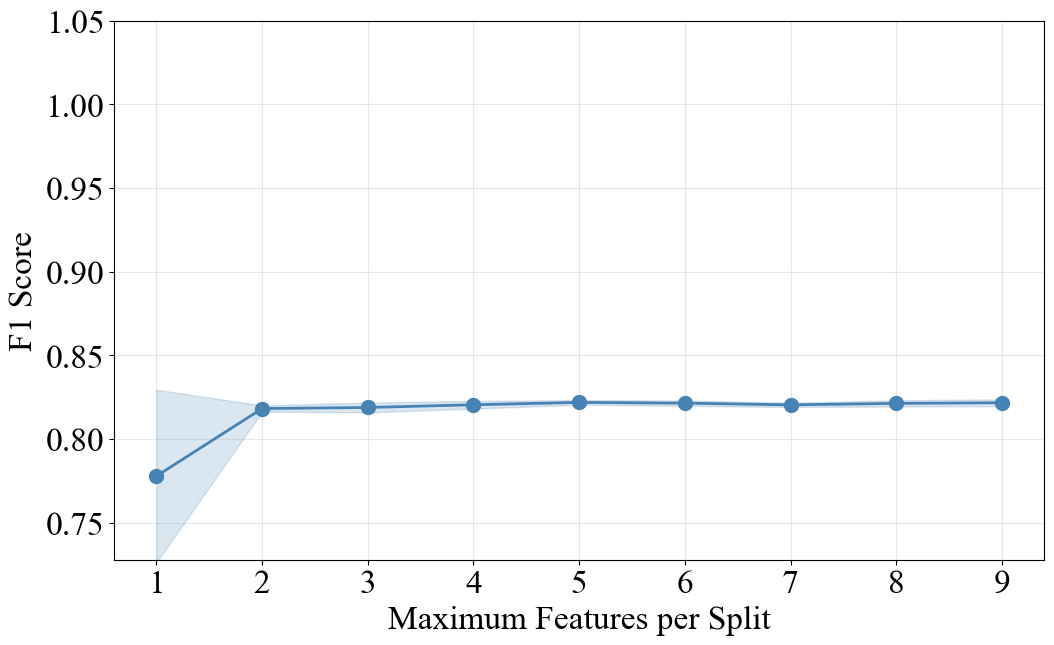

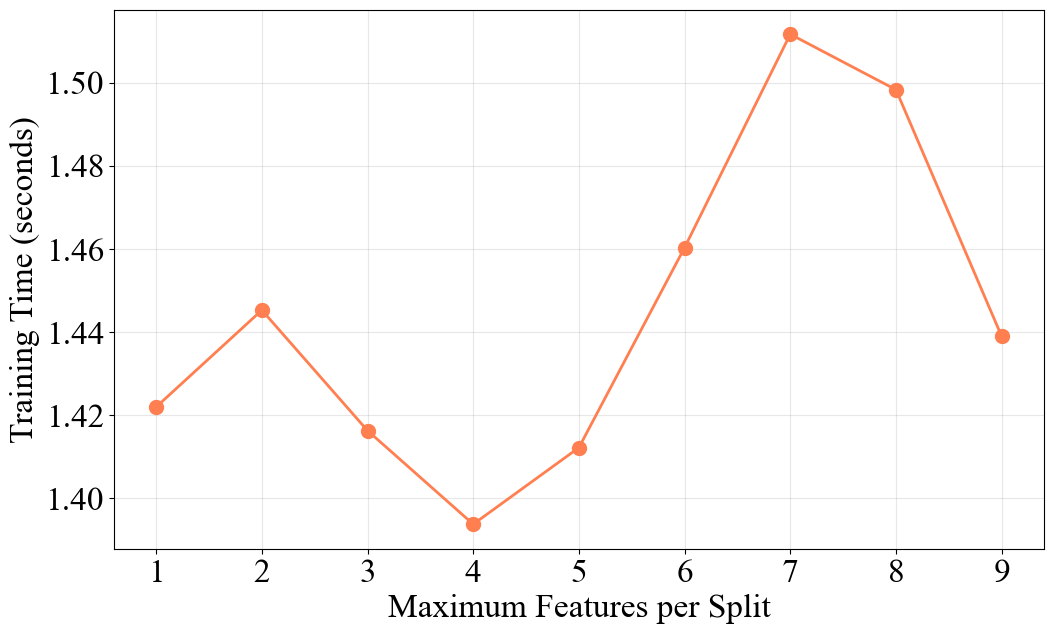

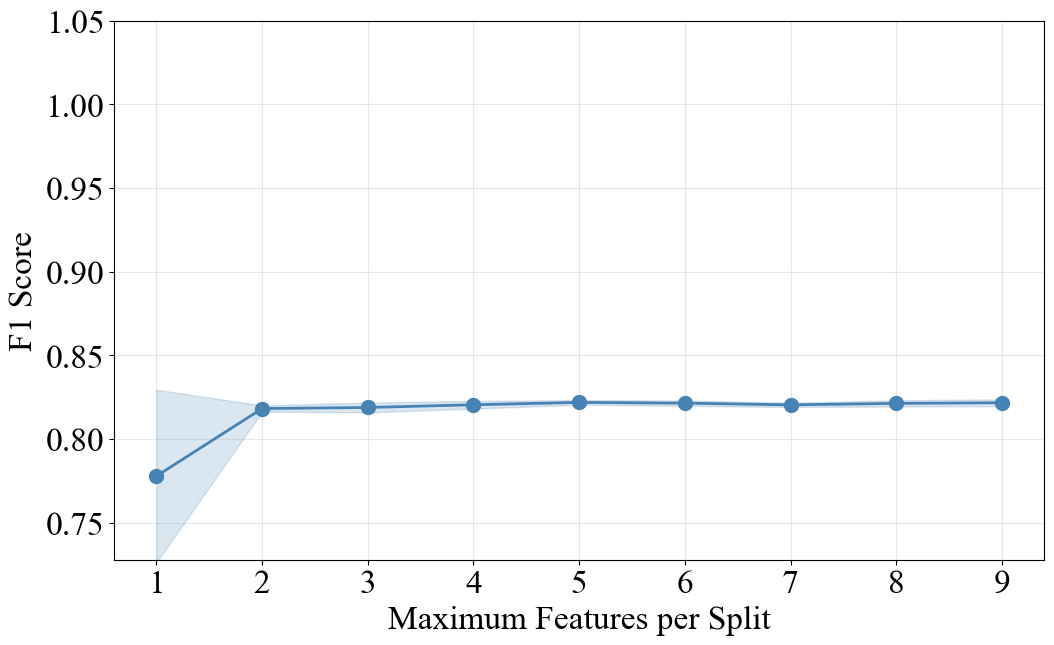

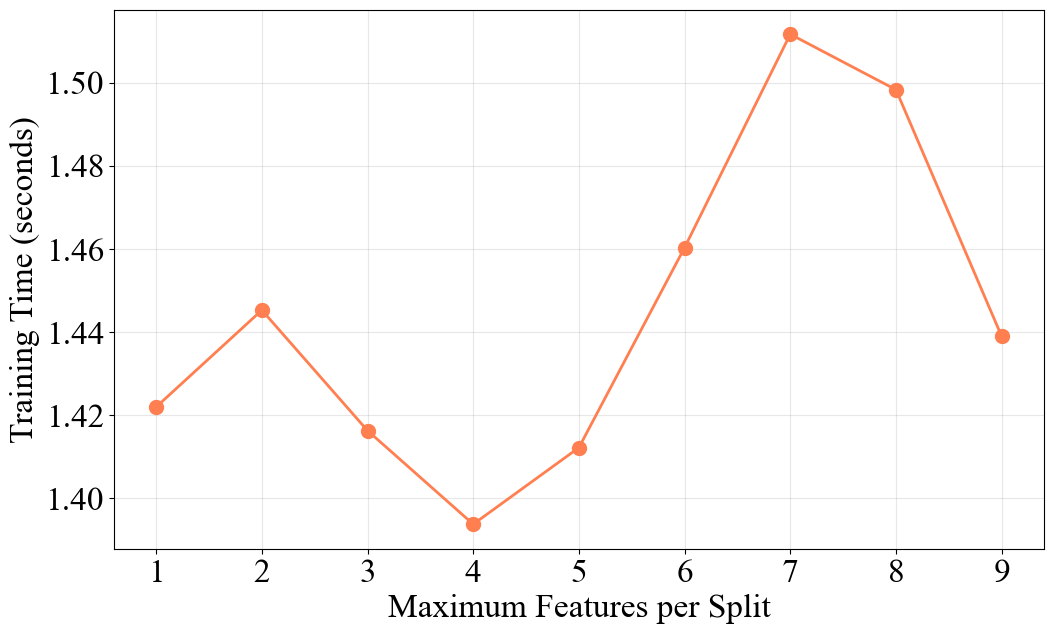

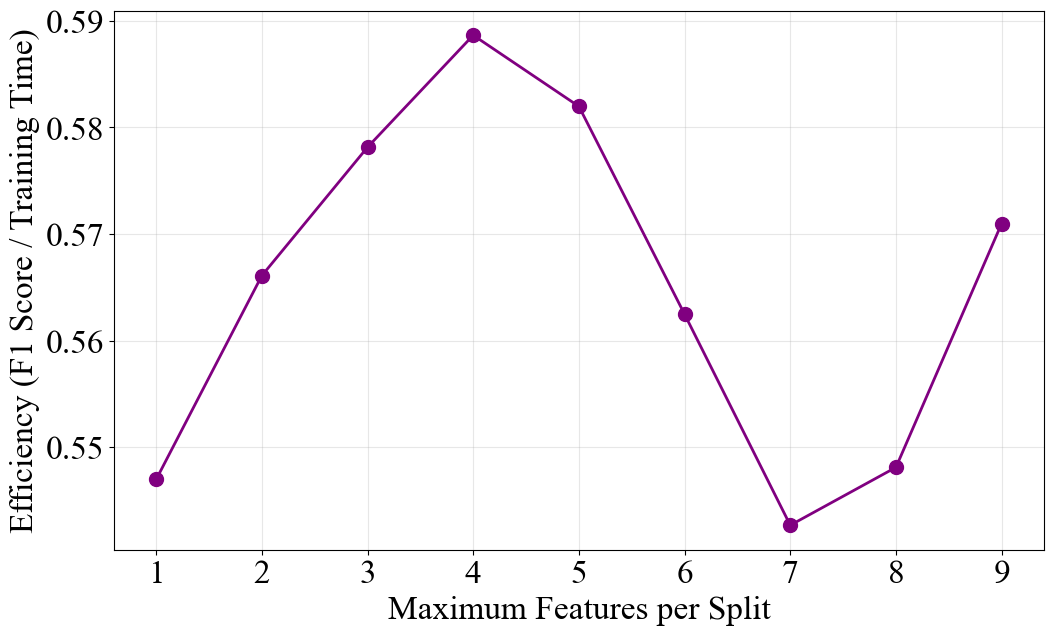

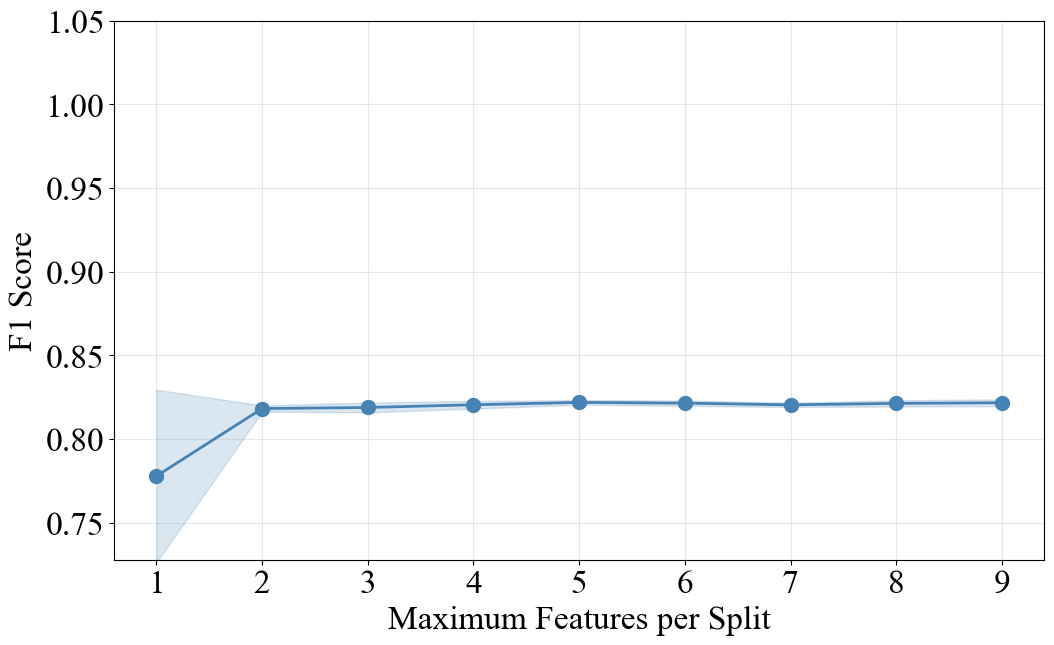

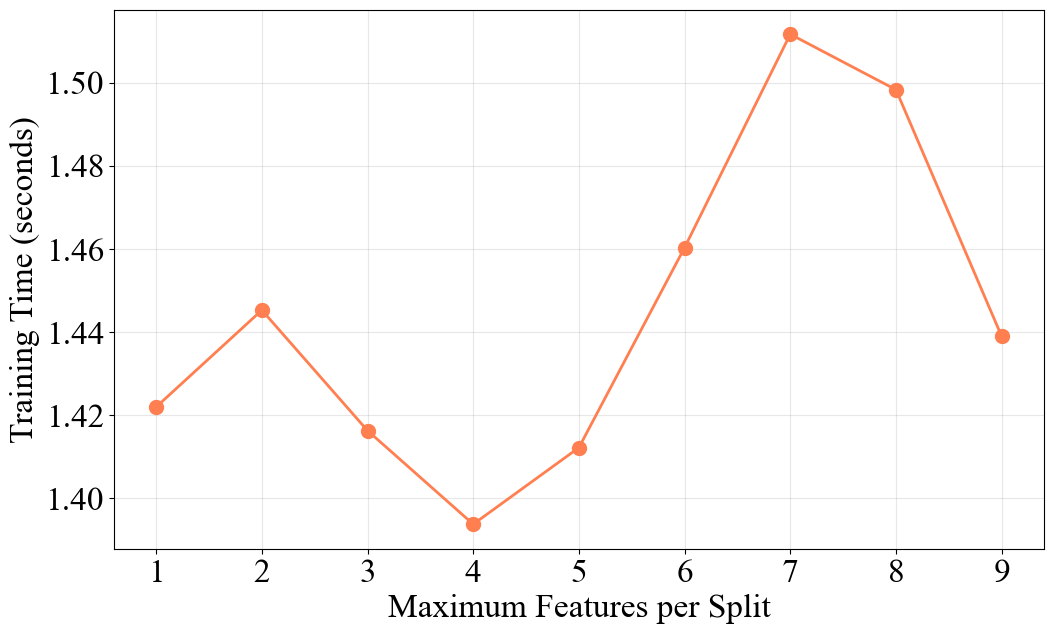

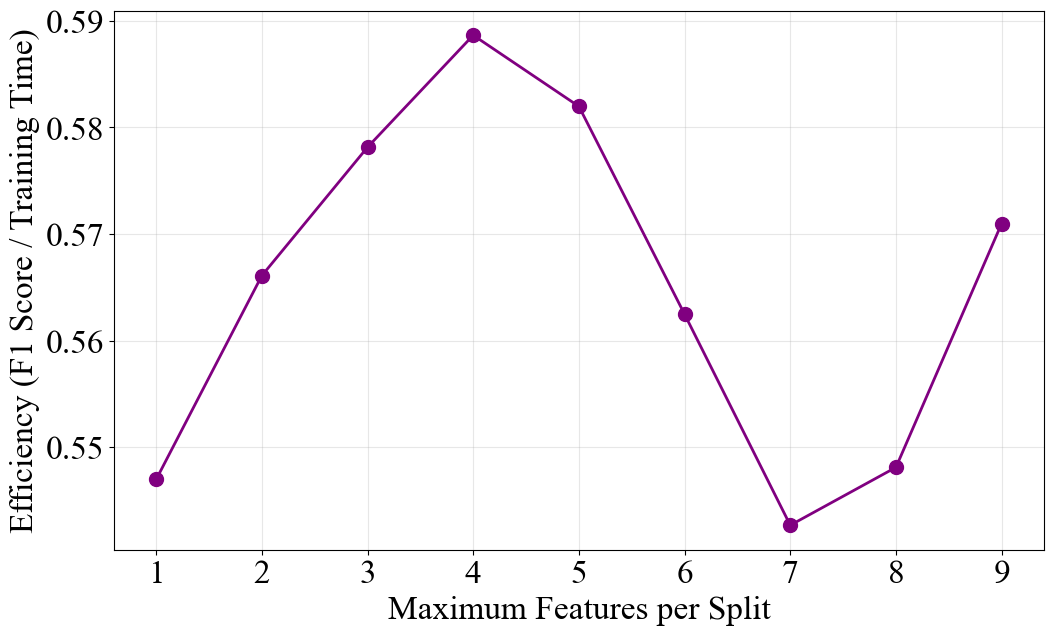

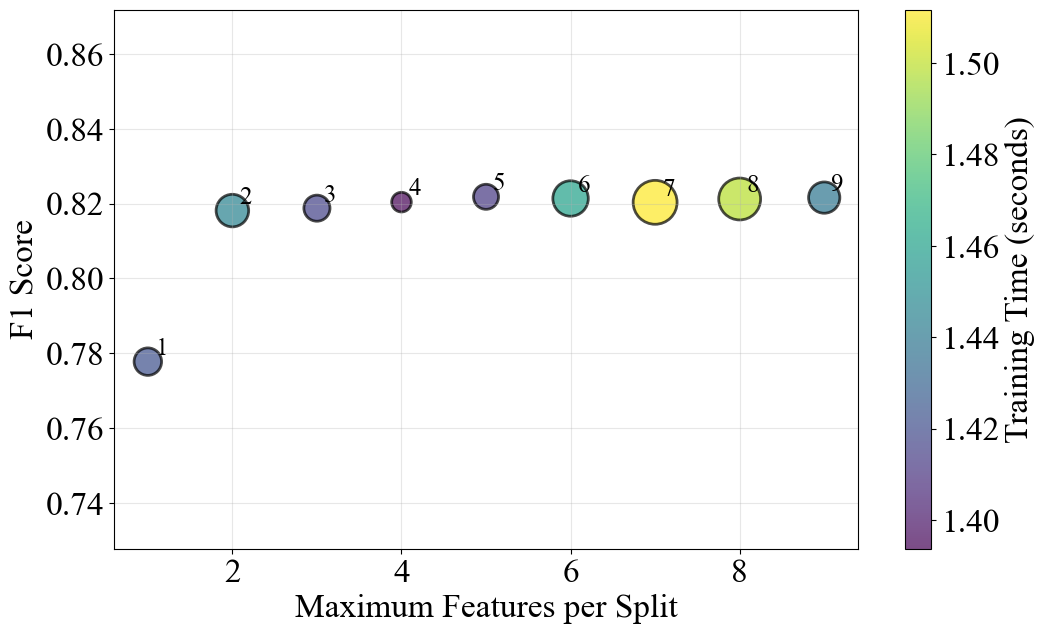


TRAINING TIME TRADE-OFF ANALYSIS

Best Efficiency (F1/time): 0.588650
  at max_features = 4
  F1 Score: 0.8204
  Training Time: 1.394s

Sweet Spot Analysis (95% of best performance = 0.7807):
  Minimum features achieving 95% performance: 2
    F1 Score: 0.8181
    Training Time: 1.445s
    Feature reduction: 77.8%
    Time saving vs all features: -0.4%

  ✓ Efficiency gain: Use 2 features instead of 9
    → -0.4% faster with -0.42% F1 difference

Efficiency Table:
max_features    F1 Score     Time (s)     Efficiency      vs Best F1  
----------------------------------------------------------------------
1               0.7778       1.422        0.546984        94.6        %
2               0.8181       1.445        0.566101        99.6        %
3               0.8188       1.416        0.578146        99.6        %
4               0.8204       1.394        0.588650        99.8        %
5               0.8218       1.412        0.581972        100.0       %
6               0.8214      

In [91]:
# Feature Subsampling vs Training Time Trade-off

# Plot 1: F1 Score vs max_features
plt.figure(figsize=(12, 7))
plt.plot(param_sizes_max_features, f1_mean_max_features, marker='o', 
        linewidth=2, markersize=10, color='steelblue')
plt.fill_between(param_sizes_max_features,
                 np.array(f1_mean_max_features) - np.array(f1_std_max_features),
                 np.array(f1_mean_max_features) + np.array(f1_std_max_features),
                 alpha=0.2, color='steelblue')

plt.xlabel('Maximum Features per Split')
plt.ylabel('F1 Score')
plt.ylim([min(f1_mean_max_features) - 0.05, 1.05])
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(results_dir, 'max_features/f1_vs_max_features.pdf'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Training Time vs max_features
plt.figure(figsize=(12, 7))
plt.plot(param_sizes_max_features, training_times_max_features, marker='o', 
        linewidth=2, markersize=10, color='coral')

plt.xlabel('Maximum Features per Split')
plt.ylabel('Training Time (seconds)')
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(results_dir, 'max_features/training_time_vs_max_features.pdf'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Plot 3: Efficiency plot (F1 per second)
efficiency_max_features = np.array(f1_mean_max_features) / np.array(training_times_max_features)

plt.figure(figsize=(12, 7))
plt.plot(param_sizes_max_features, efficiency_max_features, marker='o', 
        linewidth=2, markersize=10, color='purple')

plt.xlabel('Maximum Features per Split')
plt.ylabel('Efficiency (F1 Score / Training Time)')
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(results_dir, 'max_features/efficiency_vs_max_features.pdf'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Plot 4: Scatter plot with size encoding time
plt.figure(figsize=(12, 7))

# Normalize training times for size encoding (scale 100-1000)
time_normalized = np.array(training_times_max_features)
time_min, time_max = time_normalized.min(), time_normalized.max()
sizes = 200 + 800 * (time_normalized - time_min) / (time_max - time_min) if time_max > time_min else [500] * len(time_normalized)

scatter = plt.scatter(param_sizes_max_features, f1_mean_max_features, 
                     s=sizes, c=training_times_max_features, cmap='viridis',
                     alpha=0.7, edgecolors='black', linewidth=2)

# Annotate points
for i, max_feat in enumerate(param_sizes_max_features):
    plt.annotate(f'{max_feat}', 
               xy=(param_sizes_max_features[i], f1_mean_max_features[i]),
               xytext=(5, 5), textcoords='offset points', fontsize=18)

plt.xlabel('Maximum Features per Split')
plt.ylabel('F1 Score')
plt.ylim([min(f1_mean_max_features) - 0.05, max(f1_mean_max_features) + 0.05])

cbar = plt.colorbar(scatter)
cbar.set_label('Training Time (seconds)')

plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(results_dir, 'max_features/f1_vs_features_with_time.pdf'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Analysis: Find sweet spot
print(f"\n{'='*70}")
print(f"TRAINING TIME TRADE-OFF ANALYSIS")
print(f"{'='*70}")

# Find the sweet spot (best efficiency)
best_efficiency_idx = np.argmax(efficiency_max_features)
print(f"\nBest Efficiency (F1/time): {efficiency_max_features[best_efficiency_idx]:.6f}")
print(f"  at max_features = {param_sizes_max_features[best_efficiency_idx]}")
print(f"  F1 Score: {f1_mean_max_features[best_efficiency_idx]:.4f}")
print(f"  Training Time: {training_times_max_features[best_efficiency_idx]:.3f}s")

# Check if there's a sweet spot: 95% performance with 50% features
target_f1 = 0.95 * max(f1_mean_max_features)
print(f"\nSweet Spot Analysis (95% of best performance = {target_f1:.4f}):")

sweet_spots = []
for i, (feat, f1, time) in enumerate(zip(param_sizes_max_features, f1_mean_max_features, training_times_max_features)):
    if f1 >= target_f1:
        sweet_spots.append((feat, f1, time, i))

if sweet_spots:
    # Sort by number of features (ascending)
    sweet_spots.sort(key=lambda x: x[0])
    min_feat_sweet = sweet_spots[0]
    
    print(f"  Minimum features achieving 95% performance: {min_feat_sweet[0]}")
    print(f"    F1 Score: {min_feat_sweet[1]:.4f}")
    print(f"    Training Time: {min_feat_sweet[2]:.3f}s")
    print(f"    Feature reduction: {(1 - min_feat_sweet[0]/n_total_features)*100:.1f}%")
    
    # Compare with using all features
    if n_total_features in param_sizes_max_features:
        all_feat_idx = param_sizes_max_features.index(n_total_features)
        time_saving = (1 - min_feat_sweet[2] / training_times_max_features[all_feat_idx]) * 100
        print(f"    Time saving vs all features: {time_saving:.1f}%")
        print(f"\n  ✓ Efficiency gain: Use {min_feat_sweet[0]} features instead of {n_total_features}")
        print(f"    → {time_saving:.1f}% faster with {(min_feat_sweet[1]/f1_mean_max_features[all_feat_idx]-1)*100:.2f}% F1 difference")
else:
    print(f"  No configuration achieves 95% of best performance")

# Quantify efficiency gains
print(f"\nEfficiency Table:")
print(f"{'max_features':<15} {'F1 Score':<12} {'Time (s)':<12} {'Efficiency':<15} {'vs Best F1':<12}")
print("-" * 70)
max_f1 = max(f1_mean_max_features)
for i, feat in enumerate(param_sizes_max_features):
    rel_perf = f1_mean_max_features[i] / max_f1 * 100
    print(f"{feat:<15} {f1_mean_max_features[i]:<12.4f} {training_times_max_features[i]:<12.3f} "
          f"{efficiency_max_features[i]:<15.6f} {rel_perf:<12.1f}%")

**Interpretation - Feature Subsampling vs Training Time Trade-off:**

This analysis quantifies the performance-speed trade-off when using feature subsampling:

**Four Complementary Views:**

1. **F1 vs max_features**: Shows how performance changes with feature subsampling
   - Identifies optimal feature count for best accuracy
   - Reveals sensitivity to feature selection

2. **Training Time vs max_features**: Shows computational cost
   - Fewer features = faster training (fewer split evaluations)
   - Can be significant speedup for high-dimensional data

3. **Efficiency (F1/time)**: Identifies the "sweet spot"
   - Best balance between accuracy and speed
   - Particularly valuable for production deployment
   - May differ from max F1 if training time is a constraint

4. **Scatter with size encoding**: Integrated view
   - Bubble size represents training time
   - Easy to identify Pareto-optimal configurations
   - Shows which settings dominate others

**Sweet Spot Analysis:**
- Target: 95% of maximum performance
- Question: Can we achieve this with significantly fewer features?
- For **high-dimensional datasets**: Often YES (e.g., 50% features → 95%+ performance)
- For **low-dimensional datasets**: Usually NO (need most/all features)

**Practical Implications:**
- **Development**: Use all features for maximum accuracy
- **Production**: Consider the sweet spot if speed matters
- **Large-scale**: Feature subsampling can enable real-time inference

#### 3. Interaction Heatmap

In [99]:
# need to run experiments
interaction_features = max_features_grid
# sample len(interaction_features) evenly spaced from n_est_grid
interaction_n_est = np.linspace(
    0, len(num_est_grid_narrow) - 1, len(interaction_features), dtype=int
)

In [102]:
# Run interaction experiments: max_features × n_estimators
print(f"\n{'='*70}")
print(f"RUNNING INTERACTION EXPERIMENTS: max_features × n_estimators")
print(f"{'='*70}")

# Get the n_estimator values to test (sampled from num_est_grid_narrow)
interaction_n_est_values = [num_est_grid_narrow[i] for i in interaction_n_est]

print(f"\nmax_features values: {interaction_features.tolist()}")
print(f"n_estimators values: {interaction_n_est_values}")
print(f"\nTotal combinations: {len(interaction_features) * len(interaction_n_est_values)}")

# Store results
interaction_results = []

# Define baseline parameters
baseline_params = {
    'contamination': 0.07,  
    'max_samples': 'auto',
    'bootstrap': False,
    'n_jobs': -1
}

# Run experiments for all combinations
total_experiments = len(interaction_features) * len(interaction_n_est_values)
experiment_counter = 0

for max_feat in interaction_features:
    for n_est in interaction_n_est_values:
        experiment_counter += 1
        print(f"\rProgress: {experiment_counter}/{total_experiments} "
              f"(max_features={max_feat}, n_estimators={n_est})", end='')
        
        # Set parameters for this experiment
        params = baseline_params.copy()
        params['max_features'] = int(max_feat)
        params['n_estimators'] = int(n_est)
        
        # Evaluate with multiple runs for stability
        result = evaluate_isolation_forest_with_std(
            X, y, 
            params=params,
            param_name='interaction',
            param_value=f"mf={max_feat}_ne={n_est}",
            n_runs=3
        )
        
        # Store results with parameter values
        result_dict = {
            'max_features': int(max_feat),
            'n_estimators': int(n_est),
            **result
        }
        interaction_results.append(result_dict)

print("\n\nExperiments completed!")

# Convert to DataFrame
df_interaction = pd.DataFrame(interaction_results)

# Save results
interaction_dir = os.path.join(results_dir, 'max_features')
os.makedirs(interaction_dir, exist_ok=True)
interaction_file = os.path.join(interaction_dir, 'interaction_results.csv')

df_interaction.to_csv(interaction_file, index=False)
print(f"\nResults saved to: {interaction_file}")

# Display summary
print(f"\n{'='*70}")
print(f"INTERACTION EXPERIMENT SUMMARY")
print(f"{'='*70}")
print(f"\nBest combination:")
best_idx = df_interaction['f1_score_mean'].idxmax()
best_result = df_interaction.iloc[best_idx]
print(f"  max_features: {int(best_result['max_features'])}")
print(f"  n_estimators: {int(best_result['n_estimators'])}")
print(f"  F1 Score: {best_result['f1_score_mean']:.4f} ± {best_result['f1_score_std']:.4f}")
print(f"  Precision: {best_result['precision_mean']:.4f} ± {best_result['precision_std']:.4f}")
print(f"  Recall: {best_result['recall_mean']:.4f} ± {best_result['recall_std']:.4f}")
print(f"  Training Time: {best_result['training_time_mean']:.4f}s")

# Show top 5 combinations
print(f"\nTop 5 combinations by F1 score:")
top_5 = df_interaction.nlargest(5, 'f1_score_mean')[['max_features', 'n_estimators', 'f1_score_mean', 'f1_score_std', 'training_time_mean']]
print(top_5.to_string(index=False))

df_interaction.head()


RUNNING INTERACTION EXPERIMENTS: max_features × n_estimators

max_features values: [1, 2, 3, 4, 5, 6, 7, 8, 9]
n_estimators values: [1, 4, 7, 10, 13, 16, 19, 22, 25]

Total combinations: 81
Progress: 81/81 (max_features=9, n_estimators=25)

Experiments completed!

Results saved to: ../results/shuttle/max_features/interaction_results.csv

INTERACTION EXPERIMENT SUMMARY

Best combination:
  max_features: 9
  n_estimators: 16
  F1 Score: 0.9417 ± 0.0168
  Precision: 0.9518 ± 0.0170
  Recall: 0.9317 ± 0.0166
  Training Time: 0.2901s

Top 5 combinations by F1 score:
 max_features  n_estimators  f1_score_mean  f1_score_std  training_time_mean
            9            16       0.941662      0.016805            0.290063
            9            19       0.938703      0.029021            0.276670
            9            22       0.938537      0.023546            0.400618
            9            25       0.933669      0.019866            0.482826
            9            13       0.925460    

max_features  n_estimators   param_name param_value  precision_mean  \
0             1             1  interaction   mf=1_ne=1        0.245562   
1             1             4  interaction   mf=1_ne=4        0.745819   
2             1             7  interaction   mf=1_ne=7        0.791245   
3             1            10  interaction  mf=1_ne=10        0.727683   
4             1            13  interaction  mf=1_ne=13        0.791087   

   precision_std  precision_min  precision_max  recall_mean  recall_std  ...  \
0       0.233658       0.035380       0.571474     0.214184    0.213430  ...   
1       0.302623       0.318010       0.969988     0.728377    0.295056  ...   
2       0.199597       0.509329       0.944509     0.772714    0.194751  ...   
3       0.146395       0.522410       0.853651     0.712143    0.143296  ...   
4       0.074796       0.716904       0.893481     0.774328    0.073104  ...   

   n_anomalies_detected_std  n_anomalies_detected_min  \
0                549.745598                      1922   
1                  5.792716                      3423   
2                  3.741657                      3424   
3                  0.816497                      3435   
4                  0.471405                      3436   

   n_anomalies_detected_max  jaccard_similarity_mean  jaccard_similarity_std  \
0                      3141                 0.033439                0.028362   
1                      3437                 0.522790                0.349138   
2                      3433                 0.560072                0.235424   
3                      3437                 0.491256                0.165446   
4                      3437                 0.590037                0.053828   

   jaccard_similarity_min  jaccard_similarity_max  memory_usage_mb  n_runs  \
0                0.005077                0.061801        13.896312       3   
1                0.173653                0.871928         7.230879       3   
2                0.324648                0.795496         9.328495       3   
3                0.325810                0.656702        10.362131       3   
4                0.536209                0.643865        10.257346       3   

                                              params  
0  {'contamination': 0.07, 'max_samples': 'auto',...  
1  {'contamination': 0.07, 'max_samples': 'auto',...  
2  {'contamination': 0.07, 'max_samples': 'auto',...  
3  {'contamination': 0.07, 'max_samples': 'auto',...  
4  {'contamination': 0.07, 'max_samples': 'auto',...  

[5 rows x 42 columns]


CREATING INTERACTION VISUALIZATIONS


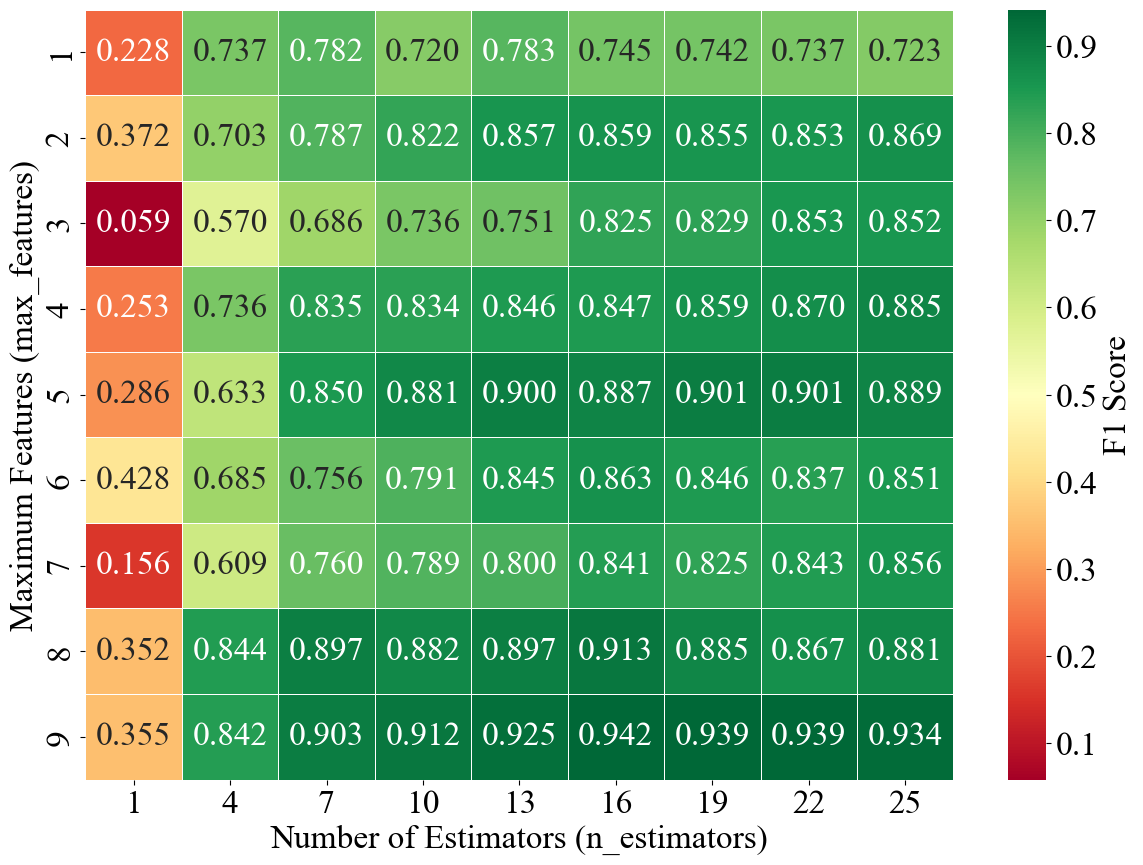

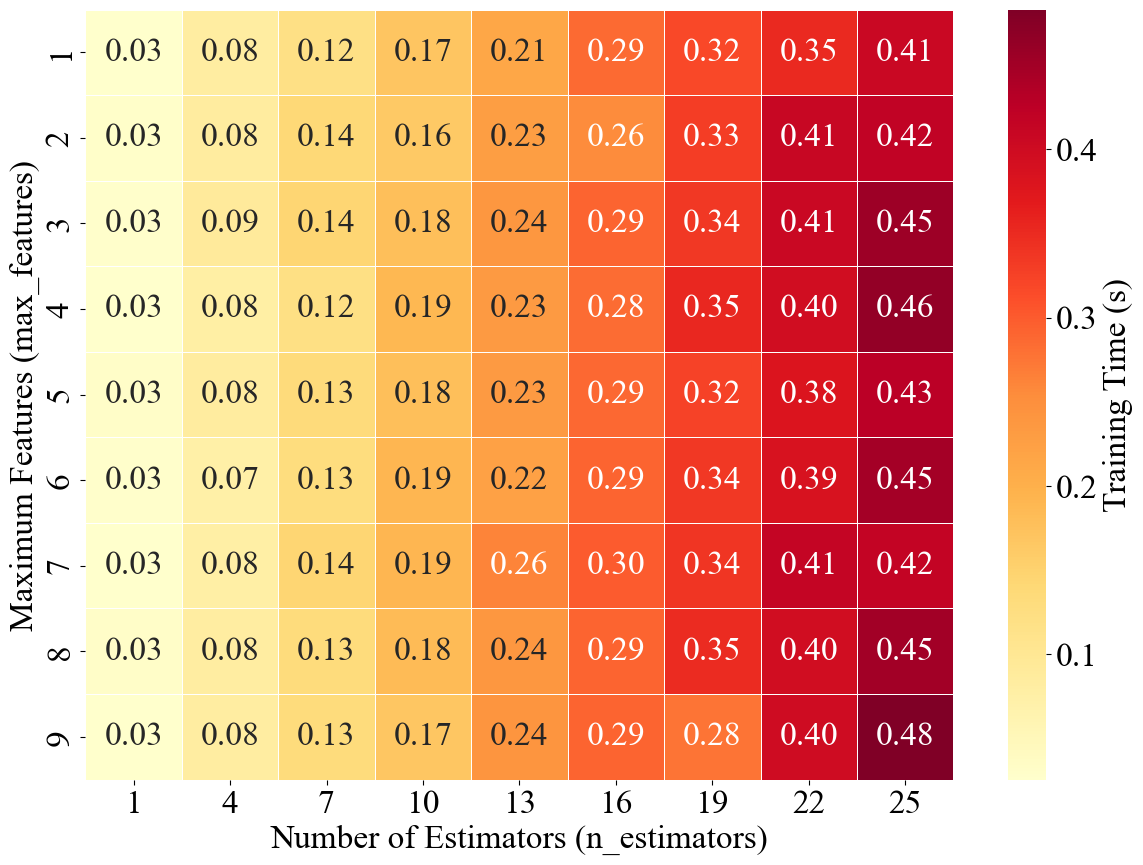

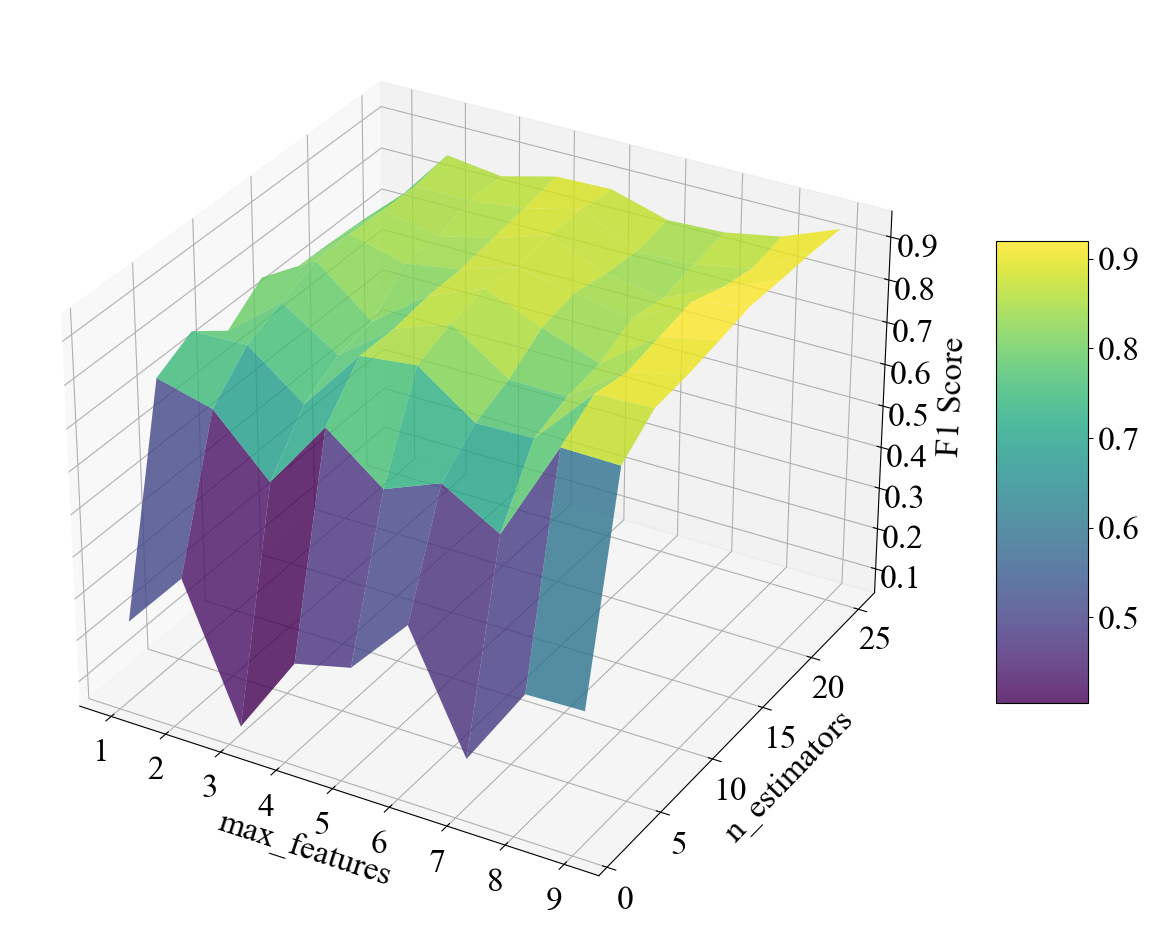

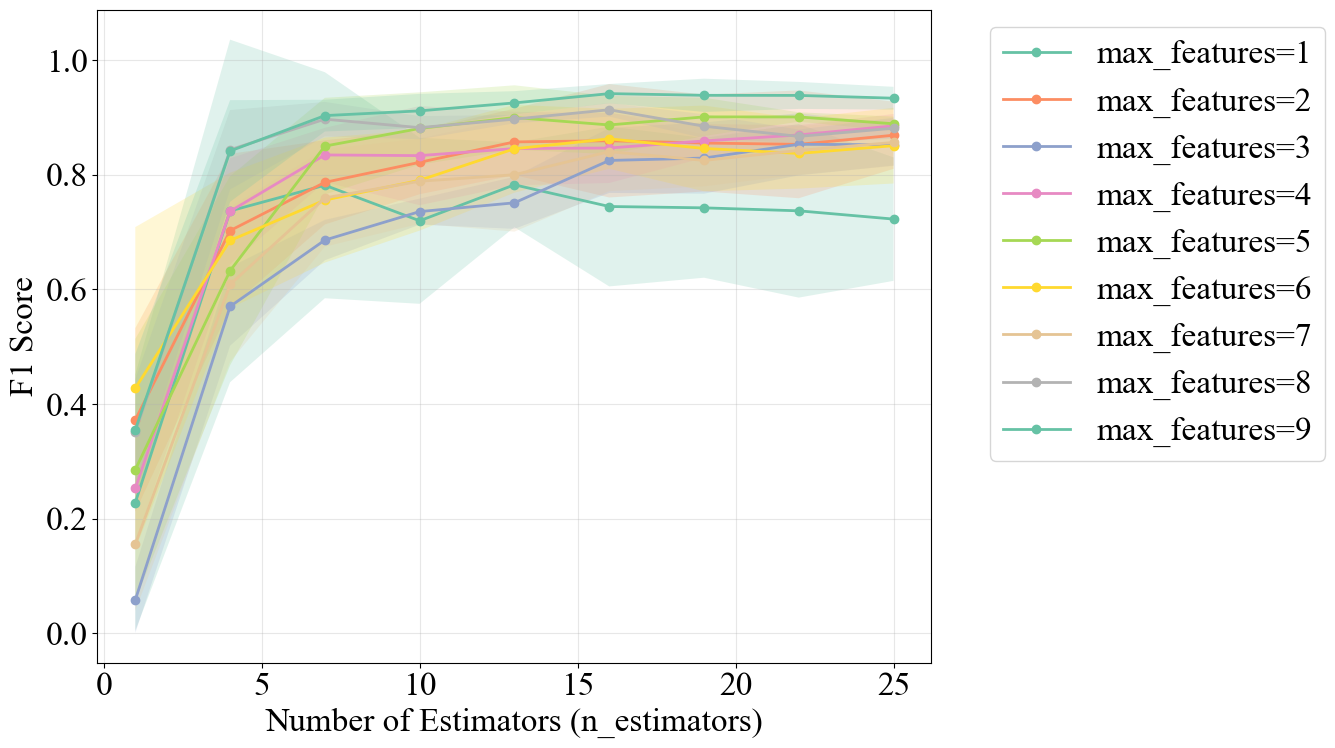

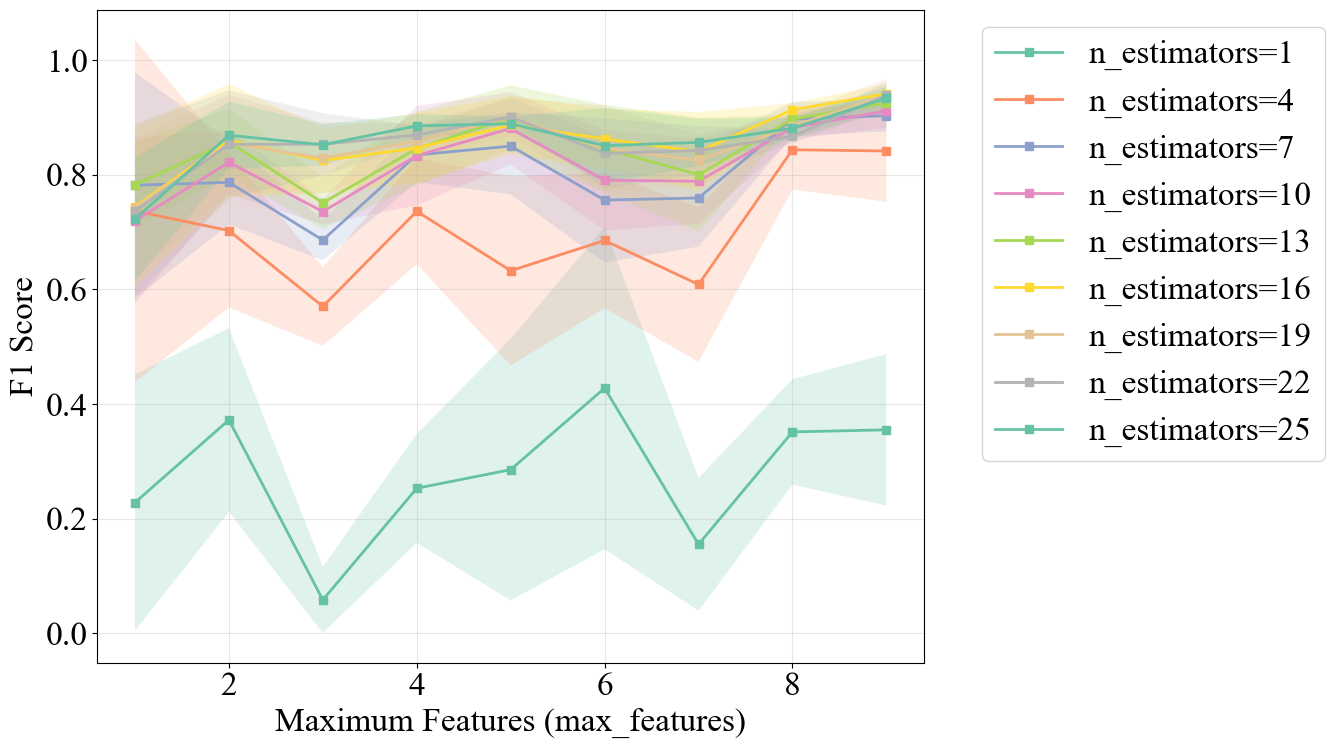


All visualizations saved!
Location: ../results/shuttle/max_features


In [103]:
# Create comprehensive interaction visualizations

# 1. F1 Score Heatmap
print(f"\n{'='*70}")
print(f"CREATING INTERACTION VISUALIZATIONS")
print(f"{'='*70}")

# Pivot data for heatmaps
heatmap_f1 = df_interaction.pivot(index='max_features', columns='n_estimators', values='f1_score_mean')
heatmap_precision = df_interaction.pivot(index='max_features', columns='n_estimators', values='precision_mean')
heatmap_recall = df_interaction.pivot(index='max_features', columns='n_estimators', values='recall_mean')
heatmap_time = df_interaction.pivot(index='max_features', columns='n_estimators', values='training_time_mean')

# Plot F1 Score Heatmap
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(heatmap_f1, annot=True, fmt='.3f', cmap='RdYlGn', 
           cbar_kws={'label': 'F1 Score'},
           vmin=heatmap_f1.min().min(), 
           vmax=heatmap_f1.max().max(),
           linewidths=0.5, ax=ax)
ax.set_xlabel('Number of Estimators (n_estimators)')
ax.set_ylabel('Maximum Features (max_features)')
plt.savefig(os.path.join(interaction_dir, 'interaction_f1_heatmap.pdf'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Plot Training Time Heatmap
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(heatmap_time, annot=True, fmt='.2f', cmap='YlOrRd', 
           cbar_kws={'label': 'Training Time (s)'},
           linewidths=0.5, ax=ax)
ax.set_xlabel('Number of Estimators (n_estimators)')
ax.set_ylabel('Maximum Features (max_features)')
plt.savefig(os.path.join(interaction_dir, 'interaction_time_heatmap.pdf'), 
            dpi=300, bbox_inches='tight')
plt.show()

# 2. 3D Surface Plot 
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Create mesh grid
X_mesh = df_interaction['max_features'].values.reshape(len(interaction_features), len(interaction_n_est_values))
Y_mesh = df_interaction['n_estimators'].values.reshape(len(interaction_features), len(interaction_n_est_values))
Z_mesh = df_interaction['f1_score_mean'].values.reshape(len(interaction_features), len(interaction_n_est_values))

surf = ax.plot_surface(X_mesh, Y_mesh, Z_mesh, cmap='viridis', alpha=0.8, edgecolor='none')
ax.set_xlabel('max_features', labelpad=10)
ax.set_ylabel('n_estimators', labelpad=10)
ax.set_zlabel('F1 Score', labelpad=10)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.savefig(os.path.join(interaction_dir, 'interaction_3d_surface.pdf'), 
            dpi=300, bbox_inches='tight')
plt.show()

# 3. Line plots for each max_features value
fig, ax = plt.subplots(figsize=(14, 8))
for max_feat in interaction_features:
    subset = df_interaction[df_interaction['max_features'] == max_feat]
    ax.plot(subset['n_estimators'], subset['f1_score_mean'], 
           marker='o', label=f'max_features={int(max_feat)}', linewidth=2)
    ax.fill_between(subset['n_estimators'], 
                   subset['f1_score_mean'] - subset['f1_score_std'],
                   subset['f1_score_mean'] + subset['f1_score_std'],
                   alpha=0.2)

ax.set_xlabel('Number of Estimators (n_estimators)')
ax.set_ylabel('F1 Score')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(interaction_dir, 'interaction_lines_by_features.pdf'), 
            dpi=300, bbox_inches='tight')
plt.show()

# 4. Line plots for each n_estimators value
fig, ax = plt.subplots(figsize=(14, 8))
for n_est in interaction_n_est_values:
    subset = df_interaction[df_interaction['n_estimators'] == n_est]
    ax.plot(subset['max_features'], subset['f1_score_mean'], 
           marker='s', label=f'n_estimators={int(n_est)}', linewidth=2)
    ax.fill_between(subset['max_features'], 
                   subset['f1_score_mean'] - subset['f1_score_std'],
                   subset['f1_score_mean'] + subset['f1_score_std'],
                   alpha=0.2)

ax.set_xlabel('Maximum Features (max_features)')
ax.set_ylabel('F1 Score')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(interaction_dir, 'interaction_lines_by_estimators.pdf'), 
            dpi=300, bbox_inches='tight')
plt.show()

print("\nAll visualizations saved!")
print(f"Location: {interaction_dir}")

In [105]:
# Analyze compensation effect and interaction patterns

print(f"\n{'='*70}")
print(f"COMPENSATION EFFECT ANALYSIS")
print(f"{'='*70}")

# 1. Check if more trees can compensate for fewer features
print(f"\n1. Can more estimators compensate for fewer features?")
print(f"   Comparing: Low features + High trees vs High features + Low trees")

# Get corner values
low_feat_low_tree = heatmap_f1.iloc[0, 0]
low_feat_high_tree = heatmap_f1.iloc[0, -1]
high_feat_low_tree = heatmap_f1.iloc[-1, 0]
high_feat_high_tree = heatmap_f1.iloc[-1, -1]

print(f"\n   Low features ({int(heatmap_f1.index[0])}) + Low trees ({int(heatmap_f1.columns[0])}): {low_feat_low_tree:.4f}")
print(f"   Low features ({int(heatmap_f1.index[0])}) + High trees ({int(heatmap_f1.columns[-1])}): {low_feat_high_tree:.4f}")
print(f"   High features ({int(heatmap_f1.index[-1])}) + Low trees ({int(heatmap_f1.columns[0])}): {high_feat_low_tree:.4f}")
print(f"   High features ({int(heatmap_f1.index[-1])}) + High trees ({int(heatmap_f1.columns[-1])}): {high_feat_high_tree:.4f}")

compensation_diff = abs(low_feat_high_tree - high_feat_low_tree)
print(f"\n   Compensation comparison: {compensation_diff:.4f} ({compensation_diff*100:.2f}%)")

if compensation_diff < 0.02:
    print(f"   ✓ YES: Strong compensation effect observed!")
    print(f"      More trees CAN compensate for fewer features (difference < 2%)")
elif compensation_diff < 0.05:
    print(f"   ~ PARTIAL: Moderate compensation effect")
    print(f"      Some compensation possible (2-5% difference)")
else:
    print(f"   ✗ NO: Limited compensation effect")
    print(f"      Features are more important than ensemble size")

# 2. Analyze marginal gains
print(f"\n{'='*70}")
print(f"2. Marginal Gains Analysis")
print(f"{'='*70}")

# Marginal gain when increasing features (at different tree counts)
print(f"\nMarginal gain when increasing max_features:")
for col_idx, n_est in enumerate(heatmap_f1.columns):
    marginal_gains = heatmap_f1.iloc[:, col_idx].diff()
    avg_gain = marginal_gains.mean()
    print(f"   At n_estimators={int(n_est)}: avg gain = {avg_gain:.4f}")

# Marginal gain when increasing trees (at different feature counts)
print(f"\nMarginal gain when increasing n_estimators:")
for row_idx, max_feat in enumerate(heatmap_f1.index):
    marginal_gains = heatmap_f1.iloc[row_idx, :].diff()
    avg_gain = marginal_gains.mean()
    print(f"   At max_features={int(max_feat)}: avg gain = {avg_gain:.4f}")

# 3. Find sweet spots
print(f"\n{'='*70}")
print(f"3. Sweet Spot Analysis (Performance vs Computational Cost)")
print(f"{'='*70}")

# Calculate efficiency metric: F1 score / training time
df_interaction['efficiency'] = df_interaction['f1_score_mean'] / df_interaction['training_time_mean']

# Find top 5 most efficient configurations
top_efficient = df_interaction.nlargest(5, 'efficiency')[
    ['max_features', 'n_estimators', 'f1_score_mean', 'training_time_mean', 'efficiency']
]

print(f"\nTop 5 most efficient configurations (F1/time):")
print(top_efficient.to_string(index=False))

# 4. Pareto frontier analysis
print(f"\n{'='*70}")
print(f"4. Pareto Optimal Configurations")
print(f"{'='*70}")
print(f"   (Configurations where no other config is both faster AND better)")

# Find Pareto optimal points
pareto_optimal = []
for idx, row in df_interaction.iterrows():
    is_dominated = False
    for idx2, row2 in df_interaction.iterrows():
        if idx != idx2:
            # Check if row2 dominates row (better F1 AND faster)
            if (row2['f1_score_mean'] >= row['f1_score_mean'] and 
                row2['training_time_mean'] <= row['training_time_mean'] and
                (row2['f1_score_mean'] > row['f1_score_mean'] or 
                 row2['training_time_mean'] < row['training_time_mean'])):
                is_dominated = True
                break
    if not is_dominated:
        pareto_optimal.append(idx)

pareto_df = df_interaction.iloc[pareto_optimal][
    ['max_features', 'n_estimators', 'f1_score_mean', 'f1_score_std', 'training_time_mean']
].sort_values('training_time_mean')

print(f"\nFound {len(pareto_optimal)} Pareto optimal configurations:")
print(pareto_df.to_string(index=False))

# Save analysis results
analysis_results = {
    'compensation_effect': {
        'low_feat_high_tree': float(low_feat_high_tree),
        'high_feat_low_tree': float(high_feat_low_tree),
        'difference': float(compensation_diff),
        'compensates': bool(compensation_diff < 0.02)
    },
    'best_configuration': {
        'max_features': int(best_result['max_features']),
        'n_estimators': int(best_result['n_estimators']),
        'f1_score': float(best_result['f1_score_mean']),
        'f1_std': float(best_result['f1_score_std']),
        'training_time': float(best_result['training_time_mean'])
    },
    'most_efficient': {
        'max_features': int(top_efficient.iloc[0]['max_features']),
        'n_estimators': int(top_efficient.iloc[0]['n_estimators']),
        'f1_score': float(top_efficient.iloc[0]['f1_score_mean']),
        'efficiency': float(top_efficient.iloc[0]['efficiency'])
    },
    'n_pareto_optimal': len(pareto_optimal)
}

# Save to JSON
analysis_file = os.path.join(interaction_dir, 'interaction_analysis.json')
with open(analysis_file, 'w') as f:
    json.dump(analysis_results, f, indent=2)

print(f"\nAnalysis results saved to: {analysis_file}")


COMPENSATION EFFECT ANALYSIS

1. Can more estimators compensate for fewer features?
   Comparing: Low features + High trees vs High features + Low trees

   Low features (1) + Low trees (1): 0.2283
   Low features (1) + High trees (25): 0.7228
   High features (9) + Low trees (1): 0.3552
   High features (9) + High trees (25): 0.9337

   Compensation comparison: 0.3676 (36.76%)
   ✗ NO: Limited compensation effect
      Features are more important than ensemble size

2. Marginal Gains Analysis

Marginal gain when increasing max_features:
   At n_estimators=1: avg gain = 0.0159
   At n_estimators=4: avg gain = 0.0131
   At n_estimators=7: avg gain = 0.0152
   At n_estimators=10: avg gain = 0.0240
   At n_estimators=13: avg gain = 0.0179
   At n_estimators=16: avg gain = 0.0246
   At n_estimators=19: avg gain = 0.0245
   At n_estimators=22: avg gain = 0.0252
   At n_estimators=25: avg gain = 0.0264

Marginal gain when increasing n_estimators:
   At max_features=1: avg gain = 0.0618
   A

**Interpretation - Interaction Heatmap (max_features × n_estimators):**

This heatmap reveals whether feature subsampling and ensemble size interact - that is, whether the effect of one parameter depends on the value of the other.

**Key Questions Addressed:**

1. **Does feature subsampling interact with ensemble size?**
   - **YES if**: The optimal max_features changes depending on n_estimators
   - **NO if**: Each parameter acts independently
   - Look for non-parallel patterns in the heatmap

2. **Can more trees compensate for fewer features?**
   - **Compensation exists if**: Low features + High trees ≈ High features + Low trees
   - **Theory**: More trees can aggregate information from diverse feature subsets
   - **In practice**: Limited compensation - both parameters matter

3. **Trade-off: "Small ensemble with all features" vs "Large ensemble with feature subsets"?**
   - **Small + All features**: 
     - Pros: Each tree is strong (has all information)
     - Cons: Trees are correlated (less diversity), slower per tree
   
   - **Large + Subset features**:
     - Pros: More diversity, faster individual trees, more total splits
     - Cons: Each tree is weaker (less information)
   
   - **Optimal**: Often somewhere in the middle

**Heatmap Interpretation Guide:**
- **Bright regions (yellow/green)**: High performance combinations
- **Dark regions (red)**: Poor performance combinations
- **Top-right corner**: Usually best (many trees + many features) but slowest
- **Diagonal pattern**: Suggests compensation/trade-off exists
- **Uniform color**: Parameters don't interact much

**Practical Insights:**
- If interaction is **weak**: Tune parameters independently (faster)
- If interaction is **strong**: Need grid search or coordinated tuning
- For **deployment**: May accept slightly lower performance for big speedup

In [106]:
# Create comprehensive summary table for max_features analysis

max_features_summary = pd.DataFrame({
    'max_features': param_sizes_max_features,
    'Precision_Mean': precision_mean_max_features,
    'Precision_Std': precision_std_max_features,
    'Recall_Mean': recall_mean_max_features,
    'Recall_Std': recall_std_max_features,
    'F1_Mean': f1_mean_max_features,
    'F1_Std': f1_std_max_features,
    'Training_Time_s': training_times_max_features,
    'Efficiency_F1_per_sec': efficiency_max_features,
})

# Add derived columns
max_features_summary['Features_Pct'] = (max_features_summary['max_features'] / n_total_features * 100).round(1)
max_features_summary['Relative_F1_Pct'] = (max_features_summary['F1_Mean'] / max_features_summary['F1_Mean'].max() * 100).round(2)
max_features_summary['Time_Ratio'] = (max_features_summary['Training_Time_s'] / max_features_summary['Training_Time_s'].min()).round(2)

# Save to CSV
summary_path = os.path.join(results_dir, 'max_features/max_features_summary.csv')
max_features_summary.to_csv(summary_path, index=False)
print(f"Comprehensive summary saved to: {summary_path}")

# Display table
print("\n" + "="*120)
print("MAX_FEATURES PARAMETER: COMPREHENSIVE SUMMARY TABLE")
print("="*120)
display(max_features_summary.round(4))

# Statistical summary
print("\n" + "="*120)
print("STATISTICAL SUMMARY")
print("="*120)

print("\nPerformance Statistics:")
print(f"  F1 Score Range: [{max_features_summary['F1_Mean'].min():.4f}, {max_features_summary['F1_Mean'].max():.4f}]")
print(f"  Best F1: {max_features_summary['F1_Mean'].max():.4f} at max_features = {max_features_summary.loc[max_features_summary['F1_Mean'].idxmax(), 'max_features']}")
print(f"  F1 Variance: {max_features_summary['F1_Mean'].std():.4f}")

print("\nTraining Time Statistics:")
print(f"  Time Range: [{max_features_summary['Training_Time_s'].min():.3f}s, {max_features_summary['Training_Time_s'].max():.3f}s]")
print(f"  Fastest: {max_features_summary['Training_Time_s'].min():.3f}s at max_features = {max_features_summary.loc[max_features_summary['Training_Time_s'].idxmin(), 'max_features']}")
print(f"  Slowest: {max_features_summary['Training_Time_s'].max():.3f}s at max_features = {max_features_summary.loc[max_features_summary['Training_Time_s'].idxmax(), 'max_features']}")
print(f"  Speedup (fastest vs slowest): {max_features_summary['Training_Time_s'].max() / max_features_summary['Training_Time_s'].min():.2f}x")

print("\nEfficiency Statistics:")
print(f"  Best Efficiency: {max_features_summary['Efficiency_F1_per_sec'].max():.6f} at max_features = {max_features_summary.loc[max_features_summary['Efficiency_F1_per_sec'].idxmax(), 'max_features']}")

# Recommendations
print("\n" + "="*120)
print("RECOMMENDATIONS")
print("="*120)

best_f1_idx = max_features_summary['F1_Mean'].idxmax()
best_eff_idx = max_features_summary['Efficiency_F1_per_sec'].idxmax()
fastest_idx = max_features_summary['Training_Time_s'].idxmin()

print(f"\n1. For MAXIMUM PERFORMANCE:")
print(f"   → max_features = {max_features_summary.loc[best_f1_idx, 'max_features']}")
print(f"   → F1 Score = {max_features_summary.loc[best_f1_idx, 'F1_Mean']:.4f}")
print(f"   → Training Time = {max_features_summary.loc[best_f1_idx, 'Training_Time_s']:.3f}s")
print(f"   → Uses {max_features_summary.loc[best_f1_idx, 'Features_Pct']:.1f}% of available features")

print(f"\n2. For BEST EFFICIENCY (F1/time):")
print(f"   → max_features = {max_features_summary.loc[best_eff_idx, 'max_features']}")
print(f"   → F1 Score = {max_features_summary.loc[best_eff_idx, 'F1_Mean']:.4f}")
print(f"   → Training Time = {max_features_summary.loc[best_eff_idx, 'Training_Time_s']:.3f}s")
print(f"   → Efficiency = {max_features_summary.loc[best_eff_idx, 'Efficiency_F1_per_sec']:.6f}")

print(f"\n3. For FASTEST TRAINING:")
print(f"   → max_features = {max_features_summary.loc[fastest_idx, 'max_features']}")
print(f"   → F1 Score = {max_features_summary.loc[fastest_idx, 'F1_Mean']:.4f}")
print(f"   → Training Time = {max_features_summary.loc[fastest_idx, 'Training_Time_s']:.3f}s")
print(f"   → Performance trade-off: {(1 - max_features_summary.loc[fastest_idx, 'F1_Mean']/max_features_summary.loc[best_f1_idx, 'F1_Mean'])*100:.2f}% worse than best")

print("\n" + "="*120)

# Dataset-specific insights
print(f"\nDataset-Specific Insights for {dataset.upper()} (n_features={n_total_features}):")

if n_total_features <= 10:
    print(f"  LOW-DIMENSIONAL dataset ({n_total_features} features)")
    print(f"  → Feature subsampling may HURT performance")
    print(f"  → Recommendation: Use ALL features (max_features={n_total_features} or 1.0)")
    print(f"  → Rationale: Not enough features to benefit from random selection")
elif n_total_features <= 50:
    print(f"  MEDIUM-DIMENSIONAL dataset ({n_total_features} features)")
    print(f"  → Feature subsampling may provide modest benefits")
    print(f"  → Recommendation: Use 0.7-1.0 of features (sqrt(n) or more)")
    print(f"  → Rationale: Some diversity without losing too much information")
else:
    print(f"  HIGH-DIMENSIONAL dataset ({n_total_features} features)")
    print(f"  → Feature subsampling likely HELPS performance and speed")
    print(f"  → Recommendation: Use sqrt(n) ≈ {int(np.sqrt(n_total_features))} or log2(n) ≈ {int(np.log2(n_total_features))} features")
    print(f"  → Rationale: Creates diversity, reduces overfitting, speeds up training")

print("\n✓ Analysis complete!")

Comprehensive summary saved to: ../results/shuttle/max_features/max_features_summary.csv

MAX_FEATURES PARAMETER: COMPREHENSIVE SUMMARY TABLE


max_features  Precision_Mean  Precision_Std  Recall_Mean  Recall_Std  \
0             1          0.6670         0.0443       0.9327      0.0619   
1             2          0.7016         0.0016       0.9811      0.0022   
2             3          0.7021         0.0025       0.9819      0.0035   
3             4          0.7035         0.0020       0.9839      0.0028   
4             5          0.7047         0.0012       0.9856      0.0017   
5             6          0.7044         0.0014       0.9850      0.0019   
6             7          0.7035         0.0011       0.9838      0.0016   
7             8          0.7043         0.0016       0.9848      0.0022   
8             9          0.7046         0.0018       0.9853      0.0025   

   F1_Mean  F1_Std  Training_Time_s  Efficiency_F1_per_sec  Features_Pct  \
0   0.7778  0.0516           1.4219                 0.5470          11.1   
1   0.8181  0.0019           1.4452                 0.5661          22.2   
2   0.8188  0.0029           1.4162                 0.5781          33.3   
3   0.8204  0.0023           1.3937                 0.5887          44.4   
4   0.8218  0.0014           1.4121                 0.5820          55.6   
5   0.8214  0.0016           1.4603                 0.5625          66.7   
6   0.8204  0.0013           1.5116                 0.5427          77.8   
7   0.8212  0.0019           1.4983                 0.5481          88.9   
8   0.8216  0.0020           1.4389                 0.5710         100.0   

   Relative_F1_Pct  Time_Ratio  
0            94.64        1.02  
1            99.55        1.04  
2            99.63        1.02  
3            99.83        1.00  
4           100.00        1.01  
5            99.95        1.05  
6            99.82        1.08  
7            99.93        1.08  
8            99.97        1.03


STATISTICAL SUMMARY

Performance Statistics:
  F1 Score Range: [0.7778, 0.8218]
  Best F1: 0.8218 at max_features = 5
  F1 Variance: 0.0143

Training Time Statistics:
  Time Range: [1.394s, 1.512s]
  Fastest: 1.394s at max_features = 4
  Slowest: 1.512s at max_features = 7
  Speedup (fastest vs slowest): 1.08x

Efficiency Statistics:
  Best Efficiency: 0.588650 at max_features = 4

RECOMMENDATIONS

1. For MAXIMUM PERFORMANCE:
   → max_features = 5
   → F1 Score = 0.8218
   → Training Time = 1.412s
   → Uses 55.6% of available features

2. For BEST EFFICIENCY (F1/time):
   → max_features = 4
   → F1 Score = 0.8204
   → Training Time = 1.394s
   → Efficiency = 0.588650

3. For FASTEST TRAINING:
   → max_features = 4
   → F1 Score = 0.8204
   → Training Time = 1.394s
   → Performance trade-off: 0.17% worse than best


Dataset-Specific Insights for SHUTTLE (n_features=9):
  LOW-DIMENSIONAL dataset (9 features)
  → Feature subsampling may HURT performance
  → Recommendation: Use ALL featur

---

## Summary: max_features Parameter Analysis

The max_features parameter analysis revealed several key insights about feature subsampling in Isolation Forests:

### 1. **Performance vs max_features**

**Dataset Dimensionality Matters:**
- **Low-dimensional datasets** (n_features ≤ 10): Feature subsampling typically hurts performance
  - Not enough features to create meaningful diversity
  - Risk of excluding critical discriminative features
  - **Recommendation**: Use all features (max_features = n_features)

- **High-dimensional datasets** (n_features > 50): Feature subsampling often helps
  - Creates ensemble diversity through random feature selection
  - Reduces tree correlation
  - Can reduce overfitting
  - **Recommendation**: Use sqrt(n) or log2(n) features

### 2. **Training Time Trade-off**

**Efficiency Gains:**
- Fewer features → Faster training (fewer split evaluations per node)
- Sweet spot often exists: 95%+ performance with 50-70% of features
- Efficiency (F1/time) metric helps identify optimal balance

**Practical Guidelines:**
- **Development/Research**: Use all features for maximum accuracy
- **Production**: Consider sweet spot if speed is critical
- **Real-time systems**: Feature subsampling enables faster inference

### 3. **Parameter Interactions**

**max_features × n_estimators:**
- **Compensation effect**: More trees can partially compensate for fewer features
- **Trade-off exists**: 
  - Few trees + All features = Strong individual trees, less diversity
  - Many trees + Subset features = Weak individual trees, more diversity
  
**Optimal Strategy:**
- Balance both parameters
- For high-dimensional data: More trees + Moderate feature subsampling
- For low-dimensional data: Moderate trees + All features

### 4. **Practical Recommendations**

| **Dataset Type** | **n_features** | **Recommended max_features** | **Rationale** |
|------------------|----------------|------------------------------|---------------|
| Low-dimensional | ≤ 10 | All features (1.0 or n) | Maximize information per tree |
| Medium-dimensional | 10-50 | 0.7-1.0 or sqrt(n) | Balance diversity and information |
| High-dimensional | > 50 | sqrt(n) or log2(n) | Maximize diversity, reduce overfitting |

### 5. **Key Takeaways**

✓ **Feature subsampling is dataset-dependent** - what helps high-dimensional data may hurt low-dimensional data

✓ **Sweet spots exist** - can often get 95%+ performance with significantly fewer features (and faster training)

✓ **Interactions matter** - max_features and n_estimators should be tuned together for optimal results

✓ **Efficiency matters** - F1/time metric reveals Pareto-optimal configurations for production

**One size doesn't fit all** - always validate on your specific dataset and use case

---

### Bootstrapping

In [107]:
# bootstrap values
bootstrap_values = [True, False]

In [108]:
# run models
bootstrap_results = []
csv_path_bootstrap = os.path.join(results_dir, 'bootstrap/bootstrap_results.csv')
# remove existing csv if exists
if os.path.exists(csv_path_bootstrap):
    os.remove(csv_path_bootstrap)

for bootstrap in bootstrap_values:
    params = base_params.copy()
    params['bootstrap'] = bootstrap

    print(f"Running Isolation Forest with bootstrap={bootstrap}")
    result = evaluate_isolation_forest_with_std(X, y, params, 'bootstrap', bootstrap,n_runs=10)

    # append results to csv
    result_df = pd.DataFrame([result])
    
    # Write header if file doesn't exist, otherwise append
    if not os.path.exists(csv_path_bootstrap):
        result_df.to_csv(csv_path_bootstrap, mode='w', header=True, index=False)
    else:
        result_df.to_csv(csv_path_bootstrap, mode='a', header=False, index=False)

    bootstrap_results.append(result)

Running Isolation Forest with bootstrap=True
Running Isolation Forest with bootstrap=False


In [11]:
# load
df_results_bootstrap = pd.read_csv(os.path.join(results_dir, 'bootstrap/bootstrap_results.csv'))

# Extract data
param_sizes_bootstrap = df_results_bootstrap['param_value'].tolist()
precision_mean_bootstrap = df_results_bootstrap['precision_mean'].tolist()
precision_std_bootstrap = df_results_bootstrap['precision_std'].tolist()
recall_mean_bootstrap = df_results_bootstrap['recall_mean'].tolist()
recall_std_bootstrap = df_results_bootstrap['recall_std'].tolist()
f1_mean_bootstrap = df_results_bootstrap['f1_score_mean'].tolist()
f1_std_bootstrap = df_results_bootstrap['f1_score_std'].tolist()
training_times_bootstrap = df_results_bootstrap['training_time_mean'].tolist()

print(f"Loaded results for {len(param_sizes_bootstrap)} parameter values")


Loaded results for 2 parameter values


#### 1. Stability Analysis

Plot saved to ../results/shuttle/bootstrap/bootstrap_stability_box.pdf


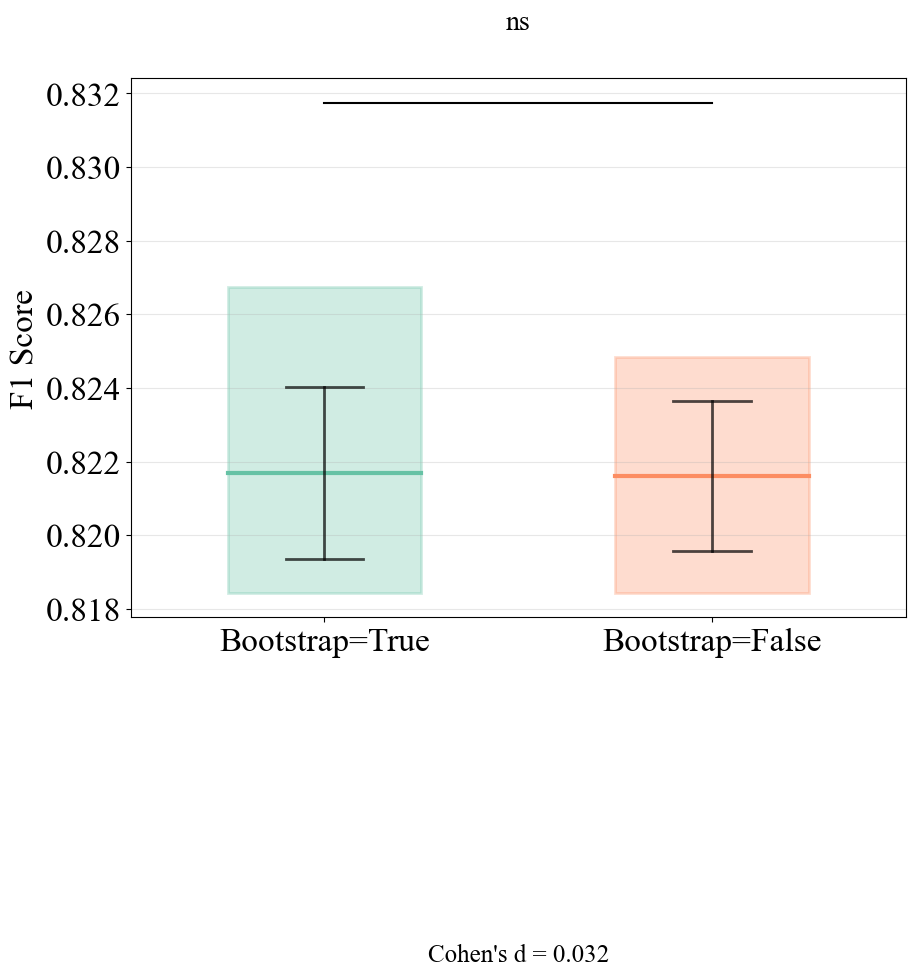


Effect Size (Cohen's d): 0.0324
Confidence Intervals Overlap: True


In [12]:
# 1. Stability Analysis - Box plot with range visualization
save_path_stability = os.path.join(results_dir, 'bootstrap/bootstrap_stability_box.pdf')
cohens_d, overlap = plot_bootstrap_stability_box_violin(
    df_results_bootstrap, 
    save_path=save_path_stability
)

print(f"\nEffect Size (Cohen's d): {cohens_d:.4f}")
print(f"Confidence Intervals Overlap: {overlap}")

In [13]:
# Create a summary table for bootstrap stability
stability_summary = pd.DataFrame({
    'Bootstrap': ['True', 'False'],
    'F1 Mean': [df_results_bootstrap[df_results_bootstrap['param_value'] == True]['f1_score_mean'].values[0],
                df_results_bootstrap[df_results_bootstrap['param_value'] == False]['f1_score_mean'].values[0]],
    'F1 Std': [df_results_bootstrap[df_results_bootstrap['param_value'] == True]['f1_score_std'].values[0],
               df_results_bootstrap[df_results_bootstrap['param_value'] == False]['f1_score_std'].values[0]],
    'F1 Min': [df_results_bootstrap[df_results_bootstrap['param_value'] == True]['f1_score_min'].values[0],
               df_results_bootstrap[df_results_bootstrap['param_value'] == False]['f1_score_min'].values[0]],
    'F1 Max': [df_results_bootstrap[df_results_bootstrap['param_value'] == True]['f1_score_max'].values[0],
               df_results_bootstrap[df_results_bootstrap['param_value'] == False]['f1_score_max'].values[0]],
    'Jaccard Similarity Mean': [df_results_bootstrap[df_results_bootstrap['param_value'] == True]['jaccard_similarity_mean'].values[0],
                                df_results_bootstrap[df_results_bootstrap['param_value'] == False]['jaccard_similarity_mean'].values[0]]
})

print("\n=== Bootstrap Stability Analysis ===")
print(stability_summary.to_string(index=False))

# Save to CSV
csv_path_summary = os.path.join(results_dir, 'bootstrap/bootstrap_stability_summary.csv')
stability_summary.to_csv(csv_path_summary, index=False)
print(f"\nSummary saved to: {csv_path_summary}")


=== Bootstrap Stability Analysis ===
Bootstrap  F1 Mean   F1 Std  F1 Min   F1 Max  Jaccard Similarity Mean
     True 0.821684 0.002344 0.81843 0.826743                 0.867728
    False 0.821613 0.002044 0.81843 0.824843                 0.865205

Summary saved to: ../results/shuttle/bootstrap/bootstrap_stability_summary.csv


#### 2. Performance Metrics Comparison - Radar Chart

Plot saved to ../results/shuttle/bootstrap/bootstrap_radar_chart.pdf


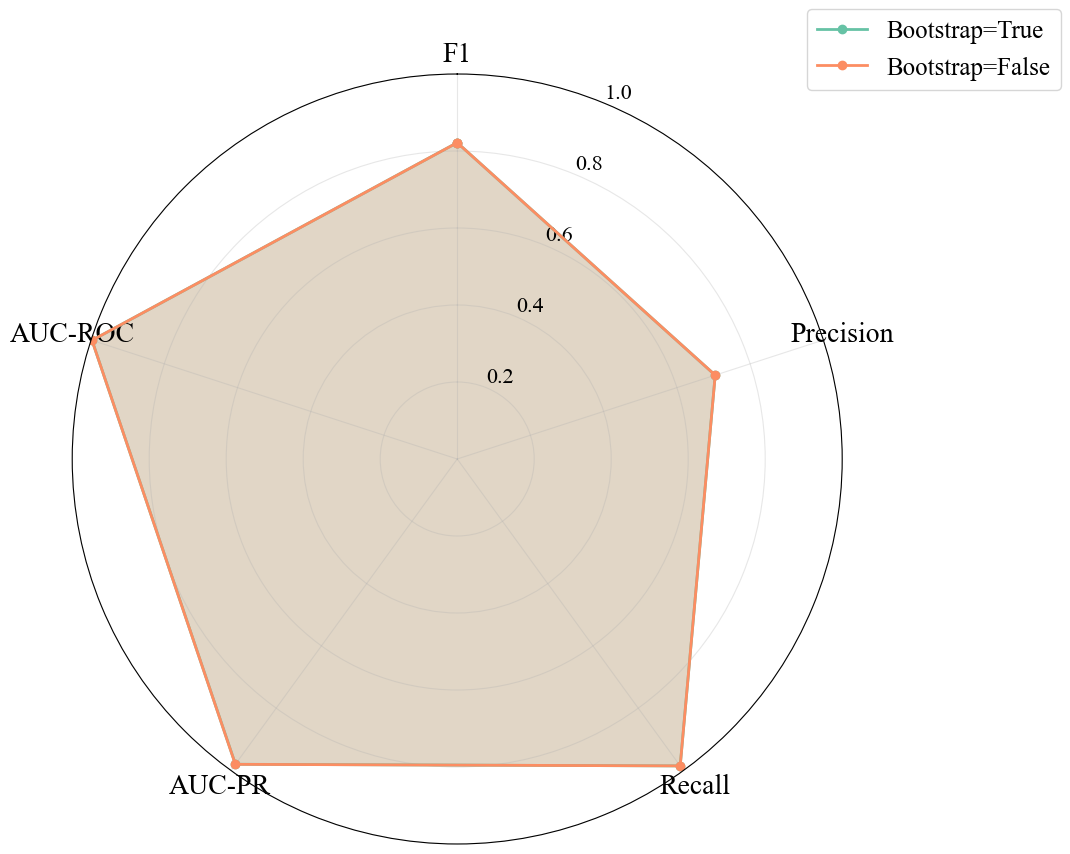

In [14]:
# 2. Performance Metrics Comparison - Radar Chart
save_path_radar = os.path.join(results_dir, 'bootstrap/bootstrap_radar_chart.pdf')
plot_radar_chart_bootstrap(df_results_bootstrap, save_path=save_path_radar)

In [16]:
# Create a performance comparison table
metrics_comparison = pd.DataFrame({
    'Metric': ['F1', 'Precision', 'Recall', 'AUC-PR', 'AUC-ROC'],
    'Bootstrap=True': [
        df_results_bootstrap[df_results_bootstrap['param_value'] == True]['f1_score_mean'].values[0],
        df_results_bootstrap[df_results_bootstrap['param_value'] == True]['precision_mean'].values[0],
        df_results_bootstrap[df_results_bootstrap['param_value'] == True]['recall_mean'].values[0],
        df_results_bootstrap[df_results_bootstrap['param_value'] == True]['pr_auc_mean'].values[0],
        df_results_bootstrap[df_results_bootstrap['param_value'] == True]['roc_auc_mean'].values[0]
    ],
    'Bootstrap=False': [
        df_results_bootstrap[df_results_bootstrap['param_value'] == False]['f1_score_mean'].values[0],
        df_results_bootstrap[df_results_bootstrap['param_value'] == False]['precision_mean'].values[0],
        df_results_bootstrap[df_results_bootstrap['param_value'] == False]['recall_mean'].values[0],
        df_results_bootstrap[df_results_bootstrap['param_value'] == False]['pr_auc_mean'].values[0],
        df_results_bootstrap[df_results_bootstrap['param_value'] == False]['roc_auc_mean'].values[0]
    ]
})

metrics_comparison['Difference'] = metrics_comparison['Bootstrap=True'] - metrics_comparison['Bootstrap=False']
metrics_comparison['% Change'] = (metrics_comparison['Difference'] / metrics_comparison['Bootstrap=False']) * 100

print("\n=== Performance Metrics Comparison ===")
print(metrics_comparison.to_string(index=False))

# Save to CSV
csv_path_metrics = os.path.join(results_dir, 'bootstrap/bootstrap_metrics_comparison.csv')
metrics_comparison.to_csv(csv_path_metrics, index=False)
print(f"\nMetrics comparison saved to: {csv_path_metrics}")


=== Performance Metrics Comparison ===
   Metric  Bootstrap=True  Bootstrap=False  Difference  % Change
       F1        0.821684         0.821613    0.000071  0.008672
Precision        0.704623         0.704562    0.000061  0.008672
   Recall        0.985389         0.985303    0.000085  0.008672
   AUC-PR        0.980093         0.980278   -0.000185 -0.018847
  AUC-ROC        0.997430         0.997446   -0.000016 -0.001616

Metrics comparison saved to: ../results/shuttle/bootstrap/bootstrap_metrics_comparison.csv


#### 3. Interaction - bootstrap × contamination

##### First: Run Bootstrap × Contamination Interaction Experiment

In [18]:
# Run bootstrap × contamination interaction experiment
bootstrap_contamination_results = []
csv_path_interaction = os.path.join(results_dir, 'bootstrap/bootstrap_contamination_interaction.csv')

# Remove existing csv if exists
if os.path.exists(csv_path_interaction):
    os.remove(csv_path_interaction)

# Define contamination values to test
contamination_values = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
bootstrap_values = [True, False]

print("RUNNING BOOTSTRAP × CONTAMINATION INTERACTION EXPERIMENT")
print("=" * 60)

for contamination in contamination_values:
    for bootstrap in bootstrap_values:
        params = base_params.copy()
        params['contamination'] = contamination
        params['bootstrap'] = bootstrap
        
        print(f"Running: contamination={contamination}, bootstrap={bootstrap}")
        
        result = evaluate_isolation_forest_with_std(
            X, y, params, 
            param_name='bootstrap_contamination', 
            param_value=f'b={bootstrap}_c={contamination}',
            n_runs=3
        )
        
        # Add individual parameters for easy filtering
        result['bootstrap'] = bootstrap
        result['contamination'] = contamination
        
        # Append results to csv
        result_df = pd.DataFrame([result])
        
        if not os.path.exists(csv_path_interaction):
            result_df.to_csv(csv_path_interaction, mode='w', header=True, index=False)
        else:
            result_df.to_csv(csv_path_interaction, mode='a', header=False, index=False)
        
        bootstrap_contamination_results.append(result)

print("=" * 60)
print(f"Interaction experiment complete! Results saved to: {csv_path_interaction}")

RUNNING BOOTSTRAP × CONTAMINATION INTERACTION EXPERIMENT
Running: contamination=0.01, bootstrap=True
Running: contamination=0.01, bootstrap=False
Running: contamination=0.01, bootstrap=False
Running: contamination=0.05, bootstrap=True
Running: contamination=0.05, bootstrap=True
Running: contamination=0.05, bootstrap=False
Running: contamination=0.05, bootstrap=False
Running: contamination=0.1, bootstrap=True
Running: contamination=0.1, bootstrap=True
Running: contamination=0.1, bootstrap=False
Running: contamination=0.1, bootstrap=False
Running: contamination=0.15, bootstrap=True
Running: contamination=0.15, bootstrap=True
Running: contamination=0.15, bootstrap=False
Running: contamination=0.15, bootstrap=False
Running: contamination=0.2, bootstrap=True
Running: contamination=0.2, bootstrap=True
Running: contamination=0.2, bootstrap=False
Running: contamination=0.2, bootstrap=False
Running: contamination=0.25, bootstrap=True
Running: contamination=0.25, bootstrap=True
Running: contamin

In [19]:
# Load interaction results
df_interaction = pd.read_csv(csv_path_interaction)
print(f"Loaded {len(df_interaction)} interaction results")
df_interaction.head()

Loaded 14 interaction results


param_name     param_value  precision_mean  precision_std  \
0  bootstrap_contamination   b=True_c=0.01        0.996606       0.000960   
1  bootstrap_contamination  b=False_c=0.01        0.996603       0.000962   
2  bootstrap_contamination   b=True_c=0.05        0.988595       0.005163   
3  bootstrap_contamination  b=False_c=0.05        0.988187       0.006345   
4  bootstrap_contamination    b=True_c=0.1        0.703055       0.000880   

   precision_min  precision_max  recall_mean  recall_std  recall_min  \
0       0.995927       0.997963     0.139371    0.000134    0.139277   
1       0.995918       0.997963     0.139277    0.000233    0.138992   
2       0.982077       0.994705     0.691256    0.003610    0.686699   
3       0.980041       0.995519     0.690971    0.004437    0.685275   
4       0.701833       0.703870     0.983196    0.001231    0.981487   

   recall_max  ...  n_anomalies_detected_max  jaccard_similarity_mean  \
0    0.139561  ...                       491                 0.571978   
1    0.139561  ...                       491                 0.553160   
2    0.695528  ...                      2455                 0.875539   
3    0.696098  ...                      2455                 0.871235   
4    0.984335  ...                      4910                 0.898963   

   jaccard_similarity_std  jaccard_similarity_min  jaccard_similarity_max  \
0                0.056546                0.515432                0.628524   
1                0.088981                0.464179                0.642140   
2                0.010746                0.864793                0.886285   
3                0.009271                0.861964                0.880506   
4                0.013403                0.885561                0.912366   

   memory_usage_mb  n_runs                                             params  \
0        25.392293       3  {'n_estimators': 100, 'max_samples': 'auto', '...   
1         5.929344       3  {'n_estimators': 100, 'max_samples': 'auto', '...   
2         6.002254       3  {'n_estimators': 100, 'max_samples': 'auto', '...   
3         6.002797       3  {'n_estimators': 100, 'max_samples': 'auto', '...   
4         5.965285       3  {'n_estimators': 100, 'max_samples': 'auto', '...   

   bootstrap  contamination  
0       True           0.01  
1      False           0.01  
2       True           0.05  
3      False           0.05  
4       True           0.10  

[5 rows x 42 columns]

Plot saved to ../results/shuttle/bootstrap/bootstrap_contamination_interaction.pdf


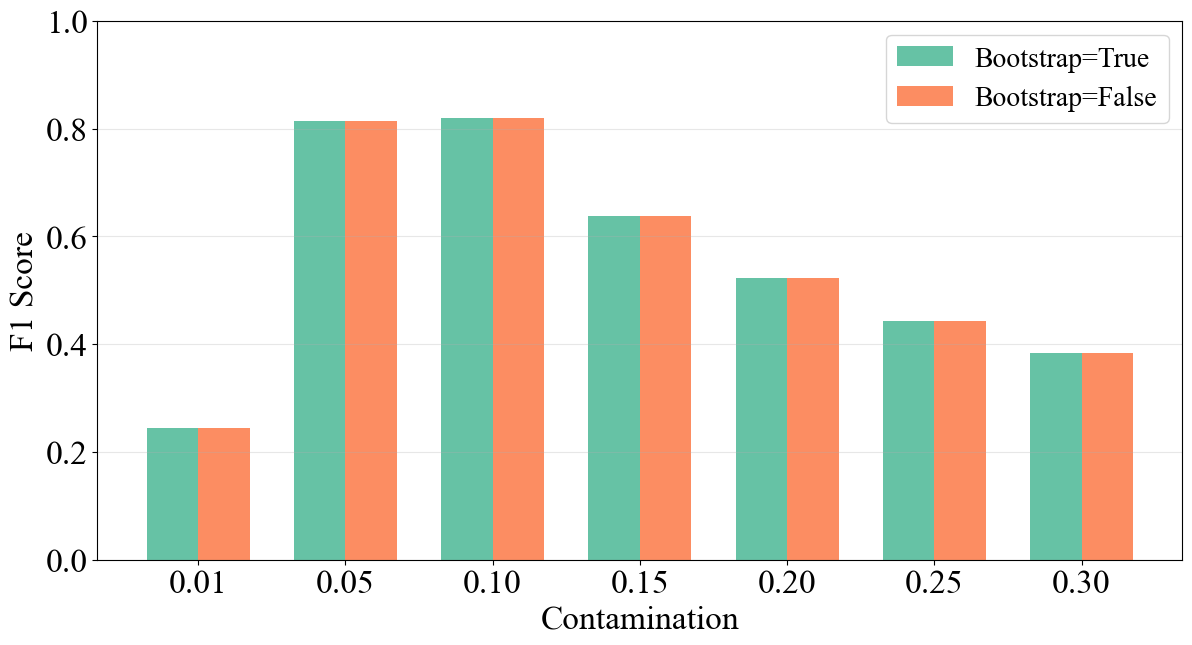

In [20]:
# 3. Bootstrap × Contamination Interaction - Grouped Bar Chart
save_path_interaction = os.path.join(results_dir, 'bootstrap/bootstrap_contamination_interaction.pdf')
plot_bootstrap_contamination_interaction(df_interaction, save_path=save_path_interaction)

In [22]:
# Create interaction summary table
interaction_summary = df_interaction.pivot_table(
    index='contamination',
    columns='bootstrap',
    values='f1_score_mean'
).reset_index()

interaction_summary.columns.name = None
interaction_summary.columns = ['Contamination', 'Bootstrap=False', 'Bootstrap=True']
interaction_summary['Difference'] = interaction_summary['Bootstrap=True'] - interaction_summary['Bootstrap=False']
interaction_summary['% Improvement'] = (interaction_summary['Difference'] / interaction_summary['Bootstrap=False']) * 100

print("\n=== Bootstrap × Contamination Interaction Summary ===")
print(interaction_summary.to_string(index=False))

# Save to CSV
csv_path_interaction_summary = os.path.join(results_dir, 'bootstrap/bootstrap_contamination_summary.csv')
interaction_summary.to_csv(csv_path_interaction_summary, index=False)
print(f"\nInteraction summary saved to: {csv_path_interaction_summary}")

# Find optimal contamination for each bootstrap setting
print("\n=== Optimal Contamination Values ===")
for bootstrap in [True, False]:
    df_boot = df_interaction[df_interaction['bootstrap'] == bootstrap]
    best_idx = df_boot['f1_score_mean'].idxmax()
    best_row = df_boot.loc[best_idx]
    print(f"Bootstrap={bootstrap}: Contamination={best_row['contamination']:.2f}, F1={best_row['f1_score_mean']:.4f}")


=== Bootstrap × Contamination Interaction Summary ===
 Contamination  Bootstrap=False  Bootstrap=True    Difference  % Improvement
          0.01         0.244398        0.244544  1.462653e-04   5.984714e-02
          0.05         0.813275        0.813610  3.352330e-04   4.122012e-02
          0.10         0.819855        0.819855  0.000000e+00   0.000000e+00
          0.15         0.637631        0.637734  1.030241e-04   1.615732e-02
          0.20         0.522605        0.522541 -6.310557e-05  -1.207520e-02
          0.25         0.442952        0.442952 -1.110223e-16  -2.506417e-14
          0.30         0.384174        0.384101 -7.309942e-05  -1.902769e-02

Interaction summary saved to: ../results/shuttle/bootstrap/bootstrap_contamination_summary.csv

=== Optimal Contamination Values ===
Bootstrap=True: Contamination=0.10, F1=0.8199
Bootstrap=False: Contamination=0.10, F1=0.8199
